In [5]:
!nvidia-smi;

import numpy as np
import os
import numpy.random as random
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models


from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras.layers import GaussianNoise, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
K = tensorflow.keras.backend
#from umap import UMAP

import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%load_ext autoreload
%autoreload 2
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
import os 

import h5py 
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.ndimage import median_filter
import time
%matplotlib notebook
import pandas as pd
from numpy import save

Invalid combination of input arguments. Please run 'nvidia-smi -h' for help.



In [2]:
pip install nvidia_smi

  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=8b806f4dd5ae48797ef6e7e3c66884345e78613fd44704c16cc01b56fe4d05a3
  Stored in directory: c:\users\shiny\appdata\local\pip\cache\wheels\04\bb\0d\2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
!nvidia-smi

Sat Dec  4 00:02:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.09       Driver Version: 497.09       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8    13W / 220W |    471MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" # first gpu

# Functions

### Droping Nan in the Dataset

In [3]:
#cleaning data with nan
def dropna(arr, *args, **kwarg):
    assert isinstance(arr, np.ndarray)
    dropped=pd.DataFrame(arr).dropna(*args, **kwarg).values
    if arr.ndim==1:
        dropped=dropped.flatten()
    return dropped

### Centering Data Set

In [4]:
def egoh5(h5, ndims=2, bindcenter=8, align=True, b1=2, b2=11, silent=False):
    """
    Return h5 in the center of frame of body part index. If align is true, rotate data so that vector from b2 to b1
    always points to the right.
    """
    if ndims < 2:
        raise ValueError('Cant ego align 1D data.')
    if ndims > 2:
        # print(txt_format.RED+'%iD data. Aligning with the first two dimensions.'%ndims+txt_format.END)
        pass
    nbparts = int(h5.shape[1] / ndims)
    h5 = h5.reshape((-1, nbparts, ndims))
    ginds = np.setdiff1d(np.arange(h5.shape[1]), bindcenter)
    egoh5 = h5[:,:,:2] - h5[:,[bindcenter for i in range(h5.shape[1])],:2]
    dir_arr = egoh5[:, b1] - egoh5[:, b2]
    egoh5 = egoh5[:, ginds]
    if not align:
        return egoh5
    dir_arr = dir_arr / np.linalg.norm(dir_arr, axis=1)[:, np.newaxis]
    if not silent:
        for t in tqdm(range(egoh5.shape[0])):
            rot_mat = np.array([[dir_arr[t, 0], dir_arr[t, 1]], [-dir_arr[t, 1], dir_arr[t, 0]]])
            egoh5[t] = np.array(np.dot(egoh5[t], rot_mat.T))
    elif silent:
        for t in range(egoh5.shape[0]):
            rot_mat = np.array([[dir_arr[t, 0], dir_arr[t, 1]], [-dir_arr[t, 1], dir_arr[t, 0]]])
            egoh5[t] = np.array(np.dot(egoh5[t], rot_mat.T))
    if ndims>2:
        outdims = h5[:,:,2:] - h5[:, [bindcenter for i in range(h5.shape[1])], 2:]
        outdims = outdims[:, ginds]
        if len(outdims.shape)==2:
            outdims = outdims[..., None]
        egoh5 = np.concatenate([egoh5, outdims], axis=2)
    egoh5 = egoh5.reshape((-1, (nbparts-1)*ndims))
    return egoh5

### Graphing VAE History: Error and Validation Graph

In [3]:
def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")    
    if 'val_accuracy' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['accuracy'], '--', label='Training Accuracy', color='firebrick', )
        ax2.plot(hist.history['val_accuracy'], '--', label='Testing Accuracy', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("accuracy")

# Looking at Dataset

### Loading Original Dataset

In [ ]:
data = np.load('/mnt/HFSP_Data/scripts/Marshall_Data/mocap_ephys_positions/diego_mocap_files_rat_JDM31_day_13.npy')

### 3D Graph for the rat

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,19, 18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = data.reshape((-1,20,3)) #


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
ax1.clear()
count=0
for t in range(1000):
    ax1.clear()
    
    
    for conn in connections:
        ax1.plot(ts[t,conn,0],ts[t,conn,1], ts[t,conn,2], 'o-', alpha=0.5)

    #for i in range(20):
     #   ax1.scatter(ts[t, i, 0], ts[t, i, 1], ts[t, i, 2], marker='$%i$'%i, s=200)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count+= 1
    ax1.set_title('t %i'%(t*1)) 


    fig.canvas.draw()   

# Filling Data with "Error Values" with Nan

In [ ]:
data10 = np.load('/mnt/HFSP_Data/scripts/Marshall_Data/mocap_ephys_positions/diego_mocap_files_rat_JDM31_day_13.npy')
bad = np.all(np.abs(data10.reshape(-1,20,3)[:,])<=3e-3,axis=2)

In [ ]:
for i in range(len(data10)):
    for j in range(data10.reshape(-1,20,3).shape[1]):
        if bad[i,j] == True:
            data10.reshape(-1,20,3)[i,j] = np.nan
    

In [ ]:
np.save('diego_mocap_files_rat_JDM31_day_13_nan.npy', data10)
datafiltered = np.load('diego_mocap_files_rat_JDM31_day_13_nan.npy')

### How many Nan are in Each Sensor?

In [ ]:
val, cnt = np.unique(bad[:,1], return_counts=True)
nancount = cnt/3
fig = plt.figure(figsize = (10, 5)) 
plt.bar(val, nancount, color ='blue',  
        width = 0.4) 
  
plt.xlabel("Sensor") 
plt.ylabel("Nan Count") 
plt.title("Nan Count for each Sensor") 
#ax.set_xticks(1:19)
plt.show() 

### Filling Nan with Interpolated Data

In [ ]:
df = pd.DataFrame(datafiltered)
df = df.interpolate(method='linear', limit_direction='both', axis=0)
datafilled = df.to_numpy()

h5 = datafilled.reshape((-1,20,3))
h5 = np.append(h5, h5[:,[4,6],:].mean(axis=1).reshape((-1,1,3)), axis=1)
h5 = h5.reshape((-1,h5.shape[1]*h5.shape[2]))
eh5 = egoh5(h5, ndims=3, bindcenter=19, b1=20, b2=18, silent=True)[:,:57]

np.save('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy', eh5)

In [3]:
eh5 = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')

### 3D plot

<IPython.core.display.Javascript object>


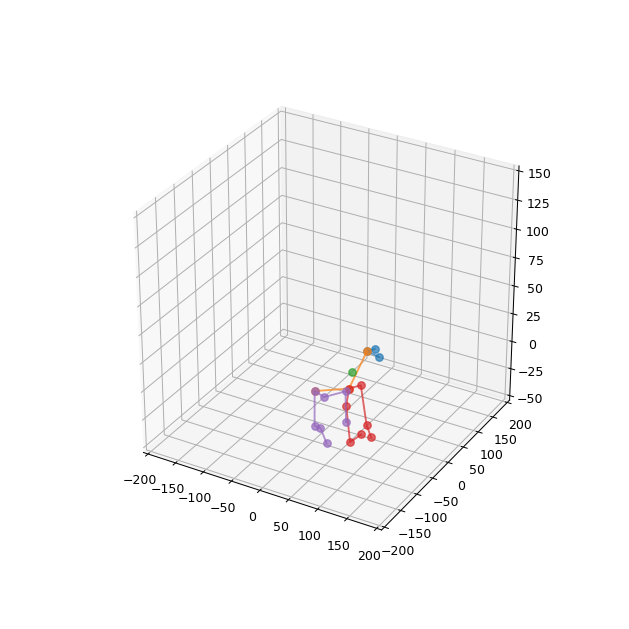

In [38]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = eh5.reshape((-1,19,3)) #
skipevery = 1


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
t = 609061
#for t in range(1,eh5.shape[0], 57):#goodsinraw[::60]:
ax1.clear()
for conn in connections:
    ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    

    fig.canvas.draw()   

Folder = 'C:\\Users\\14692\\RatDataSimulation\\'
plt.savefig(Folder + 'Rat Posture Picture.png')

### 3D Graph of Interpolated Centered Data

<IPython.core.display.Javascript object>


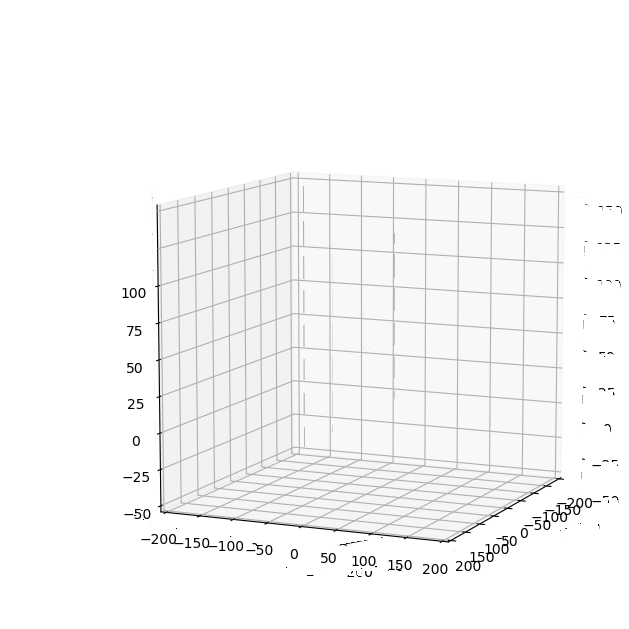

KeyboardInterrupt: 

In [11]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = eh5.reshape((-1,19,3)) #
skipevery = 1


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,eh5.shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

# Training Neural Network

In [74]:
#datafiltered = np.load('diego_mocap_files_rat_JDM31_day_13_nan.npy')
nanpoints = np.argwhere(np.isnan(datafiltered.reshape(-1,60)[:,:60]))
nanindex = np.unique(nanpoints[:,0])
yesnanindex = np.setdiff1d(np.arange(datafiltered.shape[0]), nanindex)

In [75]:
yesnandata = datafiltered[yesnanindex]

In [76]:
yesnandata.shape

(15775993, 60)

In [77]:
dropdata = yesnandata.reshape((-1,20,3))
dropdata = np.append(dropdata, dropdata[:,[4,6],:].mean(axis=1).reshape((-1,1,3)), axis=1)
dropdata = dropdata.reshape((-1,dropdata.shape[1]*dropdata.shape[2]))
dropdatacentered = egoh5(dropdata, ndims=3, bindcenter=19, b1=20, b2=18, silent=True)[:,:57]
np.save('dropdatacentered.npy', dropdatacentered)

In [4]:
dropdatacentered = np.load('dropdatacentered.npy')
sample = dropdatacentered[::5]

In [6]:
variational_ae = tf.keras.models.load_model('saved_model/four_layer_14')
print("Generate predictions for Interpolate centered data")
predictedX_sample = variational_ae.predict(sample)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(sample.reshape((-1,19,3))-predictedX_sample.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=3155199, minmax=(array([0.01450421, 0.01167782, 0.01304889, 0.02170671, 0.01139532,
       0.00646274, 0.01644157, 0.00822939, 0.00700969, 0.01690698,
       0.02152605, 0.00559565, 0.01741282, 0.01527057, 0.01633428,
       0.01464578, 0.02051206, 0.02038428, 0.01752871]), array([184.48693097, 178.17890842, 196.97641778, 170.48084685,
       182.42526615, 152.30736862, 179.77454555, 214.11744143,
       200.06921418, 236.35918563, 190.0165679 , 279.27177163,
       279.79149998, 227.58635695, 171.97878339, 240.94331368,
       196.09834121, 215.33515295, 232.45532439])), mean=array([4.68650846, 5.20890834, 4.39171168, 4.76918792, 2.83968623,
       3.32096727, 3.59015275, 3.03354852, 3.14298161, 3.30511977,
       3.5322896 , 2.82384859, 2.67702579, 5.07088656, 4.66797042,
       3.97647519, 3.75757582, 3.72969503, 2.79661213]), variance=array([17.26812887, 18.98038134, 17.08564918, 18.67587124,  5.7324807 ,
       10.30419025,  9.80919809, 11.10068875, 15.1573548 

In [7]:
#badX12 = np.where(np.mean(np.linalg.norm(X_good_filtered.reshape((-1,19,3))-predictedX_good_filtered.reshape((-1,19,3)), axis=2), axis=1) >= 35)
badX12 = np.where(np.any(np.linalg.norm(sample.reshape((-1,19,3))-predictedX_sample.reshape((-1,19,3)), axis=2) >= 20, axis=1)) #was 48
goodX12 = np.setdiff1d(np.arange(sample.shape[0]), badX12)
badXX12 = np.setdiff1d(np.arange(sample.shape[0]), goodX12)
sample_good = sample[goodX12,]
sample_bad = sample[badXX12,]
print('Shape of X = '+str(np.shape(sample))+'\n')
print('Shape of good X = '+str(np.shape(sample_good))+'\n')
print('Shape of bad X = '+str(np.shape(sample_bad))+'\n')


Shape of X = (3155199, 57)

Shape of good X = (3015354, 57)

Shape of bad X = (139845, 57)



<IPython.core.display.Javascript object>


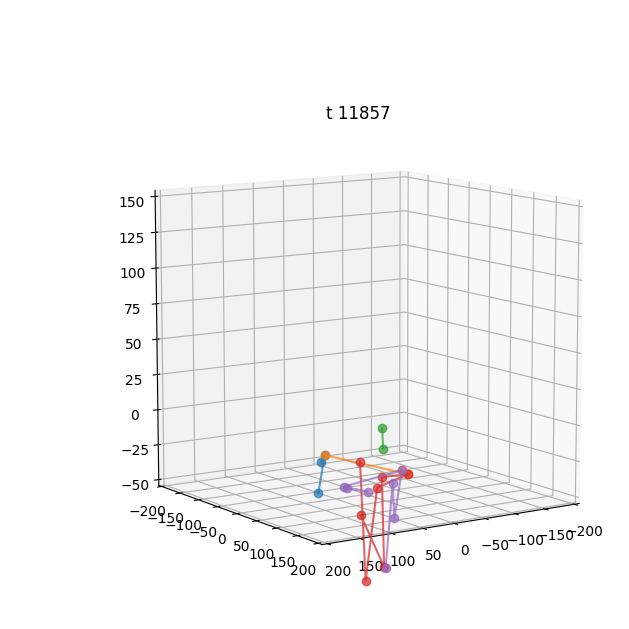

KeyboardInterrupt: 

In [10]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = sample_bad.reshape((-1,19,3)) #
skipevery = 1


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sample_bad.shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

<IPython.core.display.Javascript object>


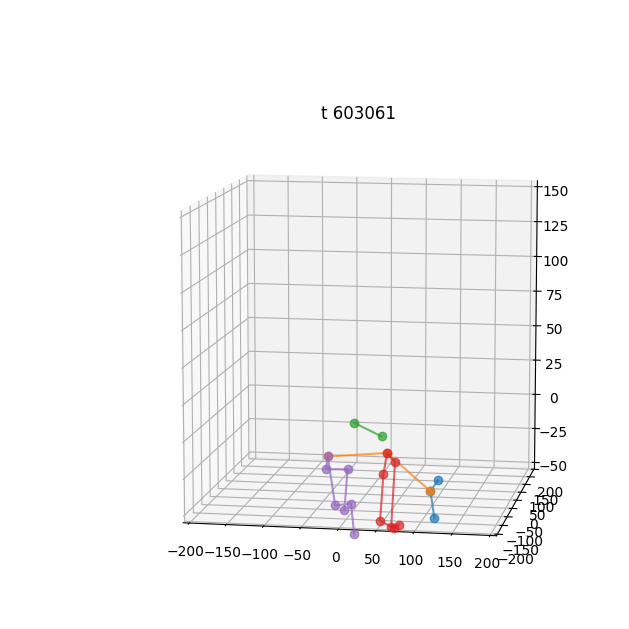

IndexError: index 3015590 is out of bounds for axis 0 with size 3015354

In [11]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = sample_good.reshape((-1,19,3)) #
skipevery = 5


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sample_good.shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

In [8]:
sample_good_modelindex1 = sample_good[:250000]
sample_good_modelindex2 = sample_good[275000:365000]
sample_good_modelindex3 = sample_good[370000:1175000]
sample_good_modelindex4 = sample_good[1180000:1935000]
sample_good_modelindex5 = sample_good[2015000:2650000]
sample_good_modelindex6 = sample_good[2700000:2950000]
sample_good_modelindex7 = sample_good[3000000:]

sample_good_manuallyfiltered = np.concatenate((sample_good_modelindex1, sample_good_modelindex2, sample_good_modelindex3, sample_good_modelindex4, sample_good_modelindex5, sample_good_modelindex6, sample_good_modelindex7), axis=0)
#5764.3 9697 9091.5 100 101 107-108.5 123-125 when 15 296points
#83-87 -> 166 174
print('Shape of sample_good_manuallyfiltered data = '+str(np.shape(sample_good_manuallyfiltered))+'\n')

Shape of sample_good_manuallyfiltered data = (2800354, 57)



In [9]:
X_train = np.delete(sample_good_manuallyfiltered, list(range(0,len(sample_good_manuallyfiltered),7)), axis =0)
X_valid = sample_good_manuallyfiltered[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae8 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae8.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae8.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_6'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae8.fit(X_train, X_train, epochs=1000, verbose=1, batch_size=15000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


Training Set Shape = (2400303, 57)

Validation Set Shape = (400051, 57)

Epoch 1/1000
161/161 [==============================] - 6s 32ms/step - loss: 1309.9972 - val_loss: 297.1462

Epoch 00001: loss improved from inf to 870.17957, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 2/1000
161/161 [==============================] - 5s 28ms/step - loss: 286.9723 - val_loss: 257.6900

Epoch 00002: loss improved from 870.17957 to 278.43503, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 3/1000
161/161 [==============================] - 4s 27ms/step - loss: 238.4404 - val_loss: 170.6027

Epoch 00003: loss improved from 278.43503 to 217.25436, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 4/1000
161/161 [==============================] - 4s 28ms/step - loss: 152.8748 - val_loss: 118.7844

Epoch 00

INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 64/1000
161/161 [==============================] - 4s 28ms/step - loss: 11.6097 - val_loss: 11.1902

Epoch 00064: loss did not improve from 11.37320
Epoch 65/1000
161/161 [==============================] - 4s 28ms/step - loss: 11.4069 - val_loss: 13.1432

Epoch 00065: loss improved from 11.37320 to 11.22470, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 66/1000
161/161 [==============================] - 5s 29ms/step - loss: 11.4439 - val_loss: 11.9798

Epoch 00066: loss improved from 11.22470 to 11.14073, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 67/1000
161/161 [==============================] - 4s 27ms/step - loss: 11.1567 - val_loss: 10.8944

Epoch 00067: loss improved from 11.14073 to 10.99693, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: sav

161/161 [==============================] - 4s 27ms/step - loss: 7.9468 - val_loss: 8.2970

Epoch 00140: loss did not improve from 7.72519
Epoch 141/1000
161/161 [==============================] - 4s 28ms/step - loss: 8.0661 - val_loss: 7.8079

Epoch 00141: loss did not improve from 7.72519
Epoch 142/1000
161/161 [==============================] - 5s 28ms/step - loss: 7.8106 - val_loss: 7.6271

Epoch 00142: loss did not improve from 7.72519
Epoch 143/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.4832 - val_loss: 7.5005

Epoch 00143: loss improved from 7.72519 to 7.53294, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 144/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.5735 - val_loss: 7.6345

Epoch 00144: loss did not improve from 7.53294
Epoch 145/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.5981 - val_loss: 8.1869

Epoch 00145: loss did not impro

161/161 [==============================] - 4s 28ms/step - loss: 7.2978 - val_loss: 9.0613

Epoch 00190: loss improved from 7.34053 to 7.31351, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 191/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.5704 - val_loss: 7.0671

Epoch 00191: loss did not improve from 7.31351
Epoch 192/1000
161/161 [==============================] - 4s 27ms/step - loss: 7.2362 - val_loss: 7.1181

Epoch 00192: loss improved from 7.31351 to 7.26303, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 193/1000
161/161 [==============================] - 4s 27ms/step - loss: 7.3174 - val_loss: 7.6811

Epoch 00193: loss did not improve from 7.26303
Epoch 194/1000
161/161 [==============================] - 4s 27ms/step - loss: 7.3086 - val_loss: 7.1269

Epoch 00194: loss improved from 7.26303 to 7.24561, saving model to sav

161/161 [==============================] - 5s 28ms/step - loss: 7.4024 - val_loss: 6.8934

Epoch 00280: loss did not improve from 6.56646
Epoch 281/1000
161/161 [==============================] - 5s 28ms/step - loss: 7.0674 - val_loss: 7.0732

Epoch 00281: loss did not improve from 6.56646
Epoch 282/1000
161/161 [==============================] - 5s 28ms/step - loss: 7.0107 - val_loss: 6.9335

Epoch 00282: loss did not improve from 6.56646
Epoch 283/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.0509 - val_loss: 7.0262

Epoch 00283: loss did not improve from 6.56646
Epoch 284/1000
161/161 [==============================] - 5s 28ms/step - loss: 7.1535 - val_loss: 6.9328

Epoch 00284: loss did not improve from 6.56646
Epoch 285/1000
161/161 [==============================] - 4s 27ms/step - loss: 6.9991 - val_loss: 7.2122

Epoch 00285: loss did not improve from 6.56646
Epoch 286/1000
161/161 [==============================] - 4s 28ms/step - loss: 6.8663 - val_loss:

INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 373/1000
161/161 [==============================] - 4s 27ms/step - loss: 6.1240 - val_loss: 6.0531

Epoch 00373: loss did not improve from 6.00845
Epoch 374/1000
161/161 [==============================] - 4s 27ms/step - loss: 6.0048 - val_loss: 6.0769

Epoch 00374: loss improved from 6.00845 to 6.00296, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 375/1000
161/161 [==============================] - 4s 27ms/step - loss: 6.1326 - val_loss: 6.0174

Epoch 00375: loss did not improve from 6.00296
Epoch 376/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.9796 - val_loss: 6.0325

Epoch 00376: loss improved from 6.00296 to 5.98969, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 377/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.9975 - val_los

161/161 [==============================] - 4s 28ms/step - loss: 7.2004 - val_loss: 7.9215

Epoch 00421: loss did not improve from 5.90160
Epoch 422/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.1862 - val_loss: 6.7432

Epoch 00422: loss did not improve from 5.90160
Epoch 423/1000
161/161 [==============================] - 4s 27ms/step - loss: 7.1267 - val_loss: 6.7523

Epoch 00423: loss did not improve from 5.90160
Epoch 424/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.0096 - val_loss: 6.7861

Epoch 00424: loss did not improve from 5.90160
Epoch 425/1000
161/161 [==============================] - 4s 28ms/step - loss: 6.7336 - val_loss: 6.6666

Epoch 00425: loss did not improve from 5.90160
Epoch 426/1000
161/161 [==============================] - 4s 28ms/step - loss: 7.2084 - val_loss: 6.9180

Epoch 00426: loss did not improve from 5.90160
Epoch 427/1000
161/161 [==============================] - 4s 28ms/step - loss: 6.8642 - val_loss:


Epoch 00474: loss did not improve from 5.90160
Epoch 475/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.8950 - val_loss: 5.9249

Epoch 00475: loss did not improve from 5.90160
Epoch 476/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.8853 - val_loss: 6.5171

Epoch 00476: loss did not improve from 5.90160
Epoch 477/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.9841 - val_loss: 5.8953

Epoch 00477: loss did not improve from 5.90160
Epoch 478/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.9187 - val_loss: 5.8940

Epoch 00478: loss did not improve from 5.90160
Epoch 479/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.8768 - val_loss: 6.1011

Epoch 00479: loss improved from 5.90160 to 5.88534, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 480/1000
161/161 [==============================] - 4s 27ms/step - l


Epoch 00518: loss improved from 5.77140 to 5.75666, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 519/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.8063 - val_loss: 5.8662

Epoch 00519: loss did not improve from 5.75666
Epoch 520/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.7639 - val_loss: 5.9766

Epoch 00520: loss did not improve from 5.75666
Epoch 521/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.7980 - val_loss: 5.7228

Epoch 00521: loss did not improve from 5.75666
Epoch 522/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.7476 - val_loss: 6.0023

Epoch 00522: loss improved from 5.75666 to 5.74134, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 523/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.7860 - val_loss: 5.7446

Epoch 00


Epoch 00562: loss improved from 5.67137 to 5.66509, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 563/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.7380 - val_loss: 5.6640

Epoch 00563: loss did not improve from 5.66509
Epoch 564/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.6679 - val_loss: 5.7655

Epoch 00564: loss improved from 5.66509 to 5.66339, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 565/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.6748 - val_loss: 5.7815

Epoch 00565: loss improved from 5.66339 to 5.65853, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 566/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.6742 - val_loss: 5.7617

Epoch 00566: loss did not improve from 5.65853
E

161/161 [==============================] - 4s 27ms/step - loss: 5.5278 - val_loss: 5.5556

Epoch 00655: loss did not improve from 5.52026
Epoch 656/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.5325 - val_loss: 5.5477

Epoch 00656: loss did not improve from 5.52026
Epoch 657/1000
161/161 [==============================] - 5s 28ms/step - loss: 5.5106 - val_loss: 5.6369

Epoch 00657: loss improved from 5.52026 to 5.51562, saving model to saved_model/four_layer_6
INFO:tensorflow:Assets written to: saved_model/four_layer_6/assets
Epoch 658/1000
161/161 [==============================] - 5s 28ms/step - loss: 5.5369 - val_loss: 5.6834

Epoch 00658: loss did not improve from 5.51562
Epoch 659/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.5339 - val_loss: 5.5604

Epoch 00659: loss did not improve from 5.51562
Epoch 660/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.5281 - val_loss: 5.5389

Epoch 00660: loss did not impro

161/161 [==============================] - 4s 27ms/step - loss: 5.4462 - val_loss: 5.7463

Epoch 00750: loss did not improve from 5.38115
Epoch 751/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.4532 - val_loss: 5.6236

Epoch 00751: loss did not improve from 5.38115
Epoch 752/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.4512 - val_loss: 5.4916

Epoch 00752: loss did not improve from 5.38115
Epoch 753/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.4067 - val_loss: 5.6251

Epoch 00753: loss did not improve from 5.38115
Epoch 754/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.4860 - val_loss: 5.5907

Epoch 00754: loss did not improve from 5.38115
Epoch 755/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.4575 - val_loss: 5.4636

Epoch 00755: loss did not improve from 5.38115
Epoch 756/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.4333 - val_loss:

161/161 [==============================] - 4s 27ms/step - loss: 6.6408 - val_loss: 6.3697

Epoch 00803: loss did not improve from 5.37779
Epoch 804/1000
161/161 [==============================] - 4s 28ms/step - loss: 6.2671 - val_loss: 6.1639

Epoch 00804: loss did not improve from 5.37779
Epoch 805/1000
161/161 [==============================] - 4s 28ms/step - loss: 6.1957 - val_loss: 6.0673

Epoch 00805: loss did not improve from 5.37779
Epoch 806/1000
161/161 [==============================] - 4s 28ms/step - loss: 6.2307 - val_loss: 6.1126

Epoch 00806: loss did not improve from 5.37779
Epoch 807/1000
161/161 [==============================] - 4s 28ms/step - loss: 6.1041 - val_loss: 5.9927

Epoch 00807: loss did not improve from 5.37779
Epoch 808/1000
161/161 [==============================] - 4s 27ms/step - loss: 6.0649 - val_loss: 5.9562

Epoch 00808: loss did not improve from 5.37779
Epoch 809/1000
161/161 [==============================] - 4s 27ms/step - loss: 6.1261 - val_loss:


Epoch 00856: loss did not improve from 5.37779
Epoch 857/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.7945 - val_loss: 5.7380

Epoch 00857: loss did not improve from 5.37779
Epoch 858/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.7186 - val_loss: 5.7450

Epoch 00858: loss did not improve from 5.37779
Epoch 859/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.7612 - val_loss: 5.6776

Epoch 00859: loss did not improve from 5.37779
Epoch 860/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.6664 - val_loss: 5.7437

Epoch 00860: loss did not improve from 5.37779
Epoch 861/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.7988 - val_loss: 5.7726

Epoch 00861: loss did not improve from 5.37779
Epoch 862/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.7127 - val_loss: 5.7786

Epoch 00862: loss did not improve from 5.37779
Epoch 863/1000
161/161 [==========


Epoch 00963: loss did not improve from 5.37779
Epoch 964/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.6102 - val_loss: 5.8590

Epoch 00964: loss did not improve from 5.37779
Epoch 965/1000
161/161 [==============================] - 4s 28ms/step - loss: 5.7522 - val_loss: 5.6737

Epoch 00965: loss did not improve from 5.37779
Epoch 966/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.9100 - val_loss: 5.6922

Epoch 00966: loss did not improve from 5.37779
Epoch 967/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.5988 - val_loss: 5.5894

Epoch 00967: loss did not improve from 5.37779
Epoch 968/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.5431 - val_loss: 5.5529

Epoch 00968: loss did not improve from 5.37779
Epoch 969/1000
161/161 [==============================] - 4s 27ms/step - loss: 5.5412 - val_loss: 5.5449

Epoch 00969: loss did not improve from 5.37779
Epoch 970/1000
161/161 [==========

In [10]:
#variational_ae = tf.keras.models.load_model('saved_model/four_layer_14')
print("Generate predictions for Interpolate centered data")
predictedX_sample_good_manuallyfiltered = variational_ae8.predict(sample_good_manuallyfiltered)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(sample_good_manuallyfiltered.reshape((-1,19,3))-predictedX_sample_good_manuallyfiltered.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=2800354, minmax=(array([0.01673869, 0.01804651, 0.02533394, 0.01105641, 0.01061133,
       0.01571114, 0.0130868 , 0.01316765, 0.01531651, 0.01839476,
       0.01693308, 0.01189518, 0.01708506, 0.03865023, 0.01248088,
       0.01624201, 0.01075275, 0.02046474, 0.02419089]), array([66.43017208, 99.28992765, 39.18721526, 71.76365703, 38.85387308,
       32.69748059, 35.52308283, 56.43194001, 91.20085866, 62.36411955,
       47.19878338, 22.2751139 , 28.00198412, 39.76339949, 47.20778961,
       40.33501943, 49.90428192, 45.00247458, 29.18158375])), mean=array([4.36338369, 4.64796371, 4.07591215, 4.12913245, 2.56295658,
       3.11786495, 3.16247332, 2.64722232, 2.61060717, 2.78176336,
       2.91833487, 2.33640835, 2.24122402, 4.3523518 , 4.02005442,
       3.33668342, 3.30831785, 3.03760606, 2.49249201]), variance=array([ 9.24522101, 10.71587159,  7.20007719,  7.66425869,  2.24114599,
        3.55910872,  4.20488458,  2.82603917,  5.17573574,  3.76481464,
        4.7

<IPython.core.display.Javascript object>


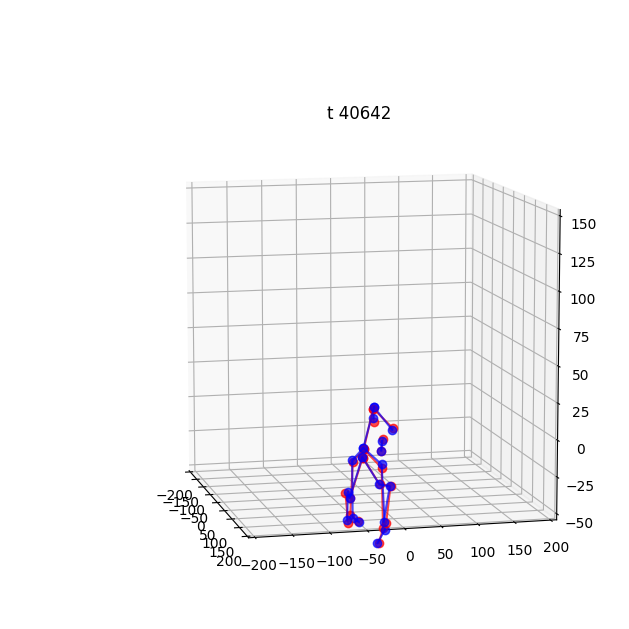

KeyboardInterrupt: 

In [11]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = predictedX_sample_good_manuallyfiltered.reshape((-1,19,3)) #Nan filled with VAE prediction
tw = sample_good_manuallyfiltered.reshape((-1,19,3)) # Original
skipevery = 10


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,predictedX_sample_good_manuallyfiltered.shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    #plt.savefig("/home/shin/OriginalDataFix/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

In [3]:
eh5 = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
sampleeh5 = eh5[::10]

In [9]:
sampleeh5

array([[  59.85134991,  272.75527569, -111.47659662, ...,  -29.8446168 ,
         257.31285398,  -70.82715101],
       [  59.80663899,  272.71807408, -111.5626334 , ...,  -29.84833501,
         257.30691938,  -70.74657649],
       [  59.6650128 ,  272.69778541, -111.66824702, ...,  -29.93705663,
         257.29668478,  -70.66240057],
       ...,
       [  48.06131757,   22.19350028,  -76.64389631, ...,  -54.7091268 ,
          -1.71443866,  -24.41861542],
       [  48.29810457,   20.57974275,  -76.7941135 , ...,  -54.53683326,
          -2.08638726,  -24.93937477],
       [  47.44422421,   20.55603515,  -77.53817291, ...,  -54.54455668,
          -1.96113519,  -24.95688333]])

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
X_train = np.delete(sampleeh5, list(range(0,len(sampleeh5),7)), axis =0)
X_valid = sampleeh5[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= None)(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = None)(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_100'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae.fit(X_train, X_train, epochs=100, verbose=1, batch_size=5000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


Training Set Shape = (1712571, 57)

Validation Set Shape = (285429, 57)

Epoch 1/100
341/343 [============================>.] - ETA: 0s - loss: nan
Epoch 00001: loss did not improve from inf
343/343 [==============================] - 4s 9ms/step - loss: nan - val_loss: nan
Epoch 2/100
337/343 [============================>.] - ETA: 0s - loss: nan
Epoch 00002: loss did not improve from inf
343/343 [==============================] - 3s 8ms/step - loss: nan - val_loss: nan
Epoch 3/100
 29/343 [=>............................] - ETA: 2s - loss: nan

KeyboardInterrupt: 

In [24]:
predictedX_sampleeh5 = variational_ae8.predict(sampleeh5)

<IPython.core.display.Javascript object>


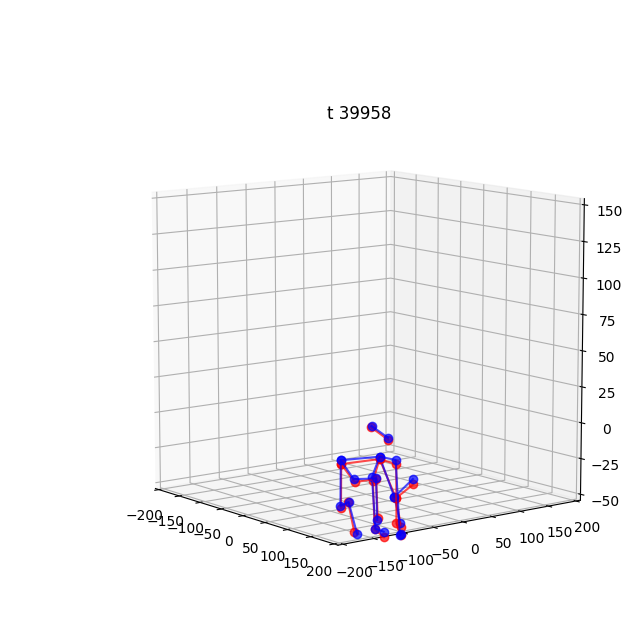

IndexError: index 2000750 is out of bounds for axis 0 with size 1998000

In [27]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = predictedX_sampleeh5.reshape((-1,19,3)) #Nan filled with VAE prediction
tw = sampleeh5.reshape((-1,19,3)) # Original
skipevery = 50


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sampleeh5.shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    plt.savefig("/home/shin/Prediction_Interpolated_vs_Interpolated/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

In [28]:
X_train = np.delete(sample_good_manuallyfiltered, list(range(0,len(sample_good_manuallyfiltered),7)), axis =0)
X_valid = sample_good_manuallyfiltered[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_7'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae.fit(X_train, X_train, epochs=5000, verbose=1, batch_size=20000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


Training Set Shape = (2400303, 57)

Validation Set Shape = (400051, 57)

Epoch 1/5000
121/121 [==============================] - 5s 37ms/step - loss: 1399.0074 - val_loss: 372.8123

Epoch 00001: loss improved from inf to 1027.91699, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 2/5000
121/121 [==============================] - 4s 35ms/step - loss: 322.7382 - val_loss: 281.9400

Epoch 00002: loss improved from 1027.91699 to 301.91031, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 3/5000
121/121 [==============================] - 4s 34ms/step - loss: 275.3584 - val_loss: 245.7745

Epoch 00003: loss improved from 301.91031 to 267.64706, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 4/5000
121/121 [==============================] - 4s 34ms/step - loss: 229.1413 - val_loss: 175.5623

Epoch 

121/121 [==============================] - 4s 32ms/step - loss: 13.8879 - val_loss: 13.3386

Epoch 00064: loss improved from 14.36430 to 13.89519, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 65/5000
121/121 [==============================] - 4s 32ms/step - loss: 13.4364 - val_loss: 13.6867

Epoch 00065: loss improved from 13.89519 to 13.62803, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 66/5000
121/121 [==============================] - 4s 31ms/step - loss: 13.4942 - val_loss: 13.0004

Epoch 00066: loss improved from 13.62803 to 13.55101, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 67/5000
121/121 [==============================] - 4s 32ms/step - loss: 13.0256 - val_loss: 15.4447

Epoch 00067: loss improved from 13.55101 to 13.47181, saving model to saved_model/four_layer_7
INFO:

Epoch 146/5000
121/121 [==============================] - 4s 32ms/step - loss: 8.5451 - val_loss: 8.3411

Epoch 00146: loss did not improve from 8.23341
Epoch 147/5000
121/121 [==============================] - 4s 32ms/step - loss: 8.2657 - val_loss: 8.1524

Epoch 00147: loss did not improve from 8.23341
Epoch 148/5000
121/121 [==============================] - 4s 32ms/step - loss: 8.2182 - val_loss: 11.4849

Epoch 00148: loss did not improve from 8.23341
Epoch 149/5000
121/121 [==============================] - 4s 32ms/step - loss: 8.8803 - val_loss: 7.9758

Epoch 00149: loss did not improve from 8.23341
Epoch 150/5000
121/121 [==============================] - 4s 32ms/step - loss: 8.1553 - val_loss: 8.8288

Epoch 00150: loss did not improve from 8.23341
Epoch 151/5000
121/121 [==============================] - 4s 32ms/step - loss: 8.3897 - val_loss: 8.2750

Epoch 00151: loss did not improve from 8.23341
Epoch 152/5000
121/121 [==============================] - 4s 32ms/step - loss: 8.


Epoch 00190: loss did not improve from 7.66732
Epoch 191/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.8060 - val_loss: 7.6112

Epoch 00191: loss did not improve from 7.66732
Epoch 192/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.6042 - val_loss: 7.6574

Epoch 00192: loss improved from 7.66732 to 7.61805, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 193/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.5702 - val_loss: 7.5807

Epoch 00193: loss improved from 7.61805 to 7.57946, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 194/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.6715 - val_loss: 7.4933

Epoch 00194: loss did not improve from 7.57946
Epoch 195/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.6502 - val_loss: 7.4162

Epoch 00

121/121 [==============================] - 4s 30ms/step - loss: 7.1415 - val_loss: 8.6126

Epoch 00237: loss did not improve from 6.97166
Epoch 238/5000
121/121 [==============================] - 4s 31ms/step - loss: 8.5169 - val_loss: 6.8839

Epoch 00238: loss did not improve from 6.97166
Epoch 239/5000
121/121 [==============================] - 4s 31ms/step - loss: 6.8655 - val_loss: 7.0384

Epoch 00239: loss improved from 6.97166 to 6.90662, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 240/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.9898 - val_loss: 7.0617

Epoch 00240: loss did not improve from 6.90662
Epoch 241/5000
121/121 [==============================] - 4s 31ms/step - loss: 6.9599 - val_loss: 6.8551

Epoch 00241: loss did not improve from 6.90662
Epoch 242/5000
121/121 [==============================] - 4s 31ms/step - loss: 6.9225 - val_loss: 7.0085

Epoch 00242: loss did not impro


Epoch 00287: loss did not improve from 6.83762
Epoch 288/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.4565 - val_loss: 7.2170

Epoch 00288: loss did not improve from 6.83762
Epoch 289/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.3247 - val_loss: 7.1280

Epoch 00289: loss did not improve from 6.83762
Epoch 290/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.3755 - val_loss: 7.2514

Epoch 00290: loss did not improve from 6.83762
Epoch 291/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.3835 - val_loss: 7.3036

Epoch 00291: loss did not improve from 6.83762
Epoch 292/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.2069 - val_loss: 7.2794

Epoch 00292: loss did not improve from 6.83762
Epoch 293/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.3382 - val_loss: 7.1443

Epoch 00293: loss did not improve from 6.83762
Epoch 294/5000
121/121 [==========

121/121 [==============================] - 4s 30ms/step - loss: 6.7578 - val_loss: 6.5930

Epoch 00337: loss did not improve from 6.57565
Epoch 338/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.6312 - val_loss: 6.5771

Epoch 00338: loss did not improve from 6.57565
Epoch 339/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.6980 - val_loss: 7.2703

Epoch 00339: loss did not improve from 6.57565
Epoch 340/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.7115 - val_loss: 6.5547

Epoch 00340: loss did not improve from 6.57565
Epoch 341/5000
121/121 [==============================] - 4s 32ms/step - loss: 6.6616 - val_loss: 6.5607

Epoch 00341: loss did not improve from 6.57565
Epoch 342/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.7318 - val_loss: 6.6553

Epoch 00342: loss did not improve from 6.57565
Epoch 343/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.5107 - val_loss:

121/121 [==============================] - 4s 30ms/step - loss: 8.6545 - val_loss: 8.4021

Epoch 00387: loss did not improve from 6.37327
Epoch 388/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.3442 - val_loss: 7.7680

Epoch 00388: loss did not improve from 6.37327
Epoch 389/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.3605 - val_loss: 7.9849

Epoch 00389: loss did not improve from 6.37327
Epoch 390/5000
121/121 [==============================] - 4s 31ms/step - loss: 8.5219 - val_loss: 7.6407

Epoch 00390: loss did not improve from 6.37327
Epoch 391/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.1153 - val_loss: 7.8782

Epoch 00391: loss did not improve from 6.37327
Epoch 392/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.8497 - val_loss: 7.9366

Epoch 00392: loss did not improve from 6.37327
Epoch 393/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.7955 - val_loss:


Epoch 00440: loss did not improve from 6.37327
Epoch 441/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.6314 - val_loss: 8.2088

Epoch 00441: loss did not improve from 6.37327
Epoch 442/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.0853 - val_loss: 6.4370

Epoch 00442: loss did not improve from 6.37327
Epoch 443/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.4315 - val_loss: 6.8001

Epoch 00443: loss did not improve from 6.37327
Epoch 444/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.7850 - val_loss: 7.2028

Epoch 00444: loss did not improve from 6.37327
Epoch 445/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.5377 - val_loss: 6.5178

Epoch 00445: loss did not improve from 6.37327
Epoch 446/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.5463 - val_loss: 6.3870

Epoch 00446: loss did not improve from 6.37327
Epoch 447/5000
121/121 [==========

INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 489/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1114 - val_loss: 6.3294

Epoch 00489: loss improved from 6.13751 to 6.12947, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 490/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1448 - val_loss: 6.1382

Epoch 00490: loss did not improve from 6.12947
Epoch 491/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1486 - val_loss: 6.1529

Epoch 00491: loss did not improve from 6.12947
Epoch 492/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1389 - val_loss: 6.2238

Epoch 00492: loss did not improve from 6.12947
Epoch 493/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1462 - val_loss: 6.5358

Epoch 00493: loss improved from 6.12947 to 6.11772, saving model to saved_model/four_layer_7
INFO:tens

Epoch 538/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.0291 - val_loss: 6.1801

Epoch 00538: loss did not improve from 5.96063
Epoch 539/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.2449 - val_loss: 6.0051

Epoch 00539: loss did not improve from 5.96063
Epoch 540/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.0061 - val_loss: 6.2428

Epoch 00540: loss did not improve from 5.96063
Epoch 541/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.0264 - val_loss: 6.0063

Epoch 00541: loss did not improve from 5.96063
Epoch 542/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9991 - val_loss: 6.0674

Epoch 00542: loss did not improve from 5.96063
Epoch 543/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1011 - val_loss: 5.9685

Epoch 00543: loss did not improve from 5.96063
Epoch 544/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9


Epoch 00590: loss did not improve from 5.95068
Epoch 591/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.3639 - val_loss: 6.3349

Epoch 00591: loss did not improve from 5.95068
Epoch 592/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.3056 - val_loss: 7.1840

Epoch 00592: loss did not improve from 5.95068
Epoch 593/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.5030 - val_loss: 6.2779

Epoch 00593: loss did not improve from 5.95068
Epoch 594/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.3719 - val_loss: 6.6473

Epoch 00594: loss did not improve from 5.95068
Epoch 595/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.4792 - val_loss: 6.3563

Epoch 00595: loss did not improve from 5.95068
Epoch 596/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.4169 - val_loss: 6.2230

Epoch 00596: loss did not improve from 5.95068
Epoch 597/5000
121/121 [==========

121/121 [==============================] - 4s 30ms/step - loss: 6.1110 - val_loss: 5.8518

Epoch 00689: loss did not improve from 5.80585
Epoch 690/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8164 - val_loss: 5.8766

Epoch 00690: loss did not improve from 5.80585
Epoch 691/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8345 - val_loss: 5.8487

Epoch 00691: loss did not improve from 5.80585
Epoch 692/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8446 - val_loss: 5.9922

Epoch 00692: loss did not improve from 5.80585
Epoch 693/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8239 - val_loss: 5.9405

Epoch 00693: loss did not improve from 5.80585
Epoch 694/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8140 - val_loss: 5.8248

Epoch 00694: loss improved from 5.80585 to 5.79248, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four

121/121 [==============================] - 4s 31ms/step - loss: 5.8841 - val_loss: 6.4256

Epoch 00742: loss did not improve from 5.79248
Epoch 743/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.0136 - val_loss: 5.8666

Epoch 00743: loss did not improve from 5.79248
Epoch 744/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7761 - val_loss: 5.8946

Epoch 00744: loss improved from 5.79248 to 5.77020, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 745/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8588 - val_loss: 5.7679

Epoch 00745: loss did not improve from 5.77020
Epoch 746/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7618 - val_loss: 5.7779

Epoch 00746: loss improved from 5.77020 to 5.76509, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 747/5000
121/121 [

121/121 [==============================] - 4s 30ms/step - loss: 5.6629 - val_loss: 6.1628

Epoch 00789: loss did not improve from 5.65619
Epoch 790/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7907 - val_loss: 5.7583

Epoch 00790: loss did not improve from 5.65619
Epoch 791/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6935 - val_loss: 5.7154

Epoch 00791: loss did not improve from 5.65619
Epoch 792/5000
121/121 [==============================] - 4s 30ms/step - loss: 21.8226 - val_loss: 25.5320

Epoch 00792: loss did not improve from 5.65619
Epoch 793/5000
121/121 [==============================] - 4s 30ms/step - loss: 23.3065 - val_loss: 17.1940

Epoch 00793: loss did not improve from 5.65619
Epoch 794/5000
121/121 [==============================] - 4s 30ms/step - loss: 16.3251 - val_loss: 13.4932

Epoch 00794: loss did not improve from 5.65619
Epoch 795/5000
121/121 [==============================] - 4s 30ms/step - loss: 13.1141 - va


Epoch 00842: loss did not improve from 5.65619
Epoch 843/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7730 - val_loss: 5.7787

Epoch 00843: loss did not improve from 5.65619
Epoch 844/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7253 - val_loss: 5.7552

Epoch 00844: loss did not improve from 5.65619
Epoch 845/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7638 - val_loss: 5.8321

Epoch 00845: loss did not improve from 5.65619
Epoch 846/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7147 - val_loss: 5.8493

Epoch 00846: loss did not improve from 5.65619
Epoch 847/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7504 - val_loss: 5.8168

Epoch 00847: loss did not improve from 5.65619
Epoch 848/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7899 - val_loss: 5.6854

Epoch 00848: loss did not improve from 5.65619
Epoch 849/5000
121/121 [==========


Epoch 00892: loss did not improve from 5.58379
Epoch 893/5000
121/121 [==============================] - 4s 29ms/step - loss: 5.6253 - val_loss: 6.0486

Epoch 00893: loss did not improve from 5.58379
Epoch 894/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6600 - val_loss: 5.6898

Epoch 00894: loss did not improve from 5.58379
Epoch 895/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5988 - val_loss: 5.6705

Epoch 00895: loss improved from 5.58379 to 5.56753, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 896/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7210 - val_loss: 5.6333

Epoch 00896: loss did not improve from 5.56753
Epoch 897/5000
121/121 [==============================] - 4s 30ms/step - loss: 9.2631 - val_loss: 11.1859

Epoch 00897: loss did not improve from 5.56753
Epoch 898/5000
121/121 [==============================] - 4s 30ms/step - 


Epoch 00942: loss did not improve from 5.51331
Epoch 943/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5843 - val_loss: 5.6538

Epoch 00943: loss did not improve from 5.51331
Epoch 944/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5440 - val_loss: 5.8205

Epoch 00944: loss did not improve from 5.51331
Epoch 945/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5714 - val_loss: 5.5276

Epoch 00945: loss did not improve from 5.51331
Epoch 946/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5108 - val_loss: 5.6248

Epoch 00946: loss improved from 5.51331 to 5.50468, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 947/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5416 - val_loss: 5.6986

Epoch 00947: loss did not improve from 5.50468
Epoch 948/5000
121/121 [==============================] - 4s 30ms/step - l

121/121 [==============================] - 4s 31ms/step - loss: 5.5133 - val_loss: 5.4969

Epoch 01043: loss did not improve from 5.46050
Epoch 1044/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4856 - val_loss: 5.5414

Epoch 01044: loss did not improve from 5.46050
Epoch 1045/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4887 - val_loss: 5.5633

Epoch 01045: loss did not improve from 5.46050
Epoch 1046/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4979 - val_loss: 5.5673

Epoch 01046: loss did not improve from 5.46050
Epoch 1047/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4807 - val_loss: 5.5459

Epoch 01047: loss improved from 5.46050 to 5.45105, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 1048/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.5040 - val_loss: 5.6071

Epoch 01048: loss did not 

121/121 [==============================] - 4s 30ms/step - loss: 5.4154 - val_loss: 5.5203

Epoch 01092: loss did not improve from 5.39658
Epoch 1093/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4428 - val_loss: 5.6599

Epoch 01093: loss did not improve from 5.39658
Epoch 1094/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4662 - val_loss: 5.6187

Epoch 01094: loss did not improve from 5.39658
Epoch 1095/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4338 - val_loss: 5.3975

Epoch 01095: loss did not improve from 5.39658
Epoch 1096/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4320 - val_loss: 5.4856

Epoch 01096: loss did not improve from 5.39658
Epoch 1097/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3776 - val_loss: 5.5487

Epoch 01097: loss improved from 5.39658 to 5.36824, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model

121/121 [==============================] - 4s 30ms/step - loss: 10.2837 - val_loss: 9.7748

Epoch 01193: loss did not improve from 5.32519
Epoch 1194/5000
121/121 [==============================] - 4s 31ms/step - loss: 9.7088 - val_loss: 9.2909

Epoch 01194: loss did not improve from 5.32519
Epoch 1195/5000
121/121 [==============================] - 4s 31ms/step - loss: 9.3798 - val_loss: 9.0292

Epoch 01195: loss did not improve from 5.32519
Epoch 1196/5000
121/121 [==============================] - 4s 31ms/step - loss: 9.0754 - val_loss: 8.5209

Epoch 01196: loss did not improve from 5.32519
Epoch 1197/5000
121/121 [==============================] - 4s 31ms/step - loss: 8.7909 - val_loss: 8.2627

Epoch 01197: loss did not improve from 5.32519
Epoch 1198/5000
121/121 [==============================] - 4s 31ms/step - loss: 8.3202 - val_loss: 8.1908

Epoch 01198: loss did not improve from 5.32519
Epoch 1199/5000
121/121 [==============================] - 4s 31ms/step - loss: 8.2975 - va

121/121 [==============================] - 4s 31ms/step - loss: 5.5815 - val_loss: 5.6253

Epoch 01299: loss did not improve from 5.32519
Epoch 1300/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5790 - val_loss: 5.7070

Epoch 01300: loss did not improve from 5.32519
Epoch 1301/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6475 - val_loss: 5.5864

Epoch 01301: loss did not improve from 5.32519
Epoch 1302/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6288 - val_loss: 5.6050

Epoch 01302: loss did not improve from 5.32519
Epoch 1303/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6107 - val_loss: 5.6136

Epoch 01303: loss did not improve from 5.32519
Epoch 1304/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6089 - val_loss: 5.6612

Epoch 01304: loss did not improve from 5.32519
Epoch 1305/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8904 - val

121/121 [==============================] - 4s 30ms/step - loss: 5.5096 - val_loss: 5.4725

Epoch 01405: loss did not improve from 5.32519
Epoch 1406/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4728 - val_loss: 5.5122

Epoch 01406: loss did not improve from 5.32519
Epoch 1407/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4951 - val_loss: 5.5203

Epoch 01407: loss did not improve from 5.32519
Epoch 1408/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4721 - val_loss: 5.4364

Epoch 01408: loss did not improve from 5.32519
Epoch 1409/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.4627 - val_loss: 5.4601

Epoch 01409: loss did not improve from 5.32519
Epoch 1410/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.4988 - val_loss: 5.4510

Epoch 01410: loss did not improve from 5.32519
Epoch 1411/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4333 - val

121/121 [==============================] - 4s 30ms/step - loss: 6.2724 - val_loss: 5.9751

Epoch 01509: loss did not improve from 5.28514
Epoch 1510/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9980 - val_loss: 5.8263

Epoch 01510: loss did not improve from 5.28514
Epoch 1511/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8971 - val_loss: 5.7793

Epoch 01511: loss did not improve from 5.28514
Epoch 1512/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.8517 - val_loss: 5.6660

Epoch 01512: loss did not improve from 5.28514
Epoch 1513/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6705 - val_loss: 5.6452

Epoch 01513: loss did not improve from 5.28514
Epoch 1514/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7846 - val_loss: 5.5892

Epoch 01514: loss did not improve from 5.28514
Epoch 1515/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.6008 - val

121/121 [==============================] - 4s 30ms/step - loss: 6.6296 - val_loss: 6.2837

Epoch 01615: loss did not improve from 5.28514
Epoch 1616/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.4388 - val_loss: 6.1969

Epoch 01616: loss did not improve from 5.28514
Epoch 1617/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.2433 - val_loss: 6.0389

Epoch 01617: loss did not improve from 5.28514
Epoch 1618/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1322 - val_loss: 6.2734

Epoch 01618: loss did not improve from 5.28514
Epoch 1619/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.0649 - val_loss: 6.2476

Epoch 01619: loss did not improve from 5.28514
Epoch 1620/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.0561 - val_loss: 6.0232

Epoch 01620: loss did not improve from 5.28514
Epoch 1621/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9888 - val

121/121 [==============================] - 4s 29ms/step - loss: 5.3600 - val_loss: 5.3403

Epoch 01721: loss did not improve from 5.28514
Epoch 1722/5000
121/121 [==============================] - 4s 29ms/step - loss: 5.3053 - val_loss: 5.4929

Epoch 01722: loss did not improve from 5.28514
Epoch 1723/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3942 - val_loss: 5.4134

Epoch 01723: loss did not improve from 5.28514
Epoch 1724/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3411 - val_loss: 5.4879

Epoch 01724: loss did not improve from 5.28514
Epoch 1725/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.3453 - val_loss: 5.3268

Epoch 01725: loss did not improve from 5.28514
Epoch 1726/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3350 - val_loss: 5.7356

Epoch 01726: loss did not improve from 5.28514
Epoch 1727/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.3501 - val

121/121 [==============================] - 4s 30ms/step - loss: 8.3131 - val_loss: 7.7688

Epoch 01827: loss did not improve from 5.28514
Epoch 1828/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.1756 - val_loss: 7.6987

Epoch 01828: loss did not improve from 5.28514
Epoch 1829/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.9080 - val_loss: 7.5025

Epoch 01829: loss did not improve from 5.28514
Epoch 1830/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.6813 - val_loss: 7.5054

Epoch 01830: loss did not improve from 5.28514
Epoch 1831/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.6097 - val_loss: 7.3558

Epoch 01831: loss did not improve from 5.28514
Epoch 1832/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.4325 - val_loss: 7.9697

Epoch 01832: loss did not improve from 5.28514
Epoch 1833/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.7077 - val

121/121 [==============================] - 4s 31ms/step - loss: 5.3162 - val_loss: 5.4690

Epoch 01933: loss did not improve from 5.28514
Epoch 1934/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3333 - val_loss: 5.3245

Epoch 01934: loss did not improve from 5.28514
Epoch 1935/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.3203 - val_loss: 5.4060

Epoch 01935: loss did not improve from 5.28514
Epoch 1936/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3022 - val_loss: 5.3480

Epoch 01936: loss improved from 5.28514 to 5.28451, saving model to saved_model/four_layer_7
INFO:tensorflow:Assets written to: saved_model/four_layer_7/assets
Epoch 1937/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3280 - val_loss: 5.3382

Epoch 01937: loss did not improve from 5.28451
Epoch 1938/5000
121/121 [==============================] - 4s 31ms/step - loss: 5.3021 - val_loss: 5.4293

Epoch 01938: loss did not 

121/121 [==============================] - 4s 30ms/step - loss: 5.7047 - val_loss: 5.7804

Epoch 02035: loss did not improve from 5.23598
Epoch 2036/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6961 - val_loss: 5.4754

Epoch 02036: loss did not improve from 5.23598
Epoch 2037/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5289 - val_loss: 6.3555

Epoch 02037: loss did not improve from 5.23598
Epoch 2038/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6946 - val_loss: 5.5252

Epoch 02038: loss did not improve from 5.23598
Epoch 2039/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4700 - val_loss: 5.4747

Epoch 02039: loss did not improve from 5.23598
Epoch 2040/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4522 - val_loss: 5.5294

Epoch 02040: loss did not improve from 5.23598
Epoch 2041/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5270 - val

121/121 [==============================] - 4s 29ms/step - loss: 6.8472 - val_loss: 6.4656

Epoch 02141: loss did not improve from 5.23598
Epoch 2142/5000
121/121 [==============================] - 4s 29ms/step - loss: 6.4317 - val_loss: 6.5552

Epoch 02142: loss did not improve from 5.23598
Epoch 2143/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.4623 - val_loss: 6.9252

Epoch 02143: loss did not improve from 5.23598
Epoch 2144/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.3621 - val_loss: 7.2999

Epoch 02144: loss did not improve from 5.23598
Epoch 2145/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.5650 - val_loss: 6.0341

Epoch 02145: loss did not improve from 5.23598
Epoch 2146/5000
121/121 [==============================] - 4s 29ms/step - loss: 6.1170 - val_loss: 5.9346

Epoch 02146: loss did not improve from 5.23598
Epoch 2147/5000
121/121 [==============================] - 4s 31ms/step - loss: 6.0383 - val

121/121 [==============================] - 4s 29ms/step - loss: 6.2412 - val_loss: 6.1159

Epoch 02246: loss did not improve from 5.23021
Epoch 2247/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1559 - val_loss: 6.0102

Epoch 02247: loss did not improve from 5.23021
Epoch 2248/5000
121/121 [==============================] - 4s 29ms/step - loss: 6.2170 - val_loss: 6.3167

Epoch 02248: loss did not improve from 5.23021
Epoch 2249/5000
121/121 [==============================] - 4s 29ms/step - loss: 6.1513 - val_loss: 5.9304

Epoch 02249: loss did not improve from 5.23021
Epoch 2250/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9110 - val_loss: 5.8765

Epoch 02250: loss did not improve from 5.23021
Epoch 2251/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9508 - val_loss: 5.9287

Epoch 02251: loss did not improve from 5.23021
Epoch 2252/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9507 - val

121/121 [==============================] - 4s 31ms/step - loss: 7.1782 - val_loss: 9.2254

Epoch 02352: loss did not improve from 5.23021
Epoch 2353/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.7183 - val_loss: 6.8759

Epoch 02353: loss did not improve from 5.23021
Epoch 2354/5000
121/121 [==============================] - 4s 29ms/step - loss: 6.9553 - val_loss: 7.0039

Epoch 02354: loss did not improve from 5.23021
Epoch 2355/5000
121/121 [==============================] - 4s 29ms/step - loss: 6.7442 - val_loss: 6.4515

Epoch 02355: loss did not improve from 5.23021
Epoch 2356/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.6718 - val_loss: 6.2962

Epoch 02356: loss did not improve from 5.23021
Epoch 2357/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.8536 - val_loss: 6.3292

Epoch 02357: loss did not improve from 5.23021
Epoch 2358/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.3852 - val

121/121 [==============================] - 4s 30ms/step - loss: 5.5988 - val_loss: 5.4824

Epoch 02458: loss did not improve from 5.23021
Epoch 2459/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4738 - val_loss: 5.4613

Epoch 02459: loss did not improve from 5.23021
Epoch 2460/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5972 - val_loss: 5.4662

Epoch 02460: loss did not improve from 5.23021
Epoch 2461/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4948 - val_loss: 5.5755

Epoch 02461: loss did not improve from 5.23021
Epoch 2462/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.6990 - val_loss: 5.7914

Epoch 02462: loss did not improve from 5.23021
Epoch 2463/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.4707 - val_loss: 5.4012

Epoch 02463: loss did not improve from 5.23021
Epoch 2464/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.5355 - val

121/121 [==============================] - 4s 29ms/step - loss: 5.3594 - val_loss: 5.4410

Epoch 02564: loss did not improve from 5.23021
Epoch 2565/5000
121/121 [==============================] - 4s 29ms/step - loss: 5.3881 - val_loss: 5.3846

Epoch 02565: loss did not improve from 5.23021
Epoch 2566/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3261 - val_loss: 5.3597

Epoch 02566: loss did not improve from 5.23021
Epoch 2567/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3195 - val_loss: 5.4677

Epoch 02567: loss did not improve from 5.23021
Epoch 2568/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3535 - val_loss: 5.3056

Epoch 02568: loss did not improve from 5.23021
Epoch 2569/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3265 - val_loss: 5.7283

Epoch 02569: loss did not improve from 5.23021
Epoch 2570/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.3549 - val

121/121 [==============================] - 4s 30ms/step - loss: 7.6563 - val_loss: 7.2476

Epoch 02670: loss did not improve from 5.23021
Epoch 2671/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.7043 - val_loss: 6.1199

Epoch 02671: loss did not improve from 5.23021
Epoch 2672/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.1222 - val_loss: 6.5616

Epoch 02672: loss did not improve from 5.23021
Epoch 2673/5000
121/121 [==============================] - 4s 31ms/step - loss: 6.1090 - val_loss: 6.1328

Epoch 02673: loss did not improve from 5.23021
Epoch 2674/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9367 - val_loss: 6.9049

Epoch 02674: loss did not improve from 5.23021
Epoch 2675/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.9583 - val_loss: 5.8218

Epoch 02675: loss did not improve from 5.23021
Epoch 2676/5000
121/121 [==============================] - 4s 30ms/step - loss: 5.7280 - val

121/121 [==============================] - 4s 30ms/step - loss: 7.9470 - val_loss: 7.4929

Epoch 02775: loss did not improve from 5.22615
Epoch 2776/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.7630 - val_loss: 7.4397

Epoch 02776: loss did not improve from 5.22615
Epoch 2777/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.8672 - val_loss: 7.2003

Epoch 02777: loss did not improve from 5.22615
Epoch 2778/5000
121/121 [==============================] - 4s 31ms/step - loss: 7.4974 - val_loss: 6.9141

Epoch 02778: loss did not improve from 5.22615
Epoch 2779/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.9166 - val_loss: 6.3686

Epoch 02779: loss did not improve from 5.22615
Epoch 2780/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.9350 - val_loss: 6.4262

Epoch 02780: loss did not improve from 5.22615
Epoch 2781/5000
121/121 [==============================] - 4s 30ms/step - loss: 6.3121 - val

121/121 [==============================] - 4s 30ms/step - loss: 8.6145 - val_loss: 8.2796

Epoch 02880: loss did not improve from 5.21206
Epoch 2881/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.6579 - val_loss: 8.1938

Epoch 02881: loss did not improve from 5.21206
Epoch 2882/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.5539 - val_loss: 8.0438

Epoch 02882: loss did not improve from 5.21206
Epoch 2883/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.2086 - val_loss: 8.3388

Epoch 02883: loss did not improve from 5.21206
Epoch 2884/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.1447 - val_loss: 8.8629

Epoch 02884: loss did not improve from 5.21206
Epoch 2885/5000
121/121 [==============================] - 4s 30ms/step - loss: 7.9920 - val_loss: 7.6723

Epoch 02885: loss did not improve from 5.21206
Epoch 2886/5000
121/121 [==============================] - 4s 30ms/step - loss: 8.2271 - val

KeyboardInterrupt: 

In [29]:
#variational_ae = tf.keras.models.load_model('saved_model/four_layer_14')
print("Generate predictions for Interpolate centered data")
predictedX_sample_good_long_manuallyfiltered = variational_ae.predict(sample_good_manuallyfiltered)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(sample_good_manuallyfiltered.reshape((-1,19,3))-predictedX_sample_good_long_manuallyfiltered.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=2800354, minmax=(array([0.01796672, 0.02752883, 0.01714238, 0.01042726, 0.01109854,
       0.01856331, 0.01204177, 0.00786977, 0.01921611, 0.02520678,
       0.01470967, 0.01089588, 0.00786783, 0.01611203, 0.01216948,
       0.00922737, 0.01009775, 0.01571245, 0.01439903]), array([43.76049856, 45.74668129, 38.98885805, 38.82573625, 37.59746841,
       35.61200841, 38.92478031, 62.69067896, 80.93297939, 56.86010713,
       41.35079445, 25.01546418, 23.14109145, 39.36683591, 42.1330501 ,
       42.00100871, 36.54088038, 37.08247238, 30.17390005])), mean=array([3.83821967, 4.29870825, 3.39239729, 3.79128762, 2.13698653,
       2.5164778 , 2.72938726, 2.36922906, 2.38071544, 2.57944461,
       2.77537476, 2.27039405, 2.13885098, 4.21345859, 4.00619383,
       3.13868222, 3.22223984, 2.81650202, 2.22472064]), variance=array([7.45360169, 9.37625883, 5.86415128, 6.9686714 , 2.16329467,
       3.00559875, 3.50880603, 2.59857468, 3.70130643, 3.61735545,
       4.09972018, 2.

In [ ]:
eh5 = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
sampleeh5 = eh5[::10]
predictedX_long_sampleeh5 = variational_ae.predict(sampleeh5)

<IPython.core.display.Javascript object>


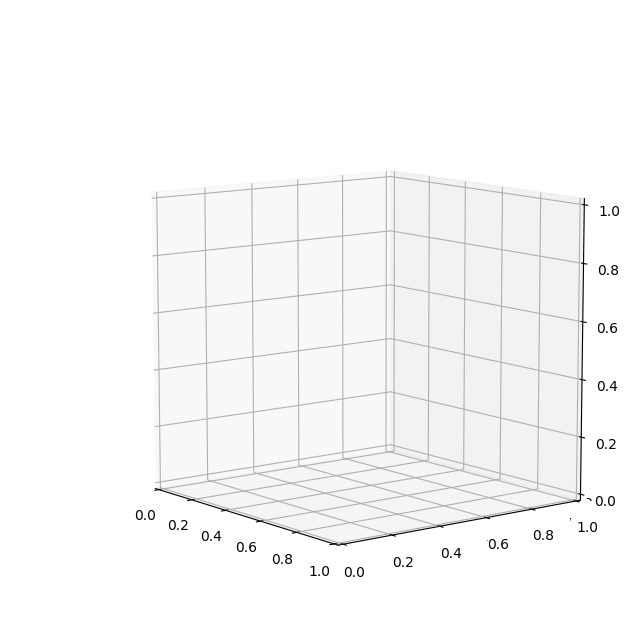

IndexError: index 2000750 is out of bounds for axis 0 with size 1998000

In [32]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = predictedX_long_sampleeh5.reshape((-1,19,3)) #Nan filled with VAE prediction
tw = sampleeh5.reshape((-1,19,3)) # Original
skipevery = 50


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sampleeh5.shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    plt.savefig("/home/shin/Prediction_long__Interpolated_vs_Interpolated/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

### Can I predict twice to re center wrong centered points?

# START FROM HERE

### What should I do to improve accuracy? I will do this again from the beginning

In [ ]:
dropdatacentered = np.load('dropdatacentered.npy')
sample = dropdatacentered[::5]

In [36]:
variational_ae = tf.keras.models.load_model('saved_model/four_layer_7')
print("Generate predictions for Interpolate centered data")
predictedX_sample = variational_ae.predict(sample)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(sample.reshape((-1,19,3))-predictedX_sample.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=3155199, minmax=(array([0.01632926, 0.0128643 , 0.01996318, 0.01425323, 0.01193692,
       0.00382567, 0.01036075, 0.0102427 , 0.00840081, 0.02514816,
       0.00807627, 0.00930826, 0.01464417, 0.01932116, 0.00472497,
       0.01308518, 0.01663074, 0.0092946 , 0.00844071]), array([192.60592076, 226.90119457, 252.44424698, 250.00987578,
       180.77603079, 188.75133606, 172.74530652, 237.30098364,
       238.98727953, 239.87147723, 188.55681296, 276.30431054,
       306.88361612, 243.30983347, 182.60822253, 210.26387682,
       215.80541451, 193.57046605, 219.39584347])), mean=array([5.03558012, 5.29175419, 4.45190649, 5.00411217, 2.9245024 ,
       3.4298622 , 3.65494928, 3.44371552, 3.89792029, 3.45766921,
       4.05683856, 2.96855009, 2.78557689, 5.22231335, 4.99925464,
       4.17126665, 4.28371414, 3.9321188 , 2.90191726]), variance=array([ 45.84530362,  36.54413758,  36.90039087,  48.49370737,
        22.16925424,  30.71573704,  29.58073969,  51.9290991 ,
   

In [40]:
#badX12 = np.where(np.mean(np.linalg.norm(X_good_filtered.reshape((-1,19,3))-predictedX_good_filtered.reshape((-1,19,3)), axis=2), axis=1) >= 35)
badX12 = np.where(np.any(np.linalg.norm(sample.reshape((-1,19,3))-predictedX_sample.reshape((-1,19,3)), axis=2) >= 15, axis=1)) #was 48
goodX12 = np.setdiff1d(np.arange(sample.shape[0]), badX12)
badXX12 = np.setdiff1d(np.arange(sample.shape[0]), goodX12)
sample_good = sample[goodX12,]
sample_bad = sample[badXX12,]
print('Shape of X = '+str(np.shape(sample))+'\n')
print('Shape of good X = '+str(np.shape(sample_good))+'\n')
print('Shape of bad X = '+str(np.shape(sample_bad))+'\n')

Shape of X = (3155199, 57)

Shape of good X = (2826999, 57)

Shape of bad X = (328200, 57)



<IPython.core.display.Javascript object>


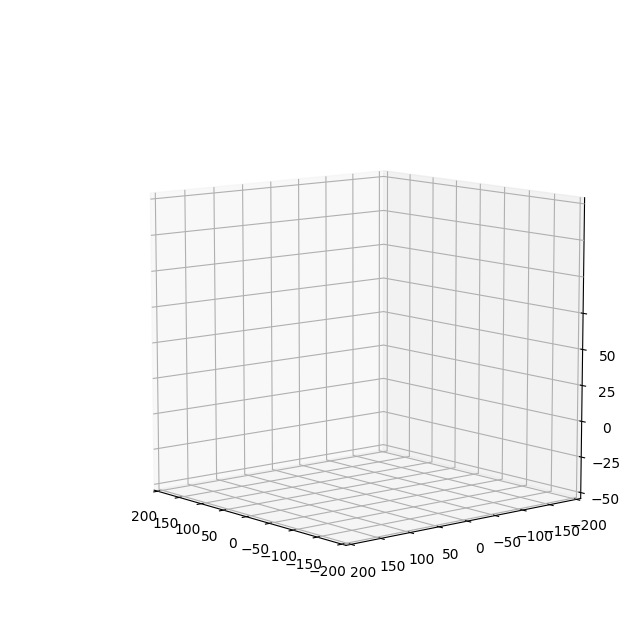

KeyboardInterrupt: 

In [50]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = sample_good[190000:].reshape((-1,19,3)) #
skipevery = 1


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sample_good.shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

In [52]:
sample_good_modelindex1 = sample_good[:18000]
sample_good_modelindex2 = sample_good[30000:150000]
sample_good_modelindex3 = sample_good[157000:190000]
sample_good_modelindex4 = sample_good[200000:215000]
sample_good_modelindex5 = sample_good[243000:315000]
sample_good_modelindex6 = sample_good[335000:515000]
sample_good_modelindex7 = sample_good[532000:550000]
sample_good_modelindex8 = sample_good[560000:580000]
sample_good_modelindex9 = sample_good[585000:890000]
sample_good_modelindex10 = sample_good[892000:910000]
sample_good_modelindex11 = sample_good[915000:970000]
sample_good_modelindex12 = sample_good[980000:1460000]
sample_good_modelindex13 = sample_good[1475000:1580000]
sample_good_modelindex14 = sample_good[1590000:1795000]
sample_good_modelindex15 = sample_good[1815000:1835000]
sample_good_modelindex16 = sample_good[1842000:1855000]
sample_good_modelindex17 = sample_good[1862000:1875000]
sample_good_modelindex18 = sample_good[1900000:2100000]
sample_good_modelindex19 = sample_good[2105000:2200000]
sample_good_modelindex20 = sample_good[2215000:2360000]
sample_good_modelindex21 = sample_good[2362000:2370000]
sample_good_modelindex22 = sample_good[2385000:2467000]
sample_good_modelindex23 = sample_good[2469000:2515000]
sample_good_modelindex24 = sample_good[2520000:2537000]
sample_good_modelindex25 = sample_good[2539000:2568000]
sample_good_modelindex26 = sample_good[2571000:2600000]
sample_good_modelindex27 = sample_good[2603000:2600000]
sample_good_modelindex28 = sample_good[2571000:2658000]
sample_good_modelindex29 = sample_good[2660000:2700000]
sample_good_modelindex30 = sample_good[2728000:2813000]
sample_good_modelindex31 = sample_good[2823000:]

sample_good_manuallyfiltered_1 = np.concatenate((sample_good_modelindex1, sample_good_modelindex2, sample_good_modelindex3, sample_good_modelindex4, sample_good_modelindex5, sample_good_modelindex6, sample_good_modelindex7, sample_good_modelindex8, sample_good_modelindex9, sample_good_modelindex10, sample_good_modelindex11, sample_good_modelindex12, sample_good_modelindex13, sample_good_modelindex14, sample_good_modelindex15, sample_good_modelindex16, sample_good_modelindex17, sample_good_modelindex18, sample_good_modelindex19, sample_good_modelindex20, sample_good_modelindex21, sample_good_modelindex22, sample_good_modelindex23, sample_good_modelindex24, sample_good_modelindex25, sample_good_modelindex26, sample_good_modelindex27, sample_good_modelindex28, sample_good_modelindex29, sample_good_modelindex30, sample_good_modelindex31), axis=0)

print('Shape of sample_good_manuallyfiltered data = '+str(np.shape(sample_good_manuallyfiltered_1))+'\n')

Shape of sample_good_manuallyfiltered data = (2436999, 57)



In [58]:
sample_good_modelindex11 = sample_good_manuallyfiltered_1[:320000]
sample_good_modelindex21 = sample_good_manuallyfiltered_1[360000:]

sample_good_manuallyfiltered_2 = np.concatenate((sample_good_modelindex11, sample_good_modelindex21), axis=0)

In [61]:
X_train = np.delete(sample_good_manuallyfiltered_2, list(range(0,len(sample_good_manuallyfiltered_2),7)), axis =0)
X_valid = sample_good_manuallyfiltered_2[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae1 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae1.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae1.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_8'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae1.fit(X_train, X_train, epochs=3000, verbose=1, batch_size=20000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


Training Set Shape = (2054570, 57)

Validation Set Shape = (342429, 57)

Epoch 1/3000
103/103 [==============================] - 4s 35ms/step - loss: 1477.2244 - val_loss: 431.4200

Epoch 00001: loss improved from inf to 1140.35938, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 2/3000
103/103 [==============================] - 3s 34ms/step - loss: 337.4540 - val_loss: 263.2811

Epoch 00002: loss improved from 1140.35938 to 297.25104, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 3/3000
103/103 [==============================] - 3s 31ms/step - loss: 260.4893 - val_loss: 251.5137

Epoch 00003: loss improved from 297.25104 to 257.94131, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 4/3000
103/103 [==============================] - 3s 31ms/step - loss: 245.0209 - val_loss: 215.6664

Epoch 


Epoch 00062: loss improved from 13.48585 to 13.14808, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 63/3000
103/103 [==============================] - 3s 32ms/step - loss: 12.9337 - val_loss: 13.5986

Epoch 00063: loss did not improve from 13.14808
Epoch 64/3000
103/103 [==============================] - 3s 34ms/step - loss: 12.9253 - val_loss: 12.6920

Epoch 00064: loss improved from 13.14808 to 12.62902, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 65/3000
103/103 [==============================] - 3s 34ms/step - loss: 12.5067 - val_loss: 12.5339

Epoch 00065: loss improved from 12.62902 to 12.61109, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 66/3000
103/103 [==============================] - 3s 33ms/step - loss: 12.2227 - val_loss: 13.6326

Epoch 00066: loss improved from 12.61

103/103 [==============================] - 3s 32ms/step - loss: 8.5637 - val_loss: 9.1951

Epoch 00100: loss improved from 8.66082 to 8.61422, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 101/3000
103/103 [==============================] - 3s 32ms/step - loss: 9.1748 - val_loss: 8.1551

Epoch 00101: loss did not improve from 8.61422
Epoch 102/3000
103/103 [==============================] - 4s 36ms/step - loss: 8.4309 - val_loss: 10.1697

Epoch 00102: loss did not improve from 8.61422
Epoch 103/3000
103/103 [==============================] - 4s 34ms/step - loss: 8.7259 - val_loss: 8.1092

Epoch 00103: loss improved from 8.61422 to 8.43894, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 104/3000
103/103 [==============================] - 3s 32ms/step - loss: 8.2759 - val_loss: 8.4001

Epoch 00104: loss improved from 8.43894 to 8.30598, saving model to sa


Epoch 00142: loss did not improve from 7.15821
Epoch 143/3000
103/103 [==============================] - 3s 34ms/step - loss: 8.9961 - val_loss: 6.8960

Epoch 00143: loss did not improve from 7.15821
Epoch 144/3000
103/103 [==============================] - 4s 34ms/step - loss: 6.9271 - val_loss: 7.0184

Epoch 00144: loss improved from 7.15821 to 7.01749, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 145/3000
103/103 [==============================] - 3s 33ms/step - loss: 6.9393 - val_loss: 6.9606

Epoch 00145: loss improved from 7.01749 to 6.97499, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 146/3000
103/103 [==============================] - 3s 33ms/step - loss: 7.0801 - val_loss: 10.0929

Epoch 00146: loss did not improve from 6.97499
Epoch 147/3000
103/103 [==============================] - 4s 34ms/step - loss: 8.6822 - val_loss: 6.8583

Epoch 0

103/103 [==============================] - 4s 36ms/step - loss: 5.8798 - val_loss: 5.8389

Epoch 00230: loss did not improve from 5.88743
Epoch 231/3000
103/103 [==============================] - 4s 35ms/step - loss: 5.8579 - val_loss: 5.8553

Epoch 00231: loss improved from 5.88743 to 5.87740, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 232/3000
103/103 [==============================] - 4s 37ms/step - loss: 5.8912 - val_loss: 5.7768

Epoch 00232: loss did not improve from 5.87740
Epoch 233/3000
103/103 [==============================] - 4s 35ms/step - loss: 5.8511 - val_loss: 5.9451

Epoch 00233: loss improved from 5.87740 to 5.87015, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 234/3000
103/103 [==============================] - 4s 36ms/step - loss: 5.9145 - val_loss: 6.2143

Epoch 00234: loss did not improve from 5.87015
Epoch 235/3000
103/103 [

103/103 [==============================] - 4s 37ms/step - loss: 5.9948 - val_loss: 5.6179

Epoch 00324: loss did not improve from 5.39855
Epoch 325/3000
103/103 [==============================] - 3s 34ms/step - loss: 6.1206 - val_loss: 5.6623

Epoch 00325: loss did not improve from 5.39855
Epoch 326/3000
103/103 [==============================] - 3s 34ms/step - loss: 5.8388 - val_loss: 5.7886

Epoch 00326: loss did not improve from 5.39855
Epoch 327/3000
103/103 [==============================] - 4s 37ms/step - loss: 5.7112 - val_loss: 5.7933

Epoch 00327: loss did not improve from 5.39855
Epoch 328/3000
103/103 [==============================] - 3s 34ms/step - loss: 5.7547 - val_loss: 5.5498

Epoch 00328: loss did not improve from 5.39855
Epoch 329/3000
103/103 [==============================] - 4s 34ms/step - loss: 5.6407 - val_loss: 5.5113

Epoch 00329: loss did not improve from 5.39855
Epoch 330/3000
103/103 [==============================] - 3s 33ms/step - loss: 5.7860 - val_loss:

103/103 [==============================] - 4s 35ms/step - loss: 5.1949 - val_loss: 5.3028

Epoch 00422: loss did not improve from 5.17846
Epoch 423/3000
103/103 [==============================] - 4s 36ms/step - loss: 5.2463 - val_loss: 5.1922

Epoch 00423: loss did not improve from 5.17846
Epoch 424/3000
103/103 [==============================] - 4s 35ms/step - loss: 5.1797 - val_loss: 5.2089

Epoch 00424: loss did not improve from 5.17846
Epoch 425/3000
103/103 [==============================] - 4s 35ms/step - loss: 5.2695 - val_loss: 5.1526

Epoch 00425: loss did not improve from 5.17846
Epoch 426/3000
103/103 [==============================] - 4s 40ms/step - loss: 5.1984 - val_loss: 5.0845

Epoch 00426: loss did not improve from 5.17846
Epoch 427/3000
103/103 [==============================] - 4s 38ms/step - loss: 5.1078 - val_loss: 5.4751

Epoch 00427: loss improved from 5.17846 to 5.14015, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four

103/103 [==============================] - 4s 38ms/step - loss: 5.4947 - val_loss: 5.0985

Epoch 00522: loss did not improve from 4.98277
Epoch 523/3000
103/103 [==============================] - 4s 38ms/step - loss: 5.2354 - val_loss: 5.2501

Epoch 00523: loss did not improve from 4.98277
Epoch 524/3000
103/103 [==============================] - 4s 37ms/step - loss: 5.1418 - val_loss: 5.0587

Epoch 00524: loss did not improve from 4.98277
Epoch 525/3000
103/103 [==============================] - 4s 36ms/step - loss: 5.0805 - val_loss: 5.0273

Epoch 00525: loss did not improve from 4.98277
Epoch 526/3000
103/103 [==============================] - 4s 38ms/step - loss: 5.1384 - val_loss: 5.1738

Epoch 00526: loss did not improve from 4.98277
Epoch 527/3000
103/103 [==============================] - 4s 36ms/step - loss: 5.1565 - val_loss: 5.0450

Epoch 00527: loss did not improve from 4.98277
Epoch 528/3000
103/103 [==============================] - 4s 38ms/step - loss: 5.0680 - val_loss:


Epoch 00572: loss did not improve from 4.93687
Epoch 573/3000
103/103 [==============================] - 4s 39ms/step - loss: 4.9443 - val_loss: 4.9539

Epoch 00573: loss did not improve from 4.93687
Epoch 574/3000
103/103 [==============================] - 4s 39ms/step - loss: 4.9531 - val_loss: 4.8973

Epoch 00574: loss did not improve from 4.93687
Epoch 575/3000
103/103 [==============================] - 4s 37ms/step - loss: 4.9069 - val_loss: 4.9354

Epoch 00575: loss improved from 4.93687 to 4.92103, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 576/3000
103/103 [==============================] - 4s 41ms/step - loss: 4.9678 - val_loss: 5.0376

Epoch 00576: loss did not improve from 4.92103
Epoch 577/3000
103/103 [==============================] - 4s 42ms/step - loss: 4.9451 - val_loss: 4.8410

Epoch 00577: loss did not improve from 4.92103
Epoch 578/3000
103/103 [==============================] - 4s 42ms/step - l

103/103 [==============================] - 4s 41ms/step - loss: 4.8113 - val_loss: 4.7988

Epoch 00621: loss did not improve from 4.78447
Epoch 622/3000
103/103 [==============================] - 4s 41ms/step - loss: 4.8072 - val_loss: 4.7451

Epoch 00622: loss did not improve from 4.78447
Epoch 623/3000
103/103 [==============================] - 4s 42ms/step - loss: 5.9027 - val_loss: 17.0725

Epoch 00623: loss did not improve from 4.78447
Epoch 624/3000
103/103 [==============================] - 4s 42ms/step - loss: 10.5950 - val_loss: 6.1155

Epoch 00624: loss did not improve from 4.78447
Epoch 625/3000
103/103 [==============================] - 4s 40ms/step - loss: 5.7100 - val_loss: 5.1060

Epoch 00625: loss did not improve from 4.78447
Epoch 626/3000
103/103 [==============================] - 4s 41ms/step - loss: 5.0776 - val_loss: 4.9577

Epoch 00626: loss did not improve from 4.78447
Epoch 627/3000
103/103 [==============================] - 4s 41ms/step - loss: 4.9481 - val_los

103/103 [==============================] - 4s 44ms/step - loss: 4.6536 - val_loss: 4.6592

Epoch 00719: loss improved from 4.67729 to 4.67287, saving model to saved_model/four_layer_8
INFO:tensorflow:Assets written to: saved_model/four_layer_8/assets
Epoch 720/3000
103/103 [==============================] - 4s 42ms/step - loss: 4.6616 - val_loss: 4.6299

Epoch 00720: loss did not improve from 4.67287
Epoch 721/3000
103/103 [==============================] - 4s 44ms/step - loss: 4.6785 - val_loss: 4.6200

Epoch 00721: loss did not improve from 4.67287
Epoch 722/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.6716 - val_loss: 4.6435

Epoch 00722: loss did not improve from 4.67287
Epoch 723/3000
103/103 [==============================] - 5s 45ms/step - loss: 4.6838 - val_loss: 4.6331

Epoch 00723: loss did not improve from 4.67287
Epoch 724/3000
103/103 [==============================] - 5s 44ms/step - loss: 4.6678 - val_loss: 4.6253

Epoch 00724: loss did not impro

103/103 [==============================] - 5s 46ms/step - loss: 4.9861 - val_loss: 4.8884

Epoch 00821: loss did not improve from 4.61184
Epoch 822/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.8751 - val_loss: 4.8508

Epoch 00822: loss did not improve from 4.61184
Epoch 823/3000
103/103 [==============================] - 4s 41ms/step - loss: 4.9028 - val_loss: 8.4581

Epoch 00823: loss did not improve from 4.61184
Epoch 824/3000
103/103 [==============================] - 4s 43ms/step - loss: 5.6673 - val_loss: 4.8088

Epoch 00824: loss did not improve from 4.61184
Epoch 825/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.9013 - val_loss: 4.8354

Epoch 00825: loss did not improve from 4.61184
Epoch 826/3000
103/103 [==============================] - 5s 44ms/step - loss: 4.9043 - val_loss: 4.8334

Epoch 00826: loss did not improve from 4.61184
Epoch 827/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.8196 - val_loss:


Epoch 00874: loss did not improve from 4.61184
Epoch 875/3000
103/103 [==============================] - 5s 47ms/step - loss: 4.6219 - val_loss: 4.7179

Epoch 00875: loss did not improve from 4.61184
Epoch 876/3000
103/103 [==============================] - 5s 44ms/step - loss: 4.7166 - val_loss: 4.6611

Epoch 00876: loss did not improve from 4.61184
Epoch 877/3000
103/103 [==============================] - 5s 45ms/step - loss: 4.6419 - val_loss: 4.7387

Epoch 00877: loss did not improve from 4.61184
Epoch 878/3000
103/103 [==============================] - 5s 44ms/step - loss: 4.6660 - val_loss: 4.8001

Epoch 00878: loss did not improve from 4.61184
Epoch 879/3000
103/103 [==============================] - 5s 44ms/step - loss: 4.8057 - val_loss: 4.6958

Epoch 00879: loss did not improve from 4.61184
Epoch 880/3000
103/103 [==============================] - 5s 45ms/step - loss: 4.7999 - val_loss: 4.6327

Epoch 00880: loss did not improve from 4.61184
Epoch 881/3000
103/103 [==========

103/103 [==============================] - 5s 44ms/step - loss: 5.1327 - val_loss: 4.9980

Epoch 00927: loss did not improve from 4.58046
Epoch 928/3000
103/103 [==============================] - 5s 45ms/step - loss: 5.4060 - val_loss: 4.9778

Epoch 00928: loss did not improve from 4.58046
Epoch 929/3000
103/103 [==============================] - 4s 43ms/step - loss: 5.1136 - val_loss: 5.0104

Epoch 00929: loss did not improve from 4.58046
Epoch 930/3000
103/103 [==============================] - 5s 44ms/step - loss: 4.9898 - val_loss: 5.0770

Epoch 00930: loss did not improve from 4.58046
Epoch 931/3000
103/103 [==============================] - 5s 44ms/step - loss: 5.0490 - val_loss: 4.9084

Epoch 00931: loss did not improve from 4.58046
Epoch 932/3000
103/103 [==============================] - 4s 43ms/step - loss: 5.1244 - val_loss: 5.5905

Epoch 00932: loss did not improve from 4.58046
Epoch 933/3000
103/103 [==============================] - 5s 44ms/step - loss: 5.1407 - val_loss:


Epoch 00980: loss did not improve from 4.58046
Epoch 981/3000
103/103 [==============================] - 5s 44ms/step - loss: 4.6396 - val_loss: 4.5951

Epoch 00981: loss did not improve from 4.58046
Epoch 982/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.6106 - val_loss: 4.6170

Epoch 00982: loss did not improve from 4.58046
Epoch 983/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.5882 - val_loss: 4.7061

Epoch 00983: loss did not improve from 4.58046
Epoch 984/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.6215 - val_loss: 4.5642

Epoch 00984: loss did not improve from 4.58046
Epoch 985/3000
103/103 [==============================] - 4s 43ms/step - loss: 4.5942 - val_loss: 4.8766

Epoch 00985: loss did not improve from 4.58046
Epoch 986/3000
103/103 [==============================] - 5s 47ms/step - loss: 4.6503 - val_loss: 4.6576

Epoch 00986: loss did not improve from 4.58046
Epoch 987/3000
103/103 [==========

103/103 [==============================] - 5s 47ms/step - loss: 5.3745 - val_loss: 5.0122

Epoch 01034: loss did not improve from 4.58046
Epoch 1035/3000
103/103 [==============================] - 5s 47ms/step - loss: 4.9932 - val_loss: 4.9275

Epoch 01035: loss did not improve from 4.58046
Epoch 1036/3000
103/103 [==============================] - 5s 45ms/step - loss: 5.0168 - val_loss: 4.8678

Epoch 01036: loss did not improve from 4.58046
Epoch 1037/3000
103/103 [==============================] - 5s 44ms/step - loss: 6.4057 - val_loss: 4.9603

Epoch 01037: loss did not improve from 4.58046
Epoch 1038/3000
103/103 [==============================] - 5s 48ms/step - loss: 4.9123 - val_loss: 4.9943

Epoch 01038: loss did not improve from 4.58046
Epoch 1039/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.8897 - val_loss: 5.3262

Epoch 01039: loss did not improve from 4.58046
Epoch 1040/3000
103/103 [==============================] - 5s 45ms/step - loss: 4.9623 - val


Epoch 01086: loss did not improve from 4.57665
Epoch 1087/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.6458 - val_loss: 4.5681

Epoch 01087: loss did not improve from 4.57665
Epoch 1088/3000
103/103 [==============================] - 5s 45ms/step - loss: 4.5913 - val_loss: 4.5609

Epoch 01088: loss did not improve from 4.57665
Epoch 1089/3000
103/103 [==============================] - 5s 48ms/step - loss: 4.5673 - val_loss: 4.7005

Epoch 01089: loss did not improve from 4.57665
Epoch 1090/3000
103/103 [==============================] - 5s 47ms/step - loss: 4.6215 - val_loss: 4.9299

Epoch 01090: loss did not improve from 4.57665
Epoch 1091/3000
103/103 [==============================] - 5s 47ms/step - loss: 4.6906 - val_loss: 4.7475

Epoch 01091: loss did not improve from 4.57665
Epoch 1092/3000
103/103 [==============================] - 5s 48ms/step - loss: 4.5871 - val_loss: 4.5549

Epoch 01092: loss did not improve from 4.57665
Epoch 1093/3000
103/103 [===

103/103 [==============================] - 5s 46ms/step - loss: 5.7785 - val_loss: 5.7390

Epoch 01137: loss did not improve from 4.52578
Epoch 1138/3000
103/103 [==============================] - 5s 45ms/step - loss: 5.7158 - val_loss: 6.9163

Epoch 01138: loss did not improve from 4.52578
Epoch 1139/3000
103/103 [==============================] - 5s 46ms/step - loss: 5.5995 - val_loss: 5.2974

Epoch 01139: loss did not improve from 4.52578
Epoch 1140/3000
103/103 [==============================] - 5s 49ms/step - loss: 5.5038 - val_loss: 5.1494

Epoch 01140: loss did not improve from 4.52578
Epoch 1141/3000
103/103 [==============================] - 5s 47ms/step - loss: 5.5394 - val_loss: 5.4288

Epoch 01141: loss did not improve from 4.52578
Epoch 1142/3000
103/103 [==============================] - 5s 47ms/step - loss: 5.2502 - val_loss: 5.4929

Epoch 01142: loss did not improve from 4.52578
Epoch 1143/3000
103/103 [==============================] - 5s 48ms/step - loss: 5.2964 - val


Epoch 01242: loss did not improve from 4.49323
Epoch 1243/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.5581 - val_loss: 4.4430

Epoch 01243: loss did not improve from 4.49323
Epoch 1244/3000
103/103 [==============================] - 5s 47ms/step - loss: 4.5140 - val_loss: 4.4444

Epoch 01244: loss did not improve from 4.49323
Epoch 1245/3000
103/103 [==============================] - 5s 49ms/step - loss: 12.6825 - val_loss: 21.6307

Epoch 01245: loss did not improve from 4.49323
Epoch 1246/3000
103/103 [==============================] - 5s 49ms/step - loss: 16.1092 - val_loss: 9.5722

Epoch 01246: loss did not improve from 4.49323
Epoch 1247/3000
103/103 [==============================] - 5s 50ms/step - loss: 8.7577 - val_loss: 11.0919

Epoch 01247: loss did not improve from 4.49323
Epoch 1248/3000
103/103 [==============================] - 5s 45ms/step - loss: 7.4407 - val_loss: 6.0344

Epoch 01248: loss did not improve from 4.49323
Epoch 1249/3000
103/103 

103/103 [==============================] - 5s 49ms/step - loss: 4.5137 - val_loss: 4.5435

Epoch 01296: loss did not improve from 4.49323
Epoch 1297/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.5359 - val_loss: 4.6069

Epoch 01297: loss did not improve from 4.49323
Epoch 1298/3000
103/103 [==============================] - 5s 46ms/step - loss: 4.5413 - val_loss: 4.5094

Epoch 01298: loss did not improve from 4.49323
Epoch 1299/3000
103/103 [==============================] - 6s 55ms/step - loss: 4.5554 - val_loss: 4.4711

Epoch 01299: loss did not improve from 4.49323
Epoch 1300/3000
103/103 [==============================] - 5s 53ms/step - loss: 4.5014 - val_loss: 4.4751

Epoch 01300: loss did not improve from 4.49323
Epoch 1301/3000
103/103 [==============================] - 5s 48ms/step - loss: 4.5063 - val_loss: 4.5569

Epoch 01301: loss did not improve from 4.49323
Epoch 1302/3000
103/103 [==============================] - 5s 49ms/step - loss: 4.4988 - val

103/103 [==============================] - 5s 53ms/step - loss: 4.5744 - val_loss: 4.4672

Epoch 01399: loss did not improve from 4.46195
Epoch 1400/3000
103/103 [==============================] - 6s 57ms/step - loss: 4.5189 - val_loss: 4.6532

Epoch 01400: loss did not improve from 4.46195
Epoch 1401/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.5252 - val_loss: 4.4826

Epoch 01401: loss did not improve from 4.46195
Epoch 1402/3000
103/103 [==============================] - 6s 55ms/step - loss: 4.5160 - val_loss: 4.4702

Epoch 01402: loss did not improve from 4.46195
Epoch 1403/3000
103/103 [==============================] - 6s 57ms/step - loss: 4.5550 - val_loss: 4.6544

Epoch 01403: loss did not improve from 4.46195
Epoch 1404/3000
103/103 [==============================] - 5s 53ms/step - loss: 4.5376 - val_loss: 4.5018

Epoch 01404: loss did not improve from 4.46195
Epoch 1405/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.5112 - val

103/103 [==============================] - 6s 55ms/step - loss: 4.4268 - val_loss: 4.4361

Epoch 01451: loss did not improve from 4.43169
Epoch 1452/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.4275 - val_loss: 4.3973

Epoch 01452: loss did not improve from 4.43169
Epoch 1453/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.4607 - val_loss: 4.3927

Epoch 01453: loss did not improve from 4.43169
Epoch 1454/3000
103/103 [==============================] - 6s 53ms/step - loss: 4.4384 - val_loss: 4.4555

Epoch 01454: loss did not improve from 4.43169
Epoch 1455/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.4311 - val_loss: 4.7044

Epoch 01455: loss did not improve from 4.43169
Epoch 1456/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.4689 - val_loss: 4.3982

Epoch 01456: loss did not improve from 4.43169
Epoch 1457/3000
103/103 [==============================] - 6s 56ms/step - loss: 4.4277 - val


Epoch 01500: loss did not improve from 4.38550
Epoch 1501/3000
103/103 [==============================] - 5s 53ms/step - loss: 5.2702 - val_loss: 5.0396

Epoch 01501: loss did not improve from 4.38550
Epoch 1502/3000
103/103 [==============================] - 5s 52ms/step - loss: 5.2964 - val_loss: 5.3921

Epoch 01502: loss did not improve from 4.38550
Epoch 1503/3000
103/103 [==============================] - 6s 54ms/step - loss: 5.0362 - val_loss: 4.8781

Epoch 01503: loss did not improve from 4.38550
Epoch 1504/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.9332 - val_loss: 4.8340

Epoch 01504: loss did not improve from 4.38550
Epoch 1505/3000
103/103 [==============================] - 5s 53ms/step - loss: 4.9196 - val_loss: 4.8879

Epoch 01505: loss did not improve from 4.38550
Epoch 1506/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.8570 - val_loss: 4.7702

Epoch 01506: loss did not improve from 4.38550
Epoch 1507/3000
103/103 [===

103/103 [==============================] - 5s 52ms/step - loss: 4.6292 - val_loss: 4.8854

Epoch 01554: loss did not improve from 4.38550
Epoch 1555/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.5743 - val_loss: 4.6162

Epoch 01555: loss did not improve from 4.38550
Epoch 1556/3000
103/103 [==============================] - 5s 53ms/step - loss: 4.5965 - val_loss: 4.6991

Epoch 01556: loss did not improve from 4.38550
Epoch 1557/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.6220 - val_loss: 4.5018

Epoch 01557: loss did not improve from 4.38550
Epoch 1558/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.5091 - val_loss: 4.5460

Epoch 01558: loss did not improve from 4.38550
Epoch 1559/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.5432 - val_loss: 4.5158

Epoch 01559: loss did not improve from 4.38550
Epoch 1560/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.5404 - val

103/103 [==============================] - 5s 51ms/step - loss: 4.3438 - val_loss: 4.3386

Epoch 01657: loss did not improve from 4.33339
Epoch 1658/3000
103/103 [==============================] - 5s 49ms/step - loss: 4.3631 - val_loss: 4.3765

Epoch 01658: loss did not improve from 4.33339
Epoch 1659/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.3626 - val_loss: 4.3361

Epoch 01659: loss did not improve from 4.33339
Epoch 1660/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.3603 - val_loss: 4.4067

Epoch 01660: loss did not improve from 4.33339
Epoch 1661/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.3546 - val_loss: 4.5808

Epoch 01661: loss did not improve from 4.33339
Epoch 1662/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.4070 - val_loss: 4.3431

Epoch 01662: loss did not improve from 4.33339
Epoch 1663/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.3498 - val

103/103 [==============================] - 5s 52ms/step - loss: 4.4575 - val_loss: 4.4882

Epoch 01763: loss did not improve from 4.33339
Epoch 1764/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.4461 - val_loss: 4.5571

Epoch 01764: loss did not improve from 4.33339
Epoch 1765/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.4661 - val_loss: 4.4431

Epoch 01765: loss did not improve from 4.33339
Epoch 1766/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.4429 - val_loss: 4.4088

Epoch 01766: loss did not improve from 4.33339
Epoch 1767/3000
103/103 [==============================] - 5s 53ms/step - loss: 4.4421 - val_loss: 4.4824

Epoch 01767: loss did not improve from 4.33339
Epoch 1768/3000
103/103 [==============================] - 6s 55ms/step - loss: 4.4466 - val_loss: 4.3938

Epoch 01768: loss did not improve from 4.33339
Epoch 1769/3000
103/103 [==============================] - 5s 53ms/step - loss: 4.4256 - val

103/103 [==============================] - 5s 50ms/step - loss: 4.5722 - val_loss: 4.3338

Epoch 01869: loss did not improve from 4.33339
Epoch 1870/3000
103/103 [==============================] - 5s 52ms/step - loss: 4.3303 - val_loss: 4.3414

Epoch 01870: loss did not improve from 4.33339
Epoch 1871/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.3462 - val_loss: 4.3942

Epoch 01871: loss did not improve from 4.33339
Epoch 1872/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.3621 - val_loss: 4.3444

Epoch 01872: loss did not improve from 4.33339
Epoch 1873/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.3690 - val_loss: 4.3456

Epoch 01873: loss did not improve from 4.33339
Epoch 1874/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.3872 - val_loss: 4.3321

Epoch 01874: loss did not improve from 4.33339
Epoch 1875/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.3794 - val

103/103 [==============================] - 5s 53ms/step - loss: 4.2862 - val_loss: 4.3670

Epoch 01971: loss did not improve from 4.26772
Epoch 1972/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.2891 - val_loss: 4.2678

Epoch 01972: loss did not improve from 4.26772
Epoch 1973/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.2849 - val_loss: 4.3139

Epoch 01973: loss did not improve from 4.26772
Epoch 1974/3000
103/103 [==============================] - 6s 55ms/step - loss: 4.2837 - val_loss: 4.4240

Epoch 01974: loss did not improve from 4.26772
Epoch 1975/3000
103/103 [==============================] - 6s 55ms/step - loss: 4.2975 - val_loss: 4.2760

Epoch 01975: loss did not improve from 4.26772
Epoch 1976/3000
103/103 [==============================] - 5s 51ms/step - loss: 4.2858 - val_loss: 4.2628

Epoch 01976: loss did not improve from 4.26772
Epoch 1977/3000
103/103 [==============================] - 6s 54ms/step - loss: 4.2886 - val

103/103 [==============================] - 5s 52ms/step - loss: 7.9701 - val_loss: 10.4973

Epoch 02022: loss did not improve from 4.23304
Epoch 2023/3000
103/103 [==============================] - 5s 51ms/step - loss: 8.4625 - val_loss: 7.7582

Epoch 02023: loss did not improve from 4.23304
Epoch 2024/3000
103/103 [==============================] - 5s 51ms/step - loss: 6.9766 - val_loss: 6.6500

Epoch 02024: loss did not improve from 4.23304
Epoch 2025/3000
103/103 [==============================] - 5s 52ms/step - loss: 6.6607 - val_loss: 6.3493

Epoch 02025: loss did not improve from 4.23304
Epoch 2026/3000
103/103 [==============================] - 5s 51ms/step - loss: 6.4483 - val_loss: 6.1676

Epoch 02026: loss did not improve from 4.23304
Epoch 2027/3000
103/103 [==============================] - 5s 50ms/step - loss: 6.2407 - val_loss: 5.9625

Epoch 02027: loss did not improve from 4.23304
Epoch 2028/3000
103/103 [==============================] - 5s 50ms/step - loss: 6.0090 - va

103/103 [==============================] - 5s 50ms/step - loss: 4.3348 - val_loss: 4.2679

Epoch 02128: loss did not improve from 4.23304
Epoch 2129/3000
103/103 [==============================] - 5s 48ms/step - loss: 4.2959 - val_loss: 4.4319

Epoch 02129: loss did not improve from 4.23304
Epoch 2130/3000
103/103 [==============================] - 5s 53ms/step - loss: 4.3324 - val_loss: 4.2748

Epoch 02130: loss did not improve from 4.23304
Epoch 2131/3000
103/103 [==============================] - 6s 54ms/step - loss: 4.3023 - val_loss: 4.2829

Epoch 02131: loss did not improve from 4.23304
Epoch 2132/3000
103/103 [==============================] - 6s 56ms/step - loss: 4.2744 - val_loss: 4.4187

Epoch 02132: loss did not improve from 4.23304
Epoch 2133/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.3415 - val_loss: 4.3774

Epoch 02133: loss did not improve from 4.23304
Epoch 2134/3000
103/103 [==============================] - 5s 50ms/step - loss: 4.3313 - val

103/103 [==============================] - 5s 52ms/step - loss: 4.5745 - val_loss: 4.5013

Epoch 02234: loss did not improve from 4.23304
Epoch 2235/3000
103/103 [==============================] - 6s 55ms/step - loss: 4.5362 - val_loss: 4.4956

Epoch 02235: loss did not improve from 4.23304
Epoch 2236/3000
103/103 [==============================] - 7s 64ms/step - loss: 4.5131 - val_loss: 4.4541

Epoch 02236: loss did not improve from 4.23304
Epoch 2237/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.4980 - val_loss: 4.4079

Epoch 02237: loss did not improve from 4.23304
Epoch 2238/3000
103/103 [==============================] - 7s 64ms/step - loss: 4.4713 - val_loss: 4.4009

Epoch 02238: loss did not improve from 4.23304
Epoch 2239/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.4261 - val_loss: 4.3704

Epoch 02239: loss did not improve from 4.23304
Epoch 2240/3000
103/103 [==============================] - 6s 60ms/step - loss: 4.4352 - val

103/103 [==============================] - 6s 61ms/step - loss: 4.4397 - val_loss: 4.4970

Epoch 02340: loss did not improve from 4.23304
Epoch 2341/3000
103/103 [==============================] - 7s 63ms/step - loss: 4.4432 - val_loss: 4.4127

Epoch 02341: loss did not improve from 4.23304
Epoch 2342/3000
103/103 [==============================] - 7s 64ms/step - loss: 4.4583 - val_loss: 4.3884

Epoch 02342: loss did not improve from 4.23304
Epoch 2343/3000
103/103 [==============================] - 6s 63ms/step - loss: 4.4271 - val_loss: 4.5386

Epoch 02343: loss did not improve from 4.23304
Epoch 2344/3000
103/103 [==============================] - 6s 62ms/step - loss: 4.4249 - val_loss: 4.4407

Epoch 02344: loss did not improve from 4.23304
Epoch 2345/3000
103/103 [==============================] - 6s 60ms/step - loss: 4.4177 - val_loss: 4.4153

Epoch 02345: loss did not improve from 4.23304
Epoch 2346/3000
103/103 [==============================] - 6s 63ms/step - loss: 4.4126 - val

103/103 [==============================] - 6s 57ms/step - loss: 4.3172 - val_loss: 4.2487

Epoch 02446: loss did not improve from 4.23304
Epoch 2447/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.2836 - val_loss: 4.3990

Epoch 02447: loss did not improve from 4.23304
Epoch 2448/3000
103/103 [==============================] - 6s 62ms/step - loss: 4.3210 - val_loss: 4.2889

Epoch 02448: loss did not improve from 4.23304
Epoch 2449/3000
103/103 [==============================] - 6s 59ms/step - loss: 4.2678 - val_loss: 4.2316

Epoch 02449: loss did not improve from 4.23304
Epoch 2450/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.2702 - val_loss: 4.3000

Epoch 02450: loss did not improve from 4.23304
Epoch 2451/3000
103/103 [==============================] - 6s 60ms/step - loss: 4.2803 - val_loss: 4.2288

Epoch 02451: loss did not improve from 4.23304
Epoch 2452/3000
103/103 [==============================] - 6s 59ms/step - loss: 4.2948 - val

103/103 [==============================] - 7s 64ms/step - loss: 4.5725 - val_loss: 4.3284

Epoch 02551: loss did not improve from 4.22804
Epoch 2552/3000
103/103 [==============================] - 6s 63ms/step - loss: 4.3263 - val_loss: 4.3059

Epoch 02552: loss did not improve from 4.22804
Epoch 2553/3000
103/103 [==============================] - 6s 59ms/step - loss: 4.3167 - val_loss: 4.6060

Epoch 02553: loss did not improve from 4.22804
Epoch 2554/3000
103/103 [==============================] - 7s 65ms/step - loss: 4.4132 - val_loss: 4.3974

Epoch 02554: loss did not improve from 4.22804
Epoch 2555/3000
103/103 [==============================] - 6s 60ms/step - loss: 4.3200 - val_loss: 4.2967

Epoch 02555: loss did not improve from 4.22804
Epoch 2556/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.3215 - val_loss: 4.2923

Epoch 02556: loss did not improve from 4.22804
Epoch 2557/3000
103/103 [==============================] - 7s 67ms/step - loss: 4.3463 - val

103/103 [==============================] - 6s 58ms/step - loss: 4.3369 - val_loss: 4.3489

Epoch 02657: loss did not improve from 4.22804
Epoch 2658/3000
103/103 [==============================] - 7s 64ms/step - loss: 4.3896 - val_loss: 4.3092

Epoch 02658: loss did not improve from 4.22804
Epoch 2659/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.3365 - val_loss: 4.4137

Epoch 02659: loss did not improve from 4.22804
Epoch 2660/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.4498 - val_loss: 4.3334

Epoch 02660: loss did not improve from 4.22804
Epoch 2661/3000
103/103 [==============================] - 6s 62ms/step - loss: 4.3555 - val_loss: 4.5430

Epoch 02661: loss did not improve from 4.22804
Epoch 2662/3000
103/103 [==============================] - 6s 60ms/step - loss: 4.3913 - val_loss: 4.4891

Epoch 02662: loss did not improve from 4.22804
Epoch 2663/3000
103/103 [==============================] - 6s 61ms/step - loss: 4.3456 - val

KeyboardInterrupt: 

In [62]:
predictedX_manual_filter_sampleeh5 = variational_ae1.predict(sampleeh5)

In [ ]:
eh5 = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
sampleeh5 = eh5[::10]
predictedX_long_sampleeh5 = variational_ae1.predict(sampleeh5)

<IPython.core.display.Javascript object>


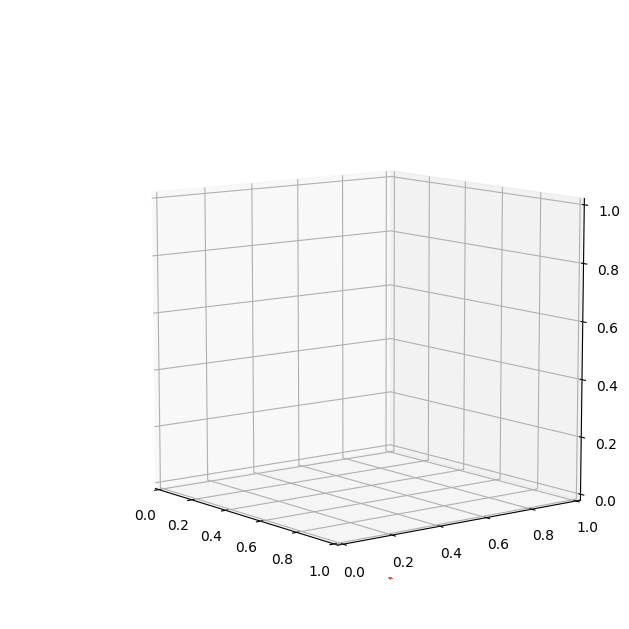

IndexError: index 2000750 is out of bounds for axis 0 with size 1998000

In [64]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = predictedX_manual_filter_sampleeh5.reshape((-1,19,3)) #Nan filled with VAE prediction
tw = sampleeh5.reshape((-1,19,3)) # Original
skipevery = 50


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sampleeh5.shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    plt.savefig("/home/shin/Prediction_Manual_Filter_Interpolated/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

# Dropout Layer?

In [ ]:
X_train = np.delete(sample_good_manuallyfiltered_2, list(range(0,len(sample_good_manuallyfiltered_2),7)), axis =0)
X_valid = sample_good_manuallyfiltered_2[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae2 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae2.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae2.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_9'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae2.fit(X_train, X_train, epochs=3000, verbose=1, batch_size=20000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


In [103]:
X_train = np.delete(sample_good, list(range(0,len(sample_good),7)), axis =0)
X_valid = sample_good[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae6 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae6.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae6.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_3'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae6.fit(X_train, X_train, epochs=3000, verbose=1, batch_size=7000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


Training Set Shape = (2584589, 57)

Validation Set Shape = (430765, 57)

Epoch 1/3000
370/370 [==============================] - 8s 19ms/step - loss: 938.7829 - val_loss: 265.7366

Epoch 00001: loss improved from inf to 538.28802, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 2/3000
370/370 [==============================] - 6s 18ms/step - loss: 220.8692 - val_loss: 117.5747

Epoch 00002: loss improved from 538.28802 to 179.49307, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 3/3000
370/370 [==============================] - 6s 17ms/step - loss: 105.2232 - val_loss: 84.8661

Epoch 00003: loss improved from 179.49307 to 96.48324, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 4/3000
370/370 [==============================] - 6s 17ms/step - loss: 81.4175 - val_loss: 63.0709

Epoch 00004: 


Epoch 00069: loss improved from 9.10861 to 9.05881, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 70/3000
370/370 [==============================] - 6s 17ms/step - loss: 8.9610 - val_loss: 8.7319

Epoch 00070: loss improved from 9.05881 to 8.97877, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 71/3000
370/370 [==============================] - 7s 18ms/step - loss: 8.7990 - val_loss: 8.4195

Epoch 00071: loss improved from 8.97877 to 8.82525, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 72/3000
370/370 [==============================] - 6s 17ms/step - loss: 8.7310 - val_loss: 8.4832

Epoch 00072: loss improved from 8.82525 to 8.71018, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 73/3000
370/370 [=====================

INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 111/3000
370/370 [==============================] - 6s 17ms/step - loss: 8.0028 - val_loss: 7.5083

Epoch 00111: loss did not improve from 7.77277
Epoch 112/3000
370/370 [==============================] - 6s 17ms/step - loss: 7.6932 - val_loss: 7.7397

Epoch 00112: loss improved from 7.77277 to 7.69976, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 113/3000
370/370 [==============================] - 6s 16ms/step - loss: 7.6506 - val_loss: 7.5186

Epoch 00113: loss improved from 7.69976 to 7.64978, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 114/3000
370/370 [==============================] - 6s 17ms/step - loss: 7.6199 - val_loss: 7.6654

Epoch 00114: loss improved from 7.64978 to 7.61450, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/fo

370/370 [==============================] - 7s 18ms/step - loss: 7.3937 - val_loss: 56.1709

Epoch 00199: loss did not improve from 6.72494
Epoch 200/3000
370/370 [==============================] - 7s 18ms/step - loss: 25.1944 - val_loss: 9.9650

Epoch 00200: loss did not improve from 6.72494
Epoch 201/3000
370/370 [==============================] - 7s 18ms/step - loss: 8.9485 - val_loss: 8.8433

Epoch 00201: loss did not improve from 6.72494
Epoch 202/3000
370/370 [==============================] - 7s 18ms/step - loss: 7.8267 - val_loss: 7.4209

Epoch 00202: loss did not improve from 6.72494
Epoch 203/3000
370/370 [==============================] - 6s 18ms/step - loss: 7.3732 - val_loss: 7.1976

Epoch 00203: loss did not improve from 6.72494
Epoch 204/3000
370/370 [==============================] - 7s 18ms/step - loss: 7.2515 - val_loss: 7.1469

Epoch 00204: loss did not improve from 6.72494
Epoch 205/3000
370/370 [==============================] - 7s 19ms/step - loss: 7.1012 - val_los

370/370 [==============================] - 6s 17ms/step - loss: 31.2779 - val_loss: 29.3554

Epoch 00273: loss did not improve from 6.24956
Epoch 274/3000
370/370 [==============================] - 6s 17ms/step - loss: 19.2506 - val_loss: 13.1864

Epoch 00274: loss did not improve from 6.24956
Epoch 275/3000
370/370 [==============================] - 6s 17ms/step - loss: 13.3066 - val_loss: 11.5284

Epoch 00275: loss did not improve from 6.24956
Epoch 276/3000
370/370 [==============================] - 6s 17ms/step - loss: 11.4883 - val_loss: 12.7715

Epoch 00276: loss did not improve from 6.24956
Epoch 277/3000
370/370 [==============================] - 7s 18ms/step - loss: 10.8321 - val_loss: 9.4610

Epoch 00277: loss did not improve from 6.24956
Epoch 278/3000
370/370 [==============================] - 7s 18ms/step - loss: 9.7879 - val_loss: 9.3630

Epoch 00278: loss did not improve from 6.24956
Epoch 279/3000
370/370 [==============================] - 7s 18ms/step - loss: 9.3197 - 

370/370 [==============================] - 7s 19ms/step - loss: 6.0618 - val_loss: 6.0094

Epoch 00361: loss did not improve from 6.04187
Epoch 362/3000
370/370 [==============================] - 7s 18ms/step - loss: 6.0612 - val_loss: 6.0194

Epoch 00362: loss did not improve from 6.04187
Epoch 363/3000
370/370 [==============================] - 7s 18ms/step - loss: 14.3419 - val_loss: 10.9599

Epoch 00363: loss did not improve from 6.04187
Epoch 364/3000
370/370 [==============================] - 7s 18ms/step - loss: 9.9171 - val_loss: 8.2997

Epoch 00364: loss did not improve from 6.04187
Epoch 365/3000
370/370 [==============================] - 7s 19ms/step - loss: 7.5925 - val_loss: 6.9806

Epoch 00365: loss did not improve from 6.04187
Epoch 366/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.8667 - val_loss: 6.5554

Epoch 00366: loss did not improve from 6.04187
Epoch 367/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.5869 - val_los

INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 409/3000
370/370 [==============================] - 7s 20ms/step - loss: 5.9755 - val_loss: 5.9707

Epoch 00409: loss did not improve from 5.95977
Epoch 410/3000
370/370 [==============================] - 7s 18ms/step - loss: 5.9613 - val_loss: 6.0056

Epoch 00410: loss improved from 5.95977 to 5.95957, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 411/3000
370/370 [==============================] - 7s 20ms/step - loss: 5.9674 - val_loss: 5.9147

Epoch 00411: loss improved from 5.95957 to 5.95947, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 412/3000
370/370 [==============================] - 7s 20ms/step - loss: 5.9527 - val_loss: 5.9079

Epoch 00412: loss improved from 5.95947 to 5.95244, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/fo

370/370 [==============================] - 7s 20ms/step - loss: 5.8918 - val_loss: 5.8514

Epoch 00448: loss did not improve from 5.87457
Epoch 449/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8835 - val_loss: 5.9007

Epoch 00449: loss did not improve from 5.87457
Epoch 450/3000
370/370 [==============================] - 7s 20ms/step - loss: 5.8711 - val_loss: 5.8762

Epoch 00450: loss improved from 5.87457 to 5.87166, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 451/3000
370/370 [==============================] - 7s 20ms/step - loss: 5.8649 - val_loss: 5.8503

Epoch 00451: loss improved from 5.87166 to 5.87149, saving model to saved_model/four_layer_3
INFO:tensorflow:Assets written to: saved_model/four_layer_3/assets
Epoch 452/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8563 - val_loss: 5.8970

Epoch 00452: loss improved from 5.87149 to 5.86448, saving model to sav


Epoch 00492: loss did not improve from 5.79752
Epoch 493/3000
370/370 [==============================] - 8s 21ms/step - loss: 9.0045 - val_loss: 8.2916

Epoch 00493: loss did not improve from 5.79752
Epoch 494/3000
370/370 [==============================] - 7s 20ms/step - loss: 8.7536 - val_loss: 8.6224

Epoch 00494: loss did not improve from 5.79752
Epoch 495/3000
370/370 [==============================] - 8s 21ms/step - loss: 8.0274 - val_loss: 8.7602

Epoch 00495: loss did not improve from 5.79752
Epoch 496/3000
370/370 [==============================] - 8s 21ms/step - loss: 7.2987 - val_loss: 6.7942

Epoch 00496: loss did not improve from 5.79752
Epoch 497/3000
370/370 [==============================] - 7s 20ms/step - loss: 7.1325 - val_loss: 6.5828

Epoch 00497: loss did not improve from 5.79752
Epoch 498/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.7976 - val_loss: 6.6191

Epoch 00498: loss did not improve from 5.79752
Epoch 499/3000
370/370 [==========


Epoch 00599: loss did not improve from 5.79752
Epoch 600/3000
370/370 [==============================] - 8s 21ms/step - loss: 6.7646 - val_loss: 6.6587

Epoch 00600: loss did not improve from 5.79752
Epoch 601/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.5999 - val_loss: 6.3569

Epoch 00601: loss did not improve from 5.79752
Epoch 602/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.4784 - val_loss: 6.4224

Epoch 00602: loss did not improve from 5.79752
Epoch 603/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.3923 - val_loss: 6.4301

Epoch 00603: loss did not improve from 5.79752
Epoch 604/3000
370/370 [==============================] - 8s 20ms/step - loss: 6.3693 - val_loss: 6.3473

Epoch 00604: loss did not improve from 5.79752
Epoch 605/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.2918 - val_loss: 6.1775

Epoch 00605: loss did not improve from 5.79752
Epoch 606/3000
370/370 [==========

370/370 [==============================] - 7s 20ms/step - loss: 8.7739 - val_loss: 7.7483

Epoch 00706: loss did not improve from 5.79752
Epoch 707/3000
370/370 [==============================] - 7s 19ms/step - loss: 7.8181 - val_loss: 7.1226

Epoch 00707: loss did not improve from 5.79752
Epoch 708/3000
370/370 [==============================] - 7s 19ms/step - loss: 7.3088 - val_loss: 6.8835

Epoch 00708: loss did not improve from 5.79752
Epoch 709/3000
370/370 [==============================] - 7s 19ms/step - loss: 7.0448 - val_loss: 6.6372

Epoch 00709: loss did not improve from 5.79752
Epoch 710/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.7283 - val_loss: 6.5090

Epoch 00710: loss did not improve from 5.79752
Epoch 711/3000
370/370 [==============================] - 7s 18ms/step - loss: 6.6233 - val_loss: 6.3414

Epoch 00711: loss did not improve from 5.79752
Epoch 712/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.4070 - val_loss:


Epoch 00759: loss did not improve from 5.79752
Epoch 760/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8820 - val_loss: 5.8637

Epoch 00760: loss did not improve from 5.79752
Epoch 761/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8713 - val_loss: 5.8225

Epoch 00761: loss did not improve from 5.79752
Epoch 762/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8556 - val_loss: 5.8513

Epoch 00762: loss did not improve from 5.79752
Epoch 763/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8794 - val_loss: 6.6385

Epoch 00763: loss did not improve from 5.79752
Epoch 764/3000
370/370 [==============================] - 7s 18ms/step - loss: 95.7735 - val_loss: 20.2426

Epoch 00764: loss did not improve from 5.79752
Epoch 765/3000
370/370 [==============================] - 7s 18ms/step - loss: 18.8095 - val_loss: 16.8988

Epoch 00765: loss did not improve from 5.79752
Epoch 766/3000
370/370 [======

370/370 [==============================] - 7s 18ms/step - loss: 6.2531 - val_loss: 6.0782

Epoch 00813: loss did not improve from 5.79752
Epoch 814/3000
370/370 [==============================] - 7s 18ms/step - loss: 6.1866 - val_loss: 6.0769

Epoch 00814: loss did not improve from 5.79752
Epoch 815/3000
370/370 [==============================] - 7s 18ms/step - loss: 6.2012 - val_loss: 6.2922

Epoch 00815: loss did not improve from 5.79752
Epoch 816/3000
370/370 [==============================] - 8s 20ms/step - loss: 6.1462 - val_loss: 6.0777

Epoch 00816: loss did not improve from 5.79752
Epoch 817/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.1115 - val_loss: 6.1237

Epoch 00817: loss did not improve from 5.79752
Epoch 818/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.1016 - val_loss: 5.9799

Epoch 00818: loss did not improve from 5.79752
Epoch 819/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.0485 - val_loss:


Epoch 00866: loss did not improve from 5.79752
Epoch 867/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8837 - val_loss: 5.8653

Epoch 00867: loss did not improve from 5.79752
Epoch 868/3000
370/370 [==============================] - 7s 18ms/step - loss: 5.8696 - val_loss: 5.9979

Epoch 00868: loss did not improve from 5.79752
Epoch 869/3000
370/370 [==============================] - 7s 18ms/step - loss: 5.8701 - val_loss: 6.0126

Epoch 00869: loss did not improve from 5.79752
Epoch 870/3000
370/370 [==============================] - 7s 18ms/step - loss: 5.8660 - val_loss: 5.7696

Epoch 00870: loss did not improve from 5.79752
Epoch 871/3000
370/370 [==============================] - 7s 19ms/step - loss: 5.8010 - val_loss: 6.2704

Epoch 00871: loss did not improve from 5.79752
Epoch 872/3000
370/370 [==============================] - 7s 18ms/step - loss: 97.4457 - val_loss: 38.0486

Epoch 00872: loss did not improve from 5.79752
Epoch 873/3000
370/370 [========

370/370 [==============================] - 7s 19ms/step - loss: 6.8793 - val_loss: 6.9444

Epoch 00920: loss did not improve from 5.79752
Epoch 921/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.8774 - val_loss: 6.3887

Epoch 00921: loss did not improve from 5.79752
Epoch 922/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.6433 - val_loss: 6.7252

Epoch 00922: loss did not improve from 5.79752
Epoch 923/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.5268 - val_loss: 6.2593

Epoch 00923: loss did not improve from 5.79752
Epoch 924/3000
370/370 [==============================] - 7s 18ms/step - loss: 6.8417 - val_loss: 6.1865

Epoch 00924: loss did not improve from 5.79752
Epoch 925/3000
370/370 [==============================] - 7s 18ms/step - loss: 6.3289 - val_loss: 6.2240

Epoch 00925: loss did not improve from 5.79752
Epoch 926/3000
370/370 [==============================] - 7s 19ms/step - loss: 8.4560 - val_loss:


Epoch 00973: loss did not improve from 5.79752
Epoch 974/3000
370/370 [==============================] - 7s 18ms/step - loss: 10.5647 - val_loss: 10.1721

Epoch 00974: loss did not improve from 5.79752
Epoch 975/3000
370/370 [==============================] - 7s 19ms/step - loss: 9.5278 - val_loss: 8.7985

Epoch 00975: loss did not improve from 5.79752
Epoch 976/3000
370/370 [==============================] - 7s 19ms/step - loss: 8.9973 - val_loss: 8.5529

Epoch 00976: loss did not improve from 5.79752
Epoch 977/3000
370/370 [==============================] - 7s 19ms/step - loss: 7.8705 - val_loss: 6.9205

Epoch 00977: loss did not improve from 5.79752
Epoch 978/3000
370/370 [==============================] - 7s 18ms/step - loss: 7.2251 - val_loss: 6.6817

Epoch 00978: loss did not improve from 5.79752
Epoch 979/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.8784 - val_loss: 6.5098

Epoch 00979: loss did not improve from 5.79752
Epoch 980/3000
370/370 [========

370/370 [==============================] - 7s 19ms/step - loss: 7.2866 - val_loss: 7.4643

Epoch 01027: loss did not improve from 5.79752
Epoch 1028/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.9970 - val_loss: 6.6631

Epoch 01028: loss did not improve from 5.79752
Epoch 1029/3000
370/370 [==============================] - 7s 20ms/step - loss: 6.8447 - val_loss: 6.5276

Epoch 01029: loss did not improve from 5.79752
Epoch 1030/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.6259 - val_loss: 6.8518

Epoch 01030: loss did not improve from 5.79752
Epoch 1031/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.4948 - val_loss: 6.3293

Epoch 01031: loss did not improve from 5.79752
Epoch 1032/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.4484 - val_loss: 6.2396

Epoch 01032: loss did not improve from 5.79752
Epoch 1033/3000
370/370 [==============================] - 7s 19ms/step - loss: 6.4021 - val

KeyboardInterrupt: 

In [106]:
variational_ae = tf.keras.models.load_model('saved_model/four_layer_3')
print("Generate predictions for Interpolate centered data")
predictedX_sample_goodnew = variational_ae.predict(sample_good)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(sample_good.reshape((-1,19,3))-predictedX_sample_goodnew.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=3015354, minmax=(array([0.01983461, 0.01447737, 0.00573859, 0.02060807, 0.01196537,
       0.01006216, 0.02070777, 0.01030568, 0.01507136, 0.02338813,
       0.02287755, 0.01584375, 0.01224485, 0.01511812, 0.01720149,
       0.02092268, 0.00634245, 0.01373314, 0.01260206]), array([58.68056084, 43.54792313, 64.44441367, 47.15533489, 41.92619891,
       57.57670454, 34.4545337 , 48.44481762, 56.86688102, 36.20685428,
       38.08460709, 31.9807229 , 26.98142722, 42.16979914, 57.19484148,
       36.62996316, 31.01177844, 38.4681945 , 40.86947648])), mean=array([4.07938463, 4.50189017, 3.59272038, 4.04555799, 2.28560093,
       2.77051165, 2.95794941, 2.51266043, 2.48240413, 2.71870038,
       2.91474433, 2.42123075, 2.31797358, 4.35061107, 4.07976703,
       3.29907272, 3.30897673, 3.00466995, 2.31312268]), variance=array([8.06603488, 9.83316653, 6.57075935, 7.36294716, 2.17130788,
       3.4274685 , 3.92236353, 2.9604492 , 3.92653714, 3.56019218,
       4.60037996, 2.

In [ ]:
predictedX_samplenew = variational_ae.predict(sample)

### Filter again from the original data to get better results

In [116]:
#badX12 = np.where(np.mean(np.linalg.norm(X_good_filtered.reshape((-1,19,3))-predictedX_good_filtered.reshape((-1,19,3)), axis=2), axis=1) >= 35)
badX13 = np.where(np.any(np.linalg.norm(sample.reshape((-1,19,3))-predictedX_samplenew.reshape((-1,19,3)), axis=2) >= 15, axis=1)) 
goodX13 = np.setdiff1d(np.arange(sample.shape[0]), badX13)
badXX13 = np.setdiff1d(np.arange(sample.shape[0]), goodX13)
sample_good_filtered = sample[goodX13,]
sample_bad_filtered = sample[badXX13,]
print('Shape of X = '+str(np.shape(sample))+'\n')
print('Shape of good X = '+str(np.shape(sample_good_filtered))+'\n')
print('Shape of bad X = '+str(np.shape(sample_bad_filtered))+'\n')

Shape of X = (3155199, 57)

Shape of good X = (2881469, 57)

Shape of bad X = (273730, 57)



<IPython.core.display.Javascript object>


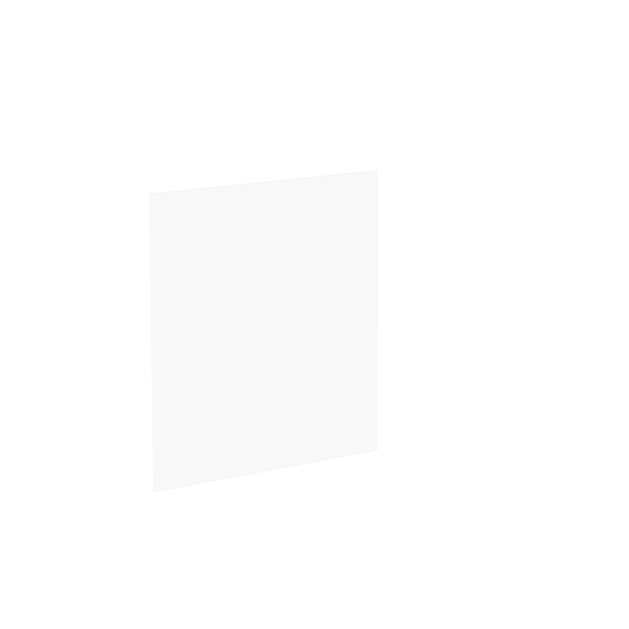

KeyboardInterrupt: 

In [118]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = sample_good_filtered.reshape((-1,19,3)) #
skipevery = 50


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sample_good_filtered.shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

<IPython.core.display.Javascript object>


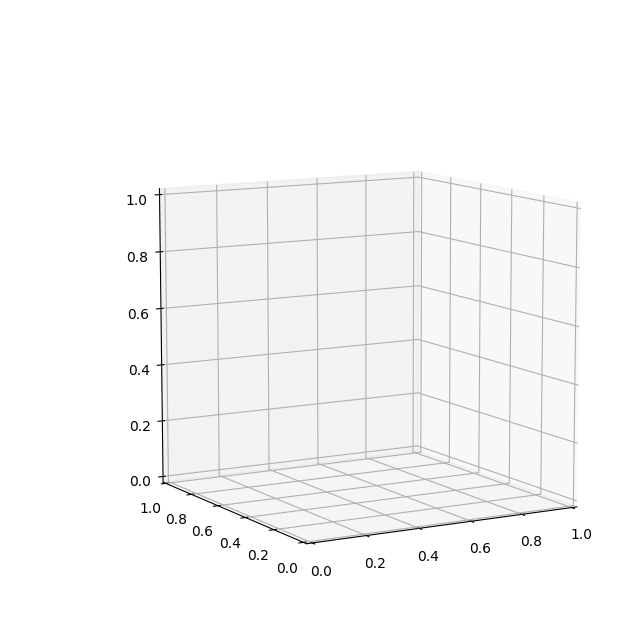

IndexError: index 274180 is out of bounds for axis 0 with size 273730

In [119]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = sample_bad_filtered.reshape((-1,19,3)) #
skipevery = 10


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,sample_bad_filtered.shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

In [120]:
X_train = np.delete(sample_good_filtered, list(range(0,len(sample_good_filtered),7)), axis =0)
X_valid = sample_good_filtered[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae7 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae7.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae7.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_4'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae7.fit(X_train, X_train, epochs=3000, verbose=1, batch_size=7000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


Training Set Shape = (2469830, 57)

Validation Set Shape = (411639, 57)

Epoch 1/3000
353/353 [==============================] - 10s 27ms/step - loss: 949.6457 - val_loss: 273.5700

Epoch 00001: loss improved from inf to 544.17609, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 2/3000
353/353 [==============================] - 8s 22ms/step - loss: 236.8106 - val_loss: 125.4628

Epoch 00002: loss improved from 544.17609 to 194.86154, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 3/3000
353/353 [==============================] - 7s 21ms/step - loss: 113.4027 - val_loss: 87.3542

Epoch 00003: loss improved from 194.86154 to 103.62483, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 4/3000
353/353 [==============================] - 7s 21ms/step - loss: 83.5108 - val_loss: 71.8969

Epoch 00004

INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 65/3000
353/353 [==============================] - 8s 23ms/step - loss: 7.5135 - val_loss: 7.2074

Epoch 00065: loss improved from 7.55196 to 7.52030, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 66/3000
353/353 [==============================] - 8s 23ms/step - loss: 7.5101 - val_loss: 7.1255

Epoch 00066: loss improved from 7.52030 to 7.51296, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 67/3000
353/353 [==============================] - 8s 22ms/step - loss: 7.3712 - val_loss: 7.1744

Epoch 00067: loss improved from 7.51296 to 7.42520, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 68/3000
353/353 [==============================] - 8s 22ms/step - loss: 7.3456 - val_loss: 7.1898

Epoch 00068: loss improved from 7

INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 105/3000
353/353 [==============================] - 7s 21ms/step - loss: 6.3579 - val_loss: 6.5819

Epoch 00105: loss improved from 6.38993 to 6.36143, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 106/3000
353/353 [==============================] - 8s 22ms/step - loss: 6.4949 - val_loss: 6.3761

Epoch 00106: loss did not improve from 6.36143
Epoch 107/3000
353/353 [==============================] - 8s 23ms/step - loss: 6.2954 - val_loss: 6.2033

Epoch 00107: loss improved from 6.36143 to 6.29975, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 108/3000
353/353 [==============================] - 8s 22ms/step - loss: 14.4291 - val_loss: 11.1820

Epoch 00108: loss did not improve from 6.29975
Epoch 109/3000
353/353 [==============================] - 8s 22ms/step - loss: 10.7554 - val_

INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 153/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.9816 - val_loss: 5.8572

Epoch 00153: loss improved from 6.04597 to 5.99581, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 154/3000
353/353 [==============================] - 8s 23ms/step - loss: 6.2146 - val_loss: 5.9564

Epoch 00154: loss did not improve from 5.99581
Epoch 155/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.9861 - val_loss: 5.8347

Epoch 00155: loss improved from 5.99581 to 5.98154, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 156/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.9874 - val_loss: 6.0502

Epoch 00156: loss did not improve from 5.98154
Epoch 157/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.9334 - val_los

353/353 [==============================] - 8s 22ms/step - loss: 6.6289 - val_loss: 6.1913

Epoch 00193: loss did not improve from 5.59956
Epoch 194/3000
353/353 [==============================] - 8s 22ms/step - loss: 6.2551 - val_loss: 5.9482

Epoch 00194: loss did not improve from 5.59956
Epoch 195/3000
353/353 [==============================] - 8s 22ms/step - loss: 6.0816 - val_loss: 5.8603

Epoch 00195: loss did not improve from 5.59956
Epoch 196/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.9830 - val_loss: 5.8029

Epoch 00196: loss did not improve from 5.59956
Epoch 197/3000
353/353 [==============================] - 7s 20ms/step - loss: 5.8501 - val_loss: 5.7728

Epoch 00197: loss did not improve from 5.59956
Epoch 198/3000
353/353 [==============================] - 7s 20ms/step - loss: 5.7752 - val_loss: 5.6639

Epoch 00198: loss did not improve from 5.59956
Epoch 199/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.7249 - val_loss:

353/353 [==============================] - 7s 21ms/step - loss: 5.3643 - val_loss: 5.4392

Epoch 00234: loss improved from 5.37891 to 5.37575, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 235/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.3724 - val_loss: 5.4137

Epoch 00235: loss improved from 5.37575 to 5.36747, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 236/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.3687 - val_loss: 5.4497

Epoch 00236: loss did not improve from 5.36747
Epoch 237/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.3178 - val_loss: 5.3252

Epoch 00237: loss improved from 5.36747 to 5.33248, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 238/3000
353/353 [==============================] - 8s 22m


Epoch 00329: loss did not improve from 5.20875
Epoch 330/3000
353/353 [==============================] - 7s 20ms/step - loss: 6.1059 - val_loss: 5.7710

Epoch 00330: loss did not improve from 5.20875
Epoch 331/3000
353/353 [==============================] - 7s 20ms/step - loss: 5.8627 - val_loss: 5.6038

Epoch 00331: loss did not improve from 5.20875
Epoch 332/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.8330 - val_loss: 5.5344

Epoch 00332: loss did not improve from 5.20875
Epoch 333/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.5795 - val_loss: 5.4672

Epoch 00333: loss did not improve from 5.20875
Epoch 334/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.5087 - val_loss: 5.3933

Epoch 00334: loss did not improve from 5.20875
Epoch 335/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.4323 - val_loss: 5.3712

Epoch 00335: loss did not improve from 5.20875
Epoch 336/3000
353/353 [==========

353/353 [==============================] - 7s 21ms/step - loss: 5.2064 - val_loss: 5.1395

Epoch 00382: loss did not improve from 5.18951
Epoch 383/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.1674 - val_loss: 5.1625

Epoch 00383: loss improved from 5.18951 to 5.17329, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 384/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.1889 - val_loss: 5.1129

Epoch 00384: loss did not improve from 5.17329
Epoch 385/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.1627 - val_loss: 5.1347

Epoch 00385: loss improved from 5.17329 to 5.16865, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 386/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.1610 - val_loss: 5.0960

Epoch 00386: loss improved from 5.16865 to 5.15540, saving model to sav

Epoch 418/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.0163 - val_loss: 5.0641

Epoch 00418: loss improved from 5.01925 to 5.01565, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 419/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.0226 - val_loss: 5.0074

Epoch 00419: loss did not improve from 5.01565
Epoch 420/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.0122 - val_loss: 4.9966

Epoch 00420: loss did not improve from 5.01565
Epoch 421/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.0051 - val_loss: 4.9841

Epoch 00421: loss improved from 5.01565 to 5.00745, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 422/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.0112 - val_loss: 4.9701

Epoch 00422: loss did not improve from 5.00745
Epoch 423

Epoch 466/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.0036 - val_loss: 5.1368

Epoch 00466: loss did not improve from 4.97111
Epoch 467/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.9970 - val_loss: 4.9274

Epoch 00467: loss improved from 4.97111 to 4.96919, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 468/3000
353/353 [==============================] - 8s 21ms/step - loss: 4.9686 - val_loss: 4.9228

Epoch 00468: loss did not improve from 4.96919
Epoch 469/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.9792 - val_loss: 5.0346

Epoch 00469: loss improved from 4.96919 to 4.96813, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 470/3000
353/353 [==============================] - 7s 21ms/step - loss: 4.9558 - val_loss: 5.0852

Epoch 00470: loss improved from 4.96813 to 4.95312, savi

INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 504/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.8873 - val_loss: 4.9080

Epoch 00504: loss did not improve from 4.88251
Epoch 505/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.8772 - val_loss: 4.8383

Epoch 00505: loss improved from 4.88251 to 4.87680, saving model to saved_model/four_layer_4
INFO:tensorflow:Assets written to: saved_model/four_layer_4/assets
Epoch 506/3000
353/353 [==============================] - 7s 21ms/step - loss: 4.8820 - val_loss: 5.0686

Epoch 00506: loss did not improve from 4.87680
Epoch 507/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.9408 - val_loss: 4.8442

Epoch 00507: loss did not improve from 4.87680
Epoch 508/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.8758 - val_loss: 4.8262

Epoch 00508: loss improved from 4.87680 to 4.87474, saving model to saved_model/four_layer_4
INFO:tens


Epoch 00604: loss did not improve from 4.83797
Epoch 605/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.0457 - val_loss: 4.8542

Epoch 00605: loss did not improve from 4.83797
Epoch 606/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.8825 - val_loss: 4.8382

Epoch 00606: loss did not improve from 4.83797
Epoch 607/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.3842 - val_loss: 6.3863

Epoch 00607: loss did not improve from 4.83797
Epoch 608/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.6149 - val_loss: 4.9760

Epoch 00608: loss did not improve from 4.83797
Epoch 609/3000
353/353 [==============================] - 8s 22ms/step - loss: 4.9624 - val_loss: 4.8751

Epoch 00609: loss did not improve from 4.83797
Epoch 610/3000
353/353 [==============================] - 8s 21ms/step - loss: 4.8831 - val_loss: 4.8495

Epoch 00610: loss did not improve from 4.83797
Epoch 611/3000
353/353 [==========

353/353 [==============================] - 7s 21ms/step - loss: 4.7904 - val_loss: 4.7568

Epoch 00697: loss did not improve from 4.77630
Epoch 698/3000
353/353 [==============================] - 7s 21ms/step - loss: 4.7831 - val_loss: 4.8382

Epoch 00698: loss did not improve from 4.77630
Epoch 699/3000
353/353 [==============================] - 7s 21ms/step - loss: 38.6748 - val_loss: 40.1494

Epoch 00699: loss did not improve from 4.77630
Epoch 700/3000
353/353 [==============================] - 7s 20ms/step - loss: 36.2578 - val_loss: 33.7521

Epoch 00700: loss did not improve from 4.77630
Epoch 701/3000
353/353 [==============================] - 7s 20ms/step - loss: 25.8920 - val_loss: 19.0612

Epoch 00701: loss did not improve from 4.77630
Epoch 702/3000
353/353 [==============================] - 7s 21ms/step - loss: 18.1157 - val_loss: 13.4087

Epoch 00702: loss did not improve from 4.77630
Epoch 703/3000
353/353 [==============================] - 7s 21ms/step - loss: 14.0266 - 


Epoch 00803: loss did not improve from 4.77630
Epoch 804/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.0962 - val_loss: 4.9607

Epoch 00804: loss did not improve from 4.77630
Epoch 805/3000
353/353 [==============================] - 7s 21ms/step - loss: 4.9925 - val_loss: 5.6028

Epoch 00805: loss did not improve from 4.77630
Epoch 806/3000
353/353 [==============================] - 7s 20ms/step - loss: 5.0168 - val_loss: 4.9152

Epoch 00806: loss did not improve from 4.77630
Epoch 807/3000
353/353 [==============================] - 7s 21ms/step - loss: 4.9449 - val_loss: 4.9180

Epoch 00807: loss did not improve from 4.77630
Epoch 808/3000
353/353 [==============================] - 8s 21ms/step - loss: 4.9496 - val_loss: 4.8950

Epoch 00808: loss did not improve from 4.77630
Epoch 809/3000
353/353 [==============================] - 7s 21ms/step - loss: 4.9612 - val_loss: 4.8863

Epoch 00809: loss did not improve from 4.77630
Epoch 810/3000
353/353 [==========


Epoch 00910: loss did not improve from 4.77630
Epoch 911/3000
353/353 [==============================] - 8s 21ms/step - loss: 53.2002 - val_loss: 10.4106

Epoch 00911: loss did not improve from 4.77630
Epoch 912/3000
353/353 [==============================] - 8s 22ms/step - loss: 10.1928 - val_loss: 8.2676

Epoch 00912: loss did not improve from 4.77630
Epoch 913/3000
353/353 [==============================] - 8s 22ms/step - loss: 8.2560 - val_loss: 9.0157

Epoch 00913: loss did not improve from 4.77630
Epoch 914/3000
353/353 [==============================] - 8s 22ms/step - loss: 7.5491 - val_loss: 7.0241

Epoch 00914: loss did not improve from 4.77630
Epoch 915/3000
353/353 [==============================] - 8s 23ms/step - loss: 7.1133 - val_loss: 7.0647

Epoch 00915: loss did not improve from 4.77630
Epoch 916/3000
353/353 [==============================] - 8s 21ms/step - loss: 6.6510 - val_loss: 6.0902

Epoch 00916: loss did not improve from 4.77630
Epoch 917/3000
353/353 [=======

353/353 [==============================] - 8s 22ms/step - loss: 6.4736 - val_loss: 5.7784

Epoch 01017: loss did not improve from 4.77630
Epoch 1018/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.8268 - val_loss: 5.6833

Epoch 01018: loss did not improve from 4.77630
Epoch 1019/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.6435 - val_loss: 5.5449

Epoch 01019: loss did not improve from 4.77630
Epoch 1020/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.4415 - val_loss: 5.9984

Epoch 01020: loss did not improve from 4.77630
Epoch 1021/3000
353/353 [==============================] - 8s 21ms/step - loss: 5.3944 - val_loss: 5.1931

Epoch 01021: loss did not improve from 4.77630
Epoch 1022/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.3060 - val_loss: 5.7933

Epoch 01022: loss did not improve from 4.77630
Epoch 1023/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.3215 - val

353/353 [==============================] - 8s 22ms/step - loss: 6.6057 - val_loss: 5.1755

Epoch 01123: loss did not improve from 4.77630
Epoch 1124/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.1631 - val_loss: 5.1572

Epoch 01124: loss did not improve from 4.77630
Epoch 1125/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.0840 - val_loss: 5.3096

Epoch 01125: loss did not improve from 4.77630
Epoch 1126/3000
353/353 [==============================] - 7s 21ms/step - loss: 5.0755 - val_loss: 5.0392

Epoch 01126: loss did not improve from 4.77630
Epoch 1127/3000
353/353 [==============================] - 8s 22ms/step - loss: 5.0573 - val_loss: 5.0968

Epoch 01127: loss did not improve from 4.77630
Epoch 1128/3000
353/353 [==============================] - 8s 22ms/step - loss: 7.2148 - val_loss: 30.4796

Epoch 01128: loss did not improve from 4.77630
Epoch 1129/3000
353/353 [==============================] - 8s 22ms/step - loss: 21.3489 - v

KeyboardInterrupt: 

In [121]:
variational_ae = tf.keras.models.load_model('saved_model/four_layer_4')
print("Generate predictions for Interpolate centered data")
predictedX_sample_goodfilterednew = variational_ae.predict(sample_good_filtered)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(sample_good_filtered.reshape((-1,19,3))-predictedX_sample_goodfilterednew.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=2881469, minmax=(array([0.01521514, 0.02518633, 0.01567767, 0.01003666, 0.0129491 ,
       0.00871065, 0.01628072, 0.014334  , 0.01707682, 0.01174716,
       0.01572589, 0.01529086, 0.00505109, 0.00600321, 0.02407633,
       0.01456899, 0.01231151, 0.00942745, 0.01152177]), array([38.36193592, 45.35702821, 24.04608151, 30.28069801, 29.21799017,
       40.28459241, 22.47185142, 29.90910552, 30.87325262, 20.54942928,
       33.6613626 , 47.64706542, 27.33704907, 40.57241432, 29.60895571,
       47.29727928, 26.97765825, 33.99833366, 64.74037545])), mean=array([3.66672338, 4.0638331 , 3.34549799, 3.57697924, 2.01811699,
       2.4944572 , 2.70717868, 2.28664228, 2.24610635, 2.47465223,
       2.70052651, 2.23748644, 2.17528835, 3.89913291, 3.81049155,
       3.06976239, 3.08119956, 2.67691754, 2.20682059]), variance=array([5.81119119, 7.46807075, 4.51923646, 5.23000218, 1.71351964,
       2.74544236, 3.0766767 , 2.12799601, 2.17214612, 2.85369555,
       2.88239686, 2.

In [124]:
predictedX_sample_filtered_new = variational_ae.predict(sample)

In [126]:
#badX12 = np.where(np.mean(np.linalg.norm(X_good_filtered.reshape((-1,19,3))-predictedX_good_filtered.reshape((-1,19,3)), axis=2), axis=1) >= 35)
badX14 = np.where(np.any(np.linalg.norm(sample.reshape((-1,19,3))-predictedX_sample_filtered_new.reshape((-1,19,3)), axis=2) >= 15, axis=1)) 
goodX14 = np.setdiff1d(np.arange(sample.shape[0]), badX14)
badXX14 = np.setdiff1d(np.arange(sample.shape[0]), goodX14)
sample_good_filtered_new = sample[goodX14,]
sample_bad_filtered_new = sample[badXX14,]
print('Shape of X = '+str(np.shape(sample))+'\n')
print('Shape of good X = '+str(np.shape(sample_good_filtered_new))+'\n')
print('Shape of bad X = '+str(np.shape(sample_bad_filtered_new))+'\n')

Shape of X = (3155199, 57)

Shape of good X = (2880805, 57)

Shape of bad X = (274394, 57)



<IPython.core.display.Javascript object>


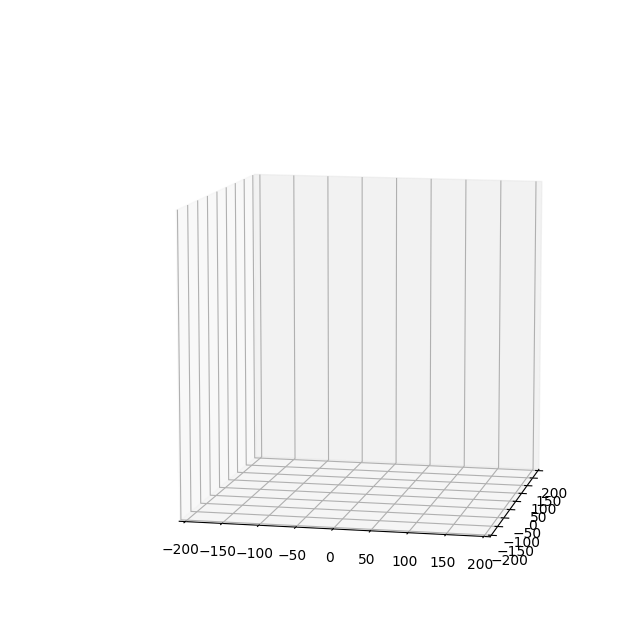

KeyboardInterrupt: 

In [128]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = predictedX_sample_filtered_new[badXX14,].reshape((-1,19,3)) #
skipevery = 5


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,predictedX_sample_filtered_new[badXX14].shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

# Old note begins here again

In [18]:
variational_ae = tf.keras.models.load_model('saved_model/four_layer_14')

In [13]:
print("Generate predictions for Interpolate centered data")
predictedX_dropeh5_sample = variational_ae.predict(dropeh5_sample)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(dropeh5_sample.reshape((-1,19,3))-predictedX_dropeh5_sample.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=3155199, minmax=(array([0.01450421, 0.01167782, 0.01304889, 0.02170671, 0.01139532,
       0.00646274, 0.01644157, 0.00822939, 0.00700969, 0.01690698,
       0.02152605, 0.00559565, 0.01741282, 0.01527057, 0.01633428,
       0.01464578, 0.02051206, 0.02038428, 0.01752871]), array([184.48693097, 178.17890842, 196.97641778, 170.48084685,
       182.42526615, 152.30736862, 179.77454555, 214.11744143,
       200.06921418, 236.35918563, 190.0165679 , 279.27177163,
       279.79149998, 227.58635695, 171.97878339, 240.94331368,
       196.09834121, 215.33515295, 232.45532439])), mean=array([4.68650846, 5.20890834, 4.39171168, 4.76918792, 2.83968623,
       3.32096727, 3.59015275, 3.03354852, 3.14298161, 3.30511977,
       3.5322896 , 2.82384859, 2.67702579, 5.07088656, 4.66797042,
       3.97647519, 3.75757582, 3.72969503, 2.79661213]), variance=array([17.26812887, 18.98038134, 17.08564918, 18.67587124,  5.7324807 ,
       10.30419025,  9.80919809, 11.10068875, 15.1573548 

In [40]:
save('predictedX_dropeh5_sample.npy', predictedX_dropeh5_sample)

In [8]:
predictedX_dropeh5_sample = np.load('predictedX_dropeh5_sample.npy')

In [12]:
#badX12 = np.where(np.mean(np.linalg.norm(X_good_filtered.reshape((-1,19,3))-predictedX_good_filtered.reshape((-1,19,3)), axis=2), axis=1) >= 35)
badX12 = np.where(np.any(np.linalg.norm(dropeh5_sample.reshape((-1,19,3))-predictedX_dropeh5_sample.reshape((-1,19,3)), axis=2) >= 48, axis=1)) #was 48
goodX12 = np.setdiff1d(np.arange(dropeh5_sample.shape[0]), badX12)
badXX12 = np.setdiff1d(np.arange(dropeh5_sample.shape[0]), goodX12)
X_good12 = dropeh5_sample[goodX12,]
X_bad12 = dropeh5_sample[badXX12,]
print('Shape of X = '+str(np.shape(dropeh5_sample))+'\n')
print('Shape of good X = '+str(np.shape(X_good12))+'\n')
print('Shape of bad X = '+str(np.shape(X_bad12))+'\n')


Shape of X = (3155199, 57)

Shape of good X = (3015354, 57)

Shape of bad X = (139845, 57)



In [38]:
variational_ae

<IPython.core.display.Javascript object>


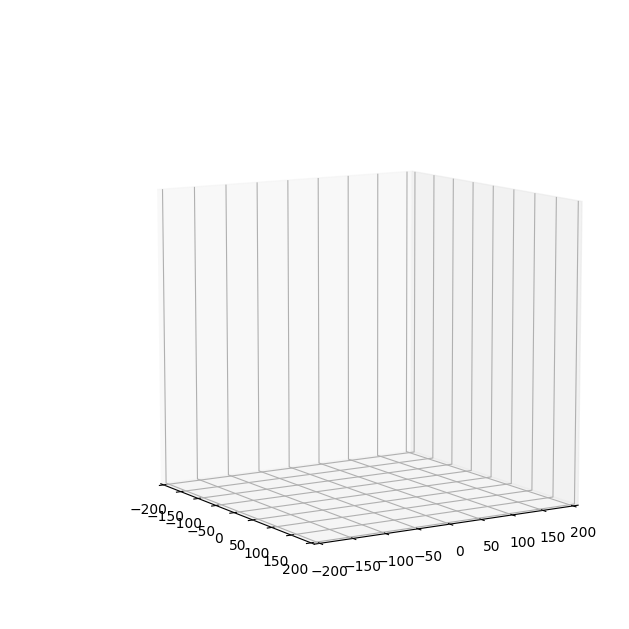

KeyboardInterrupt: 

In [13]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = X_bad12.reshape((-1,19,3)) #
skipevery = 100


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,X_bad12.shape[0], 57):#goodsinraw[::60]:
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    

    fig.canvas.draw()   

# Final Training After Removing High VAE Error Points

In [ ]:
#48

In [10]:
X_train = np.delete(X_good12, list(range(0,len(X_good12),7)), axis =0)
X_valid = X_good12[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae1 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae1.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae1.compile(loss="mse", optimizer="adam")

# define the checkpoint
filepath = 'saved_model/four_layer_2'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

##
vae_history = variational_ae1.fit(X_train, X_train, epochs=3000, verbose=1, batch_size=7000, validation_data=(X_valid, X_valid), shuffle = True, callbacks=callbacks_list)


Training Set Shape = (2691704, 57)

Validation Set Shape = (448618, 57)

Epoch 1/3000
385/385 [==============================] - 8s 19ms/step - loss: 926.3520 - val_loss: 256.8566

Epoch 00001: loss improved from inf to 534.65253, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 2/3000
385/385 [==============================] - 7s 19ms/step - loss: 202.0400 - val_loss: 120.9052

Epoch 00002: loss improved from 534.65253 to 165.16359, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 3/3000
385/385 [==============================] - 7s 18ms/step - loss: 110.8943 - val_loss: 87.3746

Epoch 00003: loss improved from 165.16359 to 102.17436, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 4/3000
385/385 [==============================] - 8s 20ms/step - loss: 77.3708 - val_loss: 61.8151

Epoch 00004:

385/385 [==============================] - 7s 18ms/step - loss: 11.5548 - val_loss: 11.3732

Epoch 00066: loss improved from 11.65363 to 11.53788, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 67/3000
385/385 [==============================] - 7s 19ms/step - loss: 11.6185 - val_loss: 81.0566

Epoch 00067: loss did not improve from 11.53788
Epoch 68/3000
385/385 [==============================] - 7s 19ms/step - loss: 35.3900 - val_loss: 17.2542

Epoch 00068: loss did not improve from 11.53788
Epoch 69/3000
385/385 [==============================] - 8s 20ms/step - loss: 16.6623 - val_loss: 13.5693

Epoch 00069: loss did not improve from 11.53788
Epoch 70/3000
385/385 [==============================] - 7s 19ms/step - loss: 13.7985 - val_loss: 12.6056

Epoch 00070: loss did not improve from 11.53788
Epoch 71/3000
385/385 [==============================] - 7s 19ms/step - loss: 12.7072 - val_loss: 12.1113

Epoch 00071: loss 


Epoch 00105: loss improved from 10.16219 to 10.12105, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 106/3000
385/385 [==============================] - 7s 18ms/step - loss: 47.5758 - val_loss: 34.3198

Epoch 00106: loss did not improve from 10.12105
Epoch 107/3000
385/385 [==============================] - 7s 19ms/step - loss: 27.8889 - val_loss: 21.6306

Epoch 00107: loss did not improve from 10.12105
Epoch 108/3000
385/385 [==============================] - 7s 19ms/step - loss: 20.1192 - val_loss: 17.4095

Epoch 00108: loss did not improve from 10.12105
Epoch 109/3000
385/385 [==============================] - 7s 19ms/step - loss: 16.2778 - val_loss: 14.1888

Epoch 00109: loss did not improve from 10.12105
Epoch 110/3000
385/385 [==============================] - 7s 18ms/step - loss: 13.9433 - val_loss: 12.5556

Epoch 00110: loss did not improve from 10.12105
Epoch 111/3000
385/385 [==============================] -

INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 146/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.4805 - val_loss: 9.3742

Epoch 00146: loss improved from 9.51045 to 9.49648, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 147/3000
385/385 [==============================] - 8s 19ms/step - loss: 9.4585 - val_loss: 9.5007

Epoch 00147: loss improved from 9.49648 to 9.47565, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 148/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.4331 - val_loss: 9.4965

Epoch 00148: loss improved from 9.47565 to 9.45247, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 149/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.4415 - val_loss: 9.6883

Epoch 00149: loss improved fr

Epoch 191/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.1799 - val_loss: 9.1102

Epoch 00191: loss improved from 9.23264 to 9.21966, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 192/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.1932 - val_loss: 9.1470

Epoch 00192: loss improved from 9.21966 to 9.17918, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 193/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.1900 - val_loss: 9.2027

Epoch 00193: loss improved from 9.17918 to 9.17458, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 194/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.1406 - val_loss: 9.0642

Epoch 00194: loss improved from 9.17458 to 9.15904, saving model to saved_model/four_layer_2
INF

INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 226/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.8525 - val_loss: 8.8839

Epoch 00226: loss improved from 8.86623 to 8.84761, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 227/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.8387 - val_loss: 9.0661

Epoch 00227: loss did not improve from 8.84761
Epoch 228/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.8552 - val_loss: 8.8285

Epoch 00228: loss did not improve from 8.84761
Epoch 229/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.8219 - val_loss: 8.8601

Epoch 00229: loss improved from 8.84761 to 8.84212, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 230/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.8222 - val_los


Epoch 00298: loss improved from 8.53701 to 8.53370, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 299/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5415 - val_loss: 8.5250

Epoch 00299: loss improved from 8.53370 to 8.53302, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 300/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5246 - val_loss: 8.4917

Epoch 00300: loss improved from 8.53302 to 8.53155, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 301/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5093 - val_loss: 8.4739

Epoch 00301: loss improved from 8.53155 to 8.51981, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 302/3000
385/385 [=================

385/385 [==============================] - 7s 19ms/step - loss: 8.4143 - val_loss: 8.9485

Epoch 00337: loss improved from 8.42012 to 8.41732, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 338/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.4520 - val_loss: 8.3952

Epoch 00338: loss improved from 8.41732 to 8.41690, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 339/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4237 - val_loss: 8.4278

Epoch 00339: loss did not improve from 8.41690
Epoch 340/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4115 - val_loss: 8.3648

Epoch 00340: loss improved from 8.41690 to 8.40532, saving model to saved_model/four_layer_2
INFO:tensorflow:Assets written to: saved_model/four_layer_2/assets
Epoch 341/3000
385/385 [==============================] - 8s 20m

385/385 [==============================] - 8s 20ms/step - loss: 8.4701 - val_loss: 8.5104

Epoch 00387: loss did not improve from 8.39382
Epoch 388/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4646 - val_loss: 8.4660

Epoch 00388: loss did not improve from 8.39382
Epoch 389/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4641 - val_loss: 8.4675

Epoch 00389: loss did not improve from 8.39382
Epoch 390/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4299 - val_loss: 8.7365

Epoch 00390: loss did not improve from 8.39382
Epoch 391/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4444 - val_loss: 8.3828

Epoch 00391: loss did not improve from 8.39382
Epoch 392/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4469 - val_loss: 8.6603

Epoch 00392: loss did not improve from 8.39382
Epoch 393/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4476 - val_loss:

Epoch 437/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.3524 - val_loss: 8.3212

Epoch 00437: loss did not improve from 8.33850
Epoch 438/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.3611 - val_loss: 8.2676

Epoch 00438: loss did not improve from 8.33850
Epoch 439/3000
385/385 [==============================] - 7s 19ms/step - loss: 14.6739 - val_loss: 76.9641

Epoch 00439: loss did not improve from 8.33850
Epoch 440/3000
385/385 [==============================] - 8s 20ms/step - loss: 60.0045 - val_loss: 29.8105

Epoch 00440: loss did not improve from 8.33850
Epoch 441/3000
385/385 [==============================] - 8s 20ms/step - loss: 29.0859 - val_loss: 23.5462

Epoch 00441: loss did not improve from 8.33850
Epoch 442/3000
385/385 [==============================] - 7s 19ms/step - loss: 22.8242 - val_loss: 18.8348

Epoch 00442: loss did not improve from 8.33850
Epoch 443/3000
385/385 [==============================] - 8s 20ms/step - l

385/385 [==============================] - 7s 19ms/step - loss: 9.0226 - val_loss: 8.5775

Epoch 00543: loss did not improve from 8.27078
Epoch 544/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5850 - val_loss: 8.5208

Epoch 00544: loss did not improve from 8.27078
Epoch 545/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.5581 - val_loss: 8.4878

Epoch 00545: loss did not improve from 8.27078
Epoch 546/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5531 - val_loss: 8.4715

Epoch 00546: loss did not improve from 8.27078
Epoch 547/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5377 - val_loss: 8.5125

Epoch 00547: loss did not improve from 8.27078
Epoch 548/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5153 - val_loss: 8.5759

Epoch 00548: loss did not improve from 8.27078
Epoch 549/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.4965 - val_loss:

385/385 [==============================] - 8s 21ms/step - loss: 8.5795 - val_loss: 8.6196

Epoch 00649: loss did not improve from 8.27078
Epoch 650/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5474 - val_loss: 8.4853

Epoch 00650: loss did not improve from 8.27078
Epoch 651/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5440 - val_loss: 8.7013

Epoch 00651: loss did not improve from 8.27078
Epoch 652/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6428 - val_loss: 8.3760

Epoch 00652: loss did not improve from 8.27078
Epoch 653/3000
385/385 [==============================] - 7s 18ms/step - loss: 8.4559 - val_loss: 8.4023

Epoch 00653: loss did not improve from 8.27078
Epoch 654/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4765 - val_loss: 8.3501

Epoch 00654: loss did not improve from 8.27078
Epoch 655/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.5053 - val_loss:

385/385 [==============================] - 8s 20ms/step - loss: 8.7358 - val_loss: 8.6866

Epoch 00755: loss did not improve from 8.27078
Epoch 756/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6716 - val_loss: 8.5540

Epoch 00756: loss did not improve from 8.27078
Epoch 757/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6503 - val_loss: 8.6621

Epoch 00757: loss did not improve from 8.27078
Epoch 758/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5859 - val_loss: 8.5647

Epoch 00758: loss did not improve from 8.27078
Epoch 759/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5877 - val_loss: 8.5657

Epoch 00759: loss did not improve from 8.27078
Epoch 760/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5666 - val_loss: 8.6002

Epoch 00760: loss did not improve from 8.27078
Epoch 761/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5890 - val_loss:

385/385 [==============================] - 8s 20ms/step - loss: 8.7016 - val_loss: 8.5271

Epoch 00861: loss did not improve from 8.27078
Epoch 862/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.6745 - val_loss: 8.7633

Epoch 00862: loss did not improve from 8.27078
Epoch 863/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.6354 - val_loss: 8.5212

Epoch 00863: loss did not improve from 8.27078
Epoch 864/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5579 - val_loss: 8.5741

Epoch 00864: loss did not improve from 8.27078
Epoch 865/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.6090 - val_loss: 8.6114

Epoch 00865: loss did not improve from 8.27078
Epoch 866/3000
385/385 [==============================] - 8s 21ms/step - loss: 119.9295 - val_loss: 74.3569

Epoch 00866: loss did not improve from 8.27078
Epoch 867/3000
385/385 [==============================] - 7s 19ms/step - loss: 52.8290 - val_l

385/385 [==============================] - 7s 19ms/step - loss: 8.9328 - val_loss: 8.7968

Epoch 00967: loss did not improve from 8.27078
Epoch 968/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9352 - val_loss: 8.7720

Epoch 00968: loss did not improve from 8.27078
Epoch 969/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.8539 - val_loss: 8.6019

Epoch 00969: loss did not improve from 8.27078
Epoch 970/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7597 - val_loss: 8.6001

Epoch 00970: loss did not improve from 8.27078
Epoch 971/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6852 - val_loss: 8.7450

Epoch 00971: loss did not improve from 8.27078
Epoch 972/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6629 - val_loss: 10.5813

Epoch 00972: loss did not improve from 8.27078
Epoch 973/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.8499 - val_loss

385/385 [==============================] - 8s 20ms/step - loss: 10.1930 - val_loss: 9.5827

Epoch 01073: loss did not improve from 8.27078
Epoch 1074/3000
385/385 [==============================] - 8s 19ms/step - loss: 9.7025 - val_loss: 9.1757

Epoch 01074: loss did not improve from 8.27078
Epoch 1075/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.4232 - val_loss: 9.0377

Epoch 01075: loss did not improve from 8.27078
Epoch 1076/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.2957 - val_loss: 8.9282

Epoch 01076: loss did not improve from 8.27078
Epoch 1077/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.0659 - val_loss: 9.4741

Epoch 01077: loss did not improve from 8.27078
Epoch 1078/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.0956 - val_loss: 9.4448

Epoch 01078: loss did not improve from 8.27078
Epoch 1079/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9435 - va

385/385 [==============================] - 8s 22ms/step - loss: 15.2436 - val_loss: 12.4606

Epoch 01126: loss did not improve from 8.27078
Epoch 1127/3000
385/385 [==============================] - 8s 21ms/step - loss: 12.9111 - val_loss: 11.1983

Epoch 01127: loss did not improve from 8.27078
Epoch 1128/3000
385/385 [==============================] - 8s 20ms/step - loss: 11.4025 - val_loss: 11.4143

Epoch 01128: loss did not improve from 8.27078
Epoch 1129/3000
385/385 [==============================] - 8s 20ms/step - loss: 10.8526 - val_loss: 11.1611

Epoch 01129: loss did not improve from 8.27078
Epoch 1130/3000
385/385 [==============================] - 8s 21ms/step - loss: 10.3399 - val_loss: 9.9825

Epoch 01130: loss did not improve from 8.27078
Epoch 1131/3000
385/385 [==============================] - 8s 22ms/step - loss: 9.9451 - val_loss: 9.4105

Epoch 01131: loss did not improve from 8.27078
Epoch 1132/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.6

385/385 [==============================] - 8s 20ms/step - loss: 8.9417 - val_loss: 8.7554

Epoch 01179: loss did not improve from 8.27078
Epoch 1180/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7913 - val_loss: 8.8526

Epoch 01180: loss did not improve from 8.27078
Epoch 1181/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7582 - val_loss: 8.5569

Epoch 01181: loss did not improve from 8.27078
Epoch 1182/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6969 - val_loss: 8.5727

Epoch 01182: loss did not improve from 8.27078
Epoch 1183/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7574 - val_loss: 8.6380

Epoch 01183: loss did not improve from 8.27078
Epoch 1184/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.8111 - val_loss: 8.4416

Epoch 01184: loss did not improve from 8.27078
Epoch 1185/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.5679 - val

385/385 [==============================] - 8s 20ms/step - loss: 8.6484 - val_loss: 8.5789

Epoch 01232: loss did not improve from 8.27078
Epoch 1233/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.6374 - val_loss: 8.8635

Epoch 01233: loss did not improve from 8.27078
Epoch 1234/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5873 - val_loss: 8.6231

Epoch 01234: loss did not improve from 8.27078
Epoch 1235/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5456 - val_loss: 8.4415

Epoch 01235: loss did not improve from 8.27078
Epoch 1236/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5424 - val_loss: 8.5853

Epoch 01236: loss did not improve from 8.27078
Epoch 1237/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4955 - val_loss: 8.4512

Epoch 01237: loss did not improve from 8.27078
Epoch 1238/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4613 - val

385/385 [==============================] - 8s 20ms/step - loss: 8.7627 - val_loss: 8.8559

Epoch 01285: loss did not improve from 8.27078
Epoch 1286/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7456 - val_loss: 8.5845

Epoch 01286: loss did not improve from 8.27078
Epoch 1287/3000
385/385 [==============================] - 8s 19ms/step - loss: 8.6518 - val_loss: 8.7773

Epoch 01287: loss did not improve from 8.27078
Epoch 1288/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6057 - val_loss: 8.8036

Epoch 01288: loss did not improve from 8.27078
Epoch 1289/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5578 - val_loss: 9.1833

Epoch 01289: loss did not improve from 8.27078
Epoch 1290/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5894 - val_loss: 8.4929

Epoch 01290: loss did not improve from 8.27078
Epoch 1291/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5054 - val

385/385 [==============================] - 8s 20ms/step - loss: 8.8044 - val_loss: 8.6728

Epoch 01338: loss did not improve from 8.27078
Epoch 1339/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7897 - val_loss: 8.5970

Epoch 01339: loss did not improve from 8.27078
Epoch 1340/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.7032 - val_loss: 8.5811

Epoch 01340: loss did not improve from 8.27078
Epoch 1341/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6214 - val_loss: 8.5479

Epoch 01341: loss did not improve from 8.27078
Epoch 1342/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6078 - val_loss: 8.5714

Epoch 01342: loss did not improve from 8.27078
Epoch 1343/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6301 - val_loss: 8.4842

Epoch 01343: loss did not improve from 8.27078
Epoch 1344/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5194 - val

385/385 [==============================] - 8s 21ms/step - loss: 21.8358 - val_loss: 18.7198

Epoch 01443: loss did not improve from 8.26519
Epoch 1444/3000
385/385 [==============================] - 8s 21ms/step - loss: 19.9338 - val_loss: 18.0370

Epoch 01444: loss did not improve from 8.26519
Epoch 1445/3000
385/385 [==============================] - 8s 20ms/step - loss: 19.0511 - val_loss: 16.0892

Epoch 01445: loss did not improve from 8.26519
Epoch 1446/3000
385/385 [==============================] - 8s 20ms/step - loss: 16.7592 - val_loss: 13.7090

Epoch 01446: loss did not improve from 8.26519
Epoch 1447/3000
385/385 [==============================] - 8s 20ms/step - loss: 14.6858 - val_loss: 12.9464

Epoch 01447: loss did not improve from 8.26519
Epoch 1448/3000
385/385 [==============================] - 8s 20ms/step - loss: 14.1606 - val_loss: 14.9742

Epoch 01448: loss did not improve from 8.26519
Epoch 1449/3000
385/385 [==============================] - 8s 22ms/step - loss: 

385/385 [==============================] - 7s 19ms/step - loss: 8.3914 - val_loss: 8.3329

Epoch 01496: loss did not improve from 8.26519
Epoch 1497/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.3498 - val_loss: 8.3275

Epoch 01497: loss did not improve from 8.26519
Epoch 1498/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.3106 - val_loss: 8.2791

Epoch 01498: loss did not improve from 8.26519
Epoch 1499/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.0372 - val_loss: 201.0659

Epoch 01499: loss did not improve from 8.26519
Epoch 1500/3000
385/385 [==============================] - 8s 21ms/step - loss: 88.7369 - val_loss: 32.3891

Epoch 01500: loss did not improve from 8.26519
Epoch 1501/3000
385/385 [==============================] - 8s 20ms/step - loss: 28.2229 - val_loss: 24.1296

Epoch 01501: loss did not improve from 8.26519
Epoch 1502/3000
385/385 [==============================] - 8s 21ms/step - loss: 23.299

385/385 [==============================] - 7s 19ms/step - loss: 11.2042 - val_loss: 12.1671

Epoch 01549: loss did not improve from 8.26519
Epoch 1550/3000
385/385 [==============================] - 8s 20ms/step - loss: 10.9966 - val_loss: 11.4299

Epoch 01550: loss did not improve from 8.26519
Epoch 1551/3000
385/385 [==============================] - 8s 20ms/step - loss: 10.4310 - val_loss: 9.7651

Epoch 01551: loss did not improve from 8.26519
Epoch 1552/3000
385/385 [==============================] - 8s 20ms/step - loss: 10.6620 - val_loss: 9.6755

Epoch 01552: loss did not improve from 8.26519
Epoch 1553/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.7919 - val_loss: 10.0943

Epoch 01553: loss did not improve from 8.26519
Epoch 1554/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.6880 - val_loss: 9.6011

Epoch 01554: loss did not improve from 8.26519
Epoch 1555/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.511

385/385 [==============================] - 8s 21ms/step - loss: 11.7123 - val_loss: 140.2689

Epoch 01602: loss did not improve from 8.26519
Epoch 1603/3000
385/385 [==============================] - 8s 20ms/step - loss: 108.7987 - val_loss: 58.8327

Epoch 01603: loss did not improve from 8.26519
Epoch 1604/3000
385/385 [==============================] - 8s 21ms/step - loss: 60.4638 - val_loss: 43.0572

Epoch 01604: loss did not improve from 8.26519
Epoch 1605/3000
385/385 [==============================] - 8s 21ms/step - loss: 41.1875 - val_loss: 29.4748

Epoch 01605: loss did not improve from 8.26519
Epoch 1606/3000
385/385 [==============================] - 8s 21ms/step - loss: 30.7505 - val_loss: 42.4997

Epoch 01606: loss did not improve from 8.26519
Epoch 1607/3000
385/385 [==============================] - 8s 21ms/step - loss: 26.3001 - val_loss: 26.5940

Epoch 01607: loss did not improve from 8.26519
Epoch 1608/3000
385/385 [==============================] - 8s 20ms/step - loss

385/385 [==============================] - 8s 20ms/step - loss: 8.2894 - val_loss: 8.2964

Epoch 01655: loss did not improve from 8.26519
Epoch 1656/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.3276 - val_loss: 9.6515

Epoch 01656: loss did not improve from 8.26519
Epoch 1657/3000
385/385 [==============================] - 8s 20ms/step - loss: 349.5847 - val_loss: 200.4766

Epoch 01657: loss did not improve from 8.26519
Epoch 1658/3000
385/385 [==============================] - 8s 20ms/step - loss: 179.7149 - val_loss: 164.1988

Epoch 01658: loss did not improve from 8.26519
Epoch 1659/3000
385/385 [==============================] - 8s 21ms/step - loss: 161.6913 - val_loss: 128.3668

Epoch 01659: loss did not improve from 8.26519
Epoch 1660/3000
385/385 [==============================] - 8s 20ms/step - loss: 126.7988 - val_loss: 93.9151

Epoch 01660: loss did not improve from 8.26519
Epoch 1661/3000
385/385 [==============================] - 8s 21ms/step - los

385/385 [==============================] - 8s 21ms/step - loss: 8.5677 - val_loss: 8.7460

Epoch 01708: loss did not improve from 8.26519
Epoch 1709/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5236 - val_loss: 8.5084

Epoch 01709: loss did not improve from 8.26519
Epoch 1710/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4978 - val_loss: 8.7349

Epoch 01710: loss did not improve from 8.26519
Epoch 1711/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5356 - val_loss: 8.5398

Epoch 01711: loss did not improve from 8.26519
Epoch 1712/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.9968 - val_loss: 31.1113

Epoch 01712: loss did not improve from 8.26519
Epoch 1713/3000
385/385 [==============================] - 8s 21ms/step - loss: 19.6472 - val_loss: 10.2676

Epoch 01713: loss did not improve from 8.26519
Epoch 1714/3000
385/385 [==============================] - 8s 21ms/step - loss: 10.1055 -


Epoch 01759: loss did not improve from 8.22578
Epoch 1760/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.4104 - val_loss: 9.2461

Epoch 01760: loss did not improve from 8.22578
Epoch 1761/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.2799 - val_loss: 8.9967

Epoch 01761: loss did not improve from 8.22578
Epoch 1762/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.0117 - val_loss: 8.8882

Epoch 01762: loss did not improve from 8.22578
Epoch 1763/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9001 - val_loss: 8.6473

Epoch 01763: loss did not improve from 8.22578
Epoch 1764/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.7993 - val_loss: 8.6348

Epoch 01764: loss did not improve from 8.22578
Epoch 1765/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.7265 - val_loss: 8.5900

Epoch 01765: loss did not improve from 8.22578
Epoch 1766/3000
385/385 [===


Epoch 01812: loss did not improve from 8.22578
Epoch 1813/3000
385/385 [==============================] - 8s 20ms/step - loss: 102.2210 - val_loss: 85.3125

Epoch 01813: loss did not improve from 8.22578
Epoch 1814/3000
385/385 [==============================] - 8s 20ms/step - loss: 82.7710 - val_loss: 80.9809

Epoch 01814: loss did not improve from 8.22578
Epoch 1815/3000
385/385 [==============================] - 8s 20ms/step - loss: 78.8832 - val_loss: 71.2587

Epoch 01815: loss did not improve from 8.22578
Epoch 1816/3000
385/385 [==============================] - 7s 19ms/step - loss: 72.0551 - val_loss: 41.8059

Epoch 01816: loss did not improve from 8.22578
Epoch 1817/3000
385/385 [==============================] - 8s 20ms/step - loss: 40.4192 - val_loss: 35.3604

Epoch 01817: loss did not improve from 8.22578
Epoch 1818/3000
385/385 [==============================] - 8s 20ms/step - loss: 26.1758 - val_loss: 20.4990

Epoch 01818: loss did not improve from 8.22578
Epoch 1819/3000

385/385 [==============================] - 8s 19ms/step - loss: 9.0445 - val_loss: 8.7304

Epoch 01918: loss did not improve from 8.22578
Epoch 1919/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9918 - val_loss: 8.6982

Epoch 01919: loss did not improve from 8.22578
Epoch 1920/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9379 - val_loss: 8.6404

Epoch 01920: loss did not improve from 8.22578
Epoch 1921/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.8221 - val_loss: 8.6428

Epoch 01921: loss did not improve from 8.22578
Epoch 1922/3000
385/385 [==============================] - 8s 20ms/step - loss: 11.8608 - val_loss: 38.6101

Epoch 01922: loss did not improve from 8.22578
Epoch 1923/3000
385/385 [==============================] - 8s 21ms/step - loss: 29.7417 - val_loss: 17.2301

Epoch 01923: loss did not improve from 8.22578
Epoch 1924/3000
385/385 [==============================] - 8s 20ms/step - loss: 13.8054 

385/385 [==============================] - 8s 20ms/step - loss: 8.4722 - val_loss: 8.3887

Epoch 01971: loss did not improve from 8.22578
Epoch 1972/3000
385/385 [==============================] - 7s 19ms/step - loss: 26.3738 - val_loss: 63.8726

Epoch 01972: loss did not improve from 8.22578
Epoch 1973/3000
385/385 [==============================] - 7s 19ms/step - loss: 49.0760 - val_loss: 32.3474

Epoch 01973: loss did not improve from 8.22578
Epoch 1974/3000
385/385 [==============================] - 7s 19ms/step - loss: 31.2255 - val_loss: 25.7920

Epoch 01974: loss did not improve from 8.22578
Epoch 1975/3000
385/385 [==============================] - 8s 20ms/step - loss: 23.7859 - val_loss: 18.6872

Epoch 01975: loss did not improve from 8.22578
Epoch 1976/3000
385/385 [==============================] - 7s 19ms/step - loss: 19.1895 - val_loss: 23.8079

Epoch 01976: loss did not improve from 8.22578
Epoch 1977/3000
385/385 [==============================] - 8s 20ms/step - loss: 16

385/385 [==============================] - 8s 20ms/step - loss: 18.4498 - val_loss: 15.7185

Epoch 02024: loss did not improve from 8.22578
Epoch 2025/3000
385/385 [==============================] - 8s 20ms/step - loss: 17.4961 - val_loss: 15.8329

Epoch 02025: loss did not improve from 8.22578
Epoch 2026/3000
385/385 [==============================] - 8s 20ms/step - loss: 16.9232 - val_loss: 14.2634

Epoch 02026: loss did not improve from 8.22578
Epoch 2027/3000
385/385 [==============================] - 7s 19ms/step - loss: 14.4972 - val_loss: 12.6400

Epoch 02027: loss did not improve from 8.22578
Epoch 2028/3000
385/385 [==============================] - 7s 19ms/step - loss: 13.4990 - val_loss: 12.0121

Epoch 02028: loss did not improve from 8.22578
Epoch 2029/3000
385/385 [==============================] - 7s 19ms/step - loss: 12.8129 - val_loss: 13.1381

Epoch 02029: loss did not improve from 8.22578
Epoch 2030/3000
385/385 [==============================] - 8s 21ms/step - loss: 

385/385 [==============================] - 8s 20ms/step - loss: 9.8756 - val_loss: 9.1949

Epoch 02077: loss did not improve from 8.22578
Epoch 2078/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.4282 - val_loss: 9.2631

Epoch 02078: loss did not improve from 8.22578
Epoch 2079/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.4769 - val_loss: 9.0685

Epoch 02079: loss did not improve from 8.22578
Epoch 2080/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.2414 - val_loss: 9.7658

Epoch 02080: loss did not improve from 8.22578
Epoch 2081/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.2169 - val_loss: 8.9229

Epoch 02081: loss did not improve from 8.22578
Epoch 2082/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.1345 - val_loss: 9.0434

Epoch 02082: loss did not improve from 8.22578
Epoch 2083/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.0961 - val

385/385 [==============================] - 8s 20ms/step - loss: 8.6333 - val_loss: 8.5438

Epoch 02130: loss did not improve from 8.22578
Epoch 2131/3000
385/385 [==============================] - 8s 20ms/step - loss: 14.7584 - val_loss: 41.8935

Epoch 02131: loss did not improve from 8.22578
Epoch 2132/3000
385/385 [==============================] - 7s 19ms/step - loss: 36.9865 - val_loss: 20.9339

Epoch 02132: loss did not improve from 8.22578
Epoch 2133/3000
385/385 [==============================] - 7s 19ms/step - loss: 20.0371 - val_loss: 15.1323

Epoch 02133: loss did not improve from 8.22578
Epoch 2134/3000
385/385 [==============================] - 8s 20ms/step - loss: 15.0184 - val_loss: 13.4645

Epoch 02134: loss did not improve from 8.22578
Epoch 2135/3000
385/385 [==============================] - 8s 20ms/step - loss: 12.7611 - val_loss: 14.0734

Epoch 02135: loss did not improve from 8.22578
Epoch 2136/3000
385/385 [==============================] - 8s 20ms/step - loss: 11

385/385 [==============================] - 8s 20ms/step - loss: 8.8726 - val_loss: 8.6150

Epoch 02183: loss did not improve from 8.22578
Epoch 2184/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.7974 - val_loss: 9.9769

Epoch 02184: loss did not improve from 8.22578
Epoch 2185/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.8962 - val_loss: 8.7807

Epoch 02185: loss did not improve from 8.22578
Epoch 2186/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6714 - val_loss: 8.9536

Epoch 02186: loss did not improve from 8.22578
Epoch 2187/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6757 - val_loss: 8.4656

Epoch 02187: loss did not improve from 8.22578
Epoch 2188/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.5855 - val_loss: 8.4887

Epoch 02188: loss did not improve from 8.22578
Epoch 2189/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5500 - val

385/385 [==============================] - 8s 21ms/step - loss: 46.1007 - val_loss: 38.6917

Epoch 02289: loss did not improve from 8.22578
Epoch 2290/3000
385/385 [==============================] - 8s 21ms/step - loss: 40.5931 - val_loss: 32.8881

Epoch 02290: loss did not improve from 8.22578
Epoch 2291/3000
385/385 [==============================] - 8s 21ms/step - loss: 30.7394 - val_loss: 27.7516

Epoch 02291: loss did not improve from 8.22578
Epoch 2292/3000
385/385 [==============================] - 7s 19ms/step - loss: 28.4071 - val_loss: 23.7369

Epoch 02292: loss did not improve from 8.22578
Epoch 2293/3000
385/385 [==============================] - 8s 20ms/step - loss: 25.6909 - val_loss: 28.3478

Epoch 02293: loss did not improve from 8.22578
Epoch 2294/3000
385/385 [==============================] - 8s 21ms/step - loss: 22.9619 - val_loss: 18.9414

Epoch 02294: loss did not improve from 8.22578
Epoch 2295/3000
385/385 [==============================] - 7s 19ms/step - loss: 

385/385 [==============================] - 8s 20ms/step - loss: 8.5684 - val_loss: 8.5552

Epoch 02342: loss did not improve from 8.22578
Epoch 2343/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.5264 - val_loss: 8.5130

Epoch 02343: loss did not improve from 8.22578
Epoch 2344/3000
385/385 [==============================] - 8s 21ms/step - loss: 16.4751 - val_loss: 121.3206

Epoch 02344: loss did not improve from 8.22578
Epoch 2345/3000
385/385 [==============================] - 8s 21ms/step - loss: 102.8911 - val_loss: 73.6223

Epoch 02345: loss did not improve from 8.22578
Epoch 2346/3000
385/385 [==============================] - 8s 21ms/step - loss: 70.3241 - val_loss: 53.8631

Epoch 02346: loss did not improve from 8.22578
Epoch 2347/3000
385/385 [==============================] - 8s 21ms/step - loss: 54.4554 - val_loss: 43.1152

Epoch 02347: loss did not improve from 8.22578
Epoch 2348/3000
385/385 [==============================] - 8s 21ms/step - loss: 41

385/385 [==============================] - 8s 21ms/step - loss: 9.4765 - val_loss: 8.9985

Epoch 02395: loss did not improve from 8.22578
Epoch 2396/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.3108 - val_loss: 9.4325

Epoch 02396: loss did not improve from 8.22578
Epoch 2397/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.1936 - val_loss: 8.8495

Epoch 02397: loss did not improve from 8.22578
Epoch 2398/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.0831 - val_loss: 8.8512

Epoch 02398: loss did not improve from 8.22578
Epoch 2399/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9464 - val_loss: 8.6620

Epoch 02399: loss did not improve from 8.22578
Epoch 2400/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.0116 - val_loss: 8.9357

Epoch 02400: loss did not improve from 8.22578
Epoch 2401/3000
385/385 [==============================] - 8s 22ms/step - loss: 8.9097 - val

385/385 [==============================] - 8s 21ms/step - loss: 8.5612 - val_loss: 8.4213

Epoch 02448: loss did not improve from 8.22578
Epoch 2449/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.6709 - val_loss: 8.3961

Epoch 02449: loss did not improve from 8.22578
Epoch 2450/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.5187 - val_loss: 8.3633

Epoch 02450: loss did not improve from 8.22578
Epoch 2451/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.5239 - val_loss: 8.4658

Epoch 02451: loss did not improve from 8.22578
Epoch 2452/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.4475 - val_loss: 8.6357

Epoch 02452: loss did not improve from 8.22578
Epoch 2453/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.4887 - val_loss: 8.4435

Epoch 02453: loss did not improve from 8.22578
Epoch 2454/3000
385/385 [==============================] - 8s 21ms/step - loss: 93.9889 - va

385/385 [==============================] - 8s 21ms/step - loss: 8.8464 - val_loss: 8.5843

Epoch 02501: loss did not improve from 8.22578
Epoch 2502/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.6969 - val_loss: 8.6400

Epoch 02502: loss did not improve from 8.22578
Epoch 2503/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7460 - val_loss: 8.4641

Epoch 02503: loss did not improve from 8.22578
Epoch 2504/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5674 - val_loss: 8.6830

Epoch 02504: loss did not improve from 8.22578
Epoch 2505/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.5718 - val_loss: 8.9626

Epoch 02505: loss did not improve from 8.22578
Epoch 2506/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5785 - val_loss: 8.4176

Epoch 02506: loss did not improve from 8.22578
Epoch 2507/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.4657 - val

385/385 [==============================] - 8s 21ms/step - loss: 11.3368 - val_loss: 10.4216

Epoch 02607: loss did not improve from 8.22578
Epoch 2608/3000
385/385 [==============================] - 8s 20ms/step - loss: 10.6663 - val_loss: 9.9484

Epoch 02608: loss did not improve from 8.22578
Epoch 2609/3000
385/385 [==============================] - 8s 21ms/step - loss: 10.2707 - val_loss: 9.8631

Epoch 02609: loss did not improve from 8.22578
Epoch 2610/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.8716 - val_loss: 9.2672

Epoch 02610: loss did not improve from 8.22578
Epoch 2611/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.4798 - val_loss: 9.8392

Epoch 02611: loss did not improve from 8.22578
Epoch 2612/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.4629 - val_loss: 9.0017

Epoch 02612: loss did not improve from 8.22578
Epoch 2613/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.1113 -

385/385 [==============================] - 8s 21ms/step - loss: 8.9271 - val_loss: 8.8057

Epoch 02660: loss did not improve from 8.22578
Epoch 2661/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.8594 - val_loss: 9.0885

Epoch 02661: loss did not improve from 8.22578
Epoch 2662/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.8872 - val_loss: 8.7116

Epoch 02662: loss did not improve from 8.22578
Epoch 2663/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.7840 - val_loss: 8.5838

Epoch 02663: loss did not improve from 8.22578
Epoch 2664/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.7700 - val_loss: 8.6512

Epoch 02664: loss did not improve from 8.22578
Epoch 2665/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.7196 - val_loss: 8.5194

Epoch 02665: loss did not improve from 8.22578
Epoch 2666/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5870 - val

385/385 [==============================] - 8s 20ms/step - loss: 8.7010 - val_loss: 8.3959

Epoch 02713: loss did not improve from 8.22578
Epoch 2714/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5006 - val_loss: 8.6366

Epoch 02714: loss did not improve from 8.22578
Epoch 2715/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5006 - val_loss: 8.3646

Epoch 02715: loss did not improve from 8.22578
Epoch 2716/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5903 - val_loss: 9.1519

Epoch 02716: loss did not improve from 8.22578
Epoch 2717/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5107 - val_loss: 8.3642

Epoch 02717: loss did not improve from 8.22578
Epoch 2718/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5181 - val_loss: 8.3452

Epoch 02718: loss did not improve from 8.22578
Epoch 2719/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.3579 - val

385/385 [==============================] - 8s 20ms/step - loss: 8.4759 - val_loss: 8.3554

Epoch 02766: loss did not improve from 8.22578
Epoch 2767/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.4950 - val_loss: 8.3579

Epoch 02767: loss did not improve from 8.22578
Epoch 2768/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.5001 - val_loss: 8.3588

Epoch 02768: loss did not improve from 8.22578
Epoch 2769/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.3424 - val_loss: 9.2610

Epoch 02769: loss did not improve from 8.22578
Epoch 2770/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4470 - val_loss: 8.4017

Epoch 02770: loss did not improve from 8.22578
Epoch 2771/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.5630 - val_loss: 8.3093

Epoch 02771: loss did not improve from 8.22578
Epoch 2772/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.3809 - val

385/385 [==============================] - 8s 20ms/step - loss: 8.5444 - val_loss: 9.1810

Epoch 02819: loss did not improve from 8.22578
Epoch 2820/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.5465 - val_loss: 8.5180

Epoch 02820: loss did not improve from 8.22578
Epoch 2821/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4809 - val_loss: 8.3400

Epoch 02821: loss did not improve from 8.22578
Epoch 2822/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.4813 - val_loss: 8.6821

Epoch 02822: loss did not improve from 8.22578
Epoch 2823/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.4559 - val_loss: 8.4680

Epoch 02823: loss did not improve from 8.22578
Epoch 2824/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.4263 - val_loss: 8.5737

Epoch 02824: loss did not improve from 8.22578
Epoch 2825/3000
385/385 [==============================] - 7s 19ms/step - loss: 8.6716 - val

385/385 [==============================] - 8s 21ms/step - loss: 9.7398 - val_loss: 9.3126

Epoch 02925: loss did not improve from 8.22578
Epoch 2926/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.3714 - val_loss: 8.9808

Epoch 02926: loss did not improve from 8.22578
Epoch 2927/3000
385/385 [==============================] - 8s 21ms/step - loss: 9.3763 - val_loss: 8.8562

Epoch 02927: loss did not improve from 8.22578
Epoch 2928/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.0784 - val_loss: 8.8687

Epoch 02928: loss did not improve from 8.22578
Epoch 2929/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.0146 - val_loss: 8.6981

Epoch 02929: loss did not improve from 8.22578
Epoch 2930/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9131 - val_loss: 8.6626

Epoch 02930: loss did not improve from 8.22578
Epoch 2931/3000
385/385 [==============================] - 8s 20ms/step - loss: 8.9075 - val

385/385 [==============================] - 8s 20ms/step - loss: 9.4451 - val_loss: 9.6992

Epoch 02978: loss did not improve from 8.22578
Epoch 2979/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.6423 - val_loss: 8.8981

Epoch 02979: loss did not improve from 8.22578
Epoch 2980/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.4274 - val_loss: 9.0511

Epoch 02980: loss did not improve from 8.22578
Epoch 2981/3000
385/385 [==============================] - 7s 19ms/step - loss: 9.0177 - val_loss: 8.7995

Epoch 02981: loss did not improve from 8.22578
Epoch 2982/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.0824 - val_loss: 8.9617

Epoch 02982: loss did not improve from 8.22578
Epoch 2983/3000
385/385 [==============================] - 8s 20ms/step - loss: 9.1399 - val_loss: 8.6219

Epoch 02983: loss did not improve from 8.22578
Epoch 2984/3000
385/385 [==============================] - 8s 21ms/step - loss: 8.8944 - val

In [ ]:
#38

In [11]:
print("Generate predictions for Interpolate centered data")
predictedX_dropeh5_sample1 = variational_ae1.predict(dropeh5_sample)
#save('predicted_dropped_eh5.npy', predicteddropeh5_sample)

from scipy import stats
stats.describe(np.linalg.norm(dropeh5_sample.reshape((-1,19,3))-predictedX_dropeh5_sample1.reshape((-1,19,3)), axis=2), axis=0)

Generate predictions for Interpolate centered data


DescribeResult(nobs=3155199, minmax=(array([0.03002354, 0.01779058, 0.01803942, 0.0169785 , 0.01281402,
       0.01667423, 0.01518575, 0.0182384 , 0.0110356 , 0.01300033,
       0.02016438, 0.01285195, 0.01632413, 0.02240774, 0.00871372,
       0.00765113, 0.0068669 , 0.01644763, 0.0113276 ]), array([165.13013924, 205.73283207, 186.12567231, 226.34891334,
       208.95873375, 162.5168907 , 192.18514611, 223.64512301,
       200.32028983, 257.48575119, 211.83190429, 292.8811946 ,
       279.68859869, 237.73639008, 195.78838251, 210.09301959,
       225.01495069, 202.54994407, 225.99318246])), mean=array([4.89604835, 5.37903212, 4.42133472, 4.95462637, 2.85781525,
       3.45581338, 3.67639716, 3.07924465, 3.1477073 , 3.27693551,
       3.61044   , 2.84640239, 2.70196882, 5.13448478, 4.59827024,
       3.84990394, 3.83609206, 3.67790237, 2.81863945]), variance=array([20.22553017, 21.24179721, 16.23577227, 20.61106994,  7.33364847,
       10.29968801, 11.08699894, 12.36959121, 17.98298991

# Filling VAE Predicted Data for the Nan

In [16]:
eh5 = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
fourlayer_fillednandata = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
nandata = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
datafiltered = np.load('diego_mocap_files_rat_JDM31_day_13_nan.npy')

In [7]:
fourlayer_new_fillednandata = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
eh5 = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
datafiltered = np.load('diego_mocap_files_rat_JDM31_day_13_nan.npy')
variational_ae = tf.keras.models.load_model('saved_model/four_layer_4')
predictedeh5 = variational_ae.predict(eh5)

In [14]:
fourlayer_onlygood_fillednandata = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
eh5 = np.load('diego_mocap_files_rat_JDM31_day_13_interpolate_centered.npy')
datafiltered = np.load('diego_mocap_files_rat_JDM31_day_13_nan.npy')
variational_ae = tf.keras.models.load_model('saved_model/four_layer_5')
predictedeh5 = variational_ae.predict(eh5)

In [19]:
predictedeh5 = variational_ae.predict(eh5)
#np.save('predictedeh5.npy', predictedeh5)

In [11]:
bad = np.argwhere(np.isnan(datafiltered.reshape(-1,60)[:,:57]))
badindexgraph = np.unique(bad[:,0])
np.save('badindexgraph.npy', badindexgraph)

In [7]:
bad = np.argwhere(np.isnan(datafiltered.reshape(-1,60)[:,:60]))
badindex = np.unique(bad[:,0])
#np.save('badindex.npy', badindex) #Entire bad (nan) index

In [21]:
bad = np.argwhere(np.isnan(datafiltered.reshape(-1,60)[:,:57]))

In [36]:
for i in range(19980000):
    
    fourlayer_fillednandata[bad[i,0], bad[i,1]] = predictedeh5[bad[i,0], bad[i,1]]

In [ ]:
for i in range(19980000):
    
    nandata[:,:57][bad[i,0], bad[i,1]] = np.nan

In [23]:
for i in range(19980000):
    
    fourlayer_onlygood_fillednandata[bad[i,0], bad[i,1]] = predictedeh5[bad[i,0], bad[i,1]]

In [ ]:
for i in range(19980000):
    
    fourlayer_new_fillednandata[bad[i,0], bad[i,1]] = predictedeh5[bad[i,0], bad[i,1]]

In [6]:
datafiltered = np.load('diego_mocap_files_rat_JDM31_day_13_nan.npy')

In [37]:
np.save('fourlayer_fillednandata.npy', fourlayer_fillednandata)

In [20]:
np.save('fourlayer_new_fillednandata.npy', fourlayer_new_fillednandata)

In [24]:
np.save('fourlayer_onlygood_fillednandata.npy', fourlayer_onlygood_fillednandata)

In [ ]:
np.save('bad.npy', bad)

In [3]:
nandata = np.load('nandata.npy')
fourlayer_onlygood_fillednandata = np.load('fourlayer_onlygood_fillednandata.npy')

In [4]:
badindex = np.load('badindex.npy')

In [9]:
fourlayer_onlygood_fillednandata.shape

(19980000, 57)

# Producing Graphs for 3D Posturing Data with Four_Layer_Training_Filled

<IPython.core.display.Javascript object>


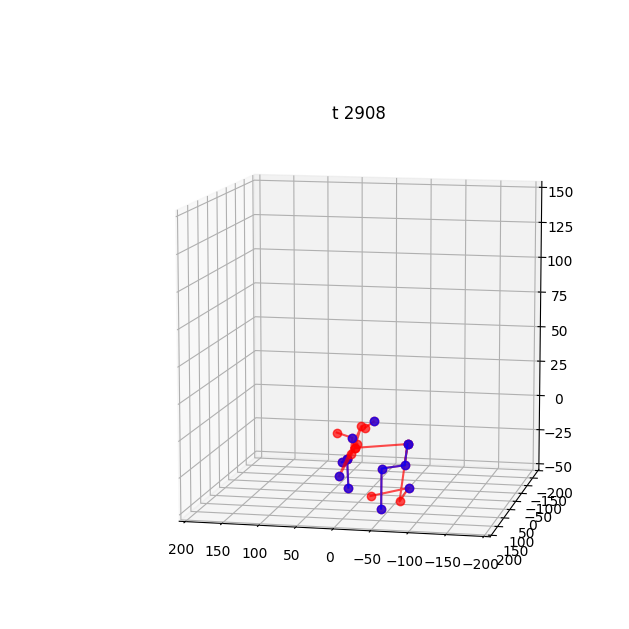

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = fourlayer_onlygood_fillednandata[badindex].reshape((-1,19,3)) #Nan filled with VAE prediction
tw = nandata[badindex].reshape((-1,19,3)) # Original
skipevery = 100


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,fourlayer_onlygood_fillednandata[badindex].shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    #plt.savefig("/home/shin/Four_Layer_Onlygood_FilledvsNan/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

<IPython.core.display.Javascript object>


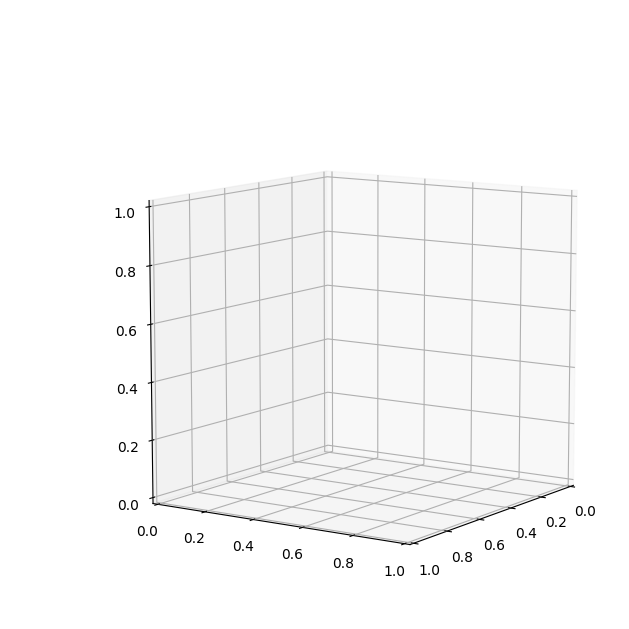

IndexError: index 4206700 is out of bounds for axis 0 with size 4204007

In [10]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = fourlayer_new_fillednandata[badindex].reshape((-1,19,3)) #Nan filled with VAE prediction
tw = nandata[badindex].reshape((-1,19,3)) # Original
skipevery = 100


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,fourlayer_new_fillednandata[badindex].shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    plt.savefig("/home/shin/Four_Layer_New_FilledvsNan_Nocenterpointerror/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

<IPython.core.display.Javascript object>


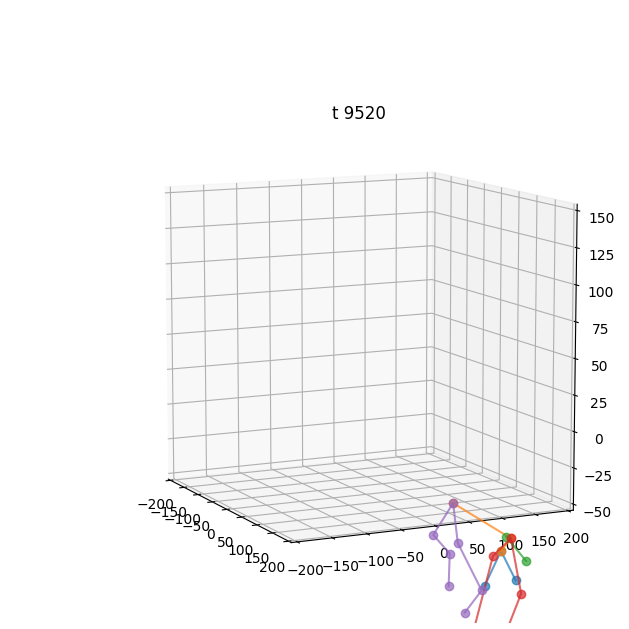

KeyboardInterrupt: 

In [10]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = fourlayer_onlygood_fillednandata[badindex].reshape((-1,19,3)) #Nan filled with VAE prediction
#tw = nandata[badindex].reshape((-1,19,3)) # Original
skipevery = 100


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,fourlayer_onlygood_fillednandata[badindex].shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7)
      #  ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    #plt.savefig("/home/shin/Four_Layer_New_FilledvsNan_Nocenterpointerror/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

# Filling original with VAE

In [13]:
variational_ae = tf.keras.models.load_model('saved_model/four_layer_4')

In [12]:
dropdatacentered = np.load('dropdatacentered.npy')

In [37]:
sample = dropdatacentered[::5]

In [16]:
predsample = variational_ae.predict(sample)

<IPython.core.display.Javascript object>


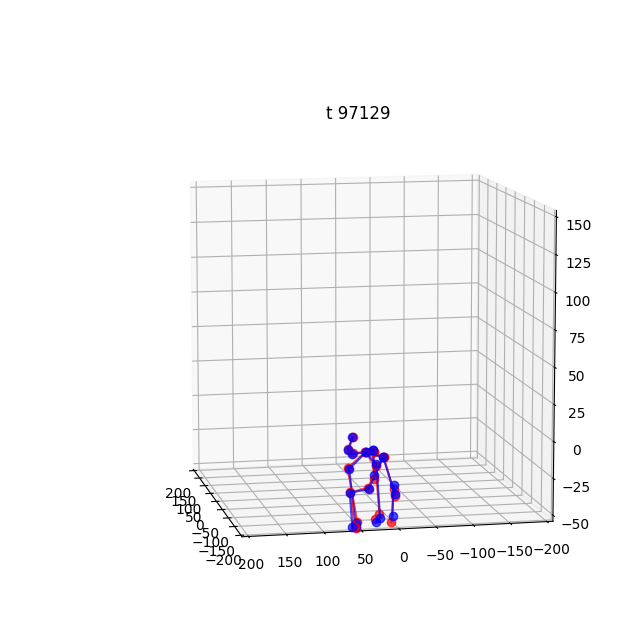

KeyboardInterrupt: 

In [18]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = predsample.reshape((-1,19,3)) #Nan filled with VAE prediction
tw = sample.reshape((-1,19,3)) # Original
skipevery = 10


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,predsample.shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    #plt.savefig("/home/shin/Four_Layer_New_FilledvsNan_Nocenterpointerror/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

In [ ]:
#badX12 = np.where(np.mean(np.linalg.norm(X_good_filtered.reshape((-1,19,3))-predictedX_good_filtered.reshape((-1,19,3)), axis=2), axis=1) >= 35)
badX14 = np.where(np.any(np.linalg.norm(sample.reshape((-1,19,3))-predictedX_sample_filtered_new.reshape((-1,19,3)), axis=2) >= 15, axis=1)) 
goodX14 = np.setdiff1d(np.arange(sample.shape[0]), badX14)
badXX14 = np.setdiff1d(np.arange(sample.shape[0]), goodX14)
sample_good_filtered_new = sample[goodX14,]
sample_bad_filtered_new = sample[badXX14,]
print('Shape of X = '+str(np.shape(sample))+'\n')
print('Shape of good X = '+str(np.shape(sample_good_filtered_new))+'\n')
print('Shape of bad X = '+str(np.shape(sample_bad_filtered_new))+'\n')

In [40]:
bad_originalindex = np.where(np.any(np.linalg.norm(sample.reshape((-1,19,3))-predsample.reshape((-1,19,3)), axis=2) >= 15, axis=1)) 

In [34]:
bad_original = sample[bad_originalindex]

In [25]:
bad_originalindex

(array([      1,    1388,    1405, ..., 3154070, 3154071, 3154072]),)

In [35]:
bad_original.shape

(660470, 57)

In [39]:
for i in range(len(sample)):
    
    fourlayer_fillednandata[bad[i,0], bad[i,1]] = predictedeh5[bad[i,0], bad[i,1]]

(3155199, 57)

In [63]:
another = np.where(np.linalg.norm(sample.reshape((-1,19,3))-predsample.reshape((-1,19,3)), axis=2) >= 15)

In [91]:
another[:1]

(array([      1,       1,    1388, ..., 3154070, 3154071, 3154072]),)

In [68]:
np.linalg.norm(sample[:2].reshape((-1,19,3))-predsample[:2].reshape((-1,19,3)), axis=2)[0,0]

2.449862335620451

In [87]:
np.linalg.norm(sample[:2].reshape((-1,19,3))-predsample[:2].reshape((-1,19,3)), axis=2)[1]

array([ 3.75397405,  1.24151201,  4.41767577,  7.6394    ,  4.00896569,
        4.75522551,  5.57760242, 10.81296037,  5.10730568, 17.92598418,
        5.34799415,  1.21535725,  4.06724426, 15.86538311,  7.26231869,
        3.62779787,  4.70095579,  2.62180797,  9.12349227])

In [80]:
testsample.reshape(-1,19,3)[0,1]

array([ 45.33841454, -13.93822058, -59.32138529])

In [75]:
np.save('sample.npy', sample)

In [111]:
testsample = np.load('sample.npy')

In [70]:
condition = np.linalg.norm(sample.reshape((-1,19,3))-predsample.reshape((-1,19,3)), axis=2)

In [112]:
for i in range(len(sample)):
    for j in range(predsample.reshape(-1,19,3).shape[1]):
        if condition[i,j] > 10:
            testsample.reshape(-1,19,3)[i,j] = predsample.reshape(-1,19,3)[i,j]
    

In [113]:
testingindex = np.unique(np.where(np.linalg.norm(sample.reshape((-1,19,3))-predsample.reshape((-1,19,3)), axis=2) >= 10)[:1])

In [114]:
testingindex.shape

(660470,)

<IPython.core.display.Javascript object>


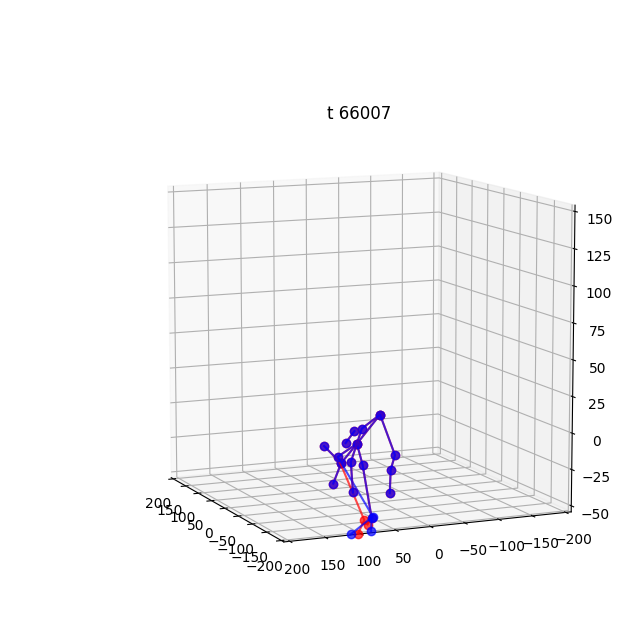

IndexError: index 660640 is out of bounds for axis 0 with size 660470

In [115]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = testsample[testingindex].reshape((-1,19,3)) #Nan filled with VAE prediction
tw = sample[testingindex].reshape((-1,19,3)) # Original
skipevery = 10


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,testsample[testingindex].shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    plt.savefig("/home/shin/OriginalDataFix/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

# Trying this out in predicted filled nan

In [4]:
nandata = np.load('nandata.npy')
badindex = np.load('badindex.npy')
fourlayer_new_fillednandata = np.load('fourlayer_new_fillednandata.npy')

In [5]:
variational_ae = tf.keras.models.load_model('saved_model/four_layer_4')

In [6]:
predfillednan = variational_ae.predict(fourlayer_new_fillednandata[badindex])

In [7]:
testingextrafill = np.load('fourlayer_new_fillednandata.npy')

In [8]:
condition1 = np.linalg.norm(fourlayer_new_fillednandata[badindex].reshape((-1,19,3))-predfillednan.reshape((-1,19,3)), axis=2)

In [16]:
np.unique(np.where(np.linalg.norm(fourlayer_new_fillednandata[badindex].reshape((-1,19,3))-predfillednan.reshape((-1,19,3)), axis=2) >= 15)[:1]).shape

(2635828,)

In [13]:
fourlayer_new_fillednandata[badindex].shape

(4204007, 57)

In [ ]:
for i in range(len(testingextrafill[badindex])):
    for j in range(testingextrafill.reshape(-1,19,3).shape[1]):
        if condition1[i,j] > 15:
            testingextrafill[badindex].reshape(-1,19,3)[i,j] = predfillednan.reshape(-1,19,3)[i,j]
    

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

connections = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]


ts = testingextrafill[badindex].reshape((-1,19,3)) #Nan filled with VAE prediction
tw = fourlayer_new_fillednandata[badindex].reshape((-1,19,3)) # Original
skipevery = 10


fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
# fig.show()
fig.canvas.draw()
count = 0
for t in range(1,fourlayer_new_fillednandata[badindex]].shape[0], 57):
    ax1.clear()
    for conn in connections:
        ax1.plot(ts[t*skipevery,conn,0],ts[t*skipevery,conn,1], ts[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'red')
        ax1.plot(tw[t*skipevery,conn,0],tw[t*skipevery,conn,1], tw[t*skipevery,conn,2], 'o-', alpha=0.7, color = 'blue')
    ax1.set_xlim([-200, 200])
    ax1.set_ylim([-200, 200])
    ax1.set_zlim([-50, 150])
    ax1.view_init(10, count/0.5)
    count += 1
    ax1.set_title('t %i'%(t*1)) 
    plt.savefig("/home/shin/BadDataExtraFix/Graph" + str(t) +".png", format="PNG")
    
    
    fig.canvas.draw()   

### 3D Graph to see if the points are centered

# Replace Centerpoint error corrected Data with Re-Centered Data

In [9]:
datafiltered = np.load('diego_mocap_files_rat_JDM31_day_13_nan.npy')
missingcenter = np.argwhere(np.isnan(datafiltered.reshape(-1,60)[:,58:60]))
missingcenterindex = np.unique(missingcenter[:,0])

In [10]:
missingcenterindex.shape

(1399497,)

In [12]:
missingcenterdata = datafiltered[missingcenterindex]

In [13]:
missingcenterdata.shape

(1399497, 60)

In [54]:
df = pd.DataFrame(datafiltered)
df = df.interpolate(method='linear', limit_direction='both', axis=0)
interpolated = df.to_numpy()

In [55]:
interpolated.shape

(19980000, 60)

In [56]:
interpolatedmissingcenterdata = interpolated[missingcenterindex]

In [16]:
badmissingcenterdata = np.argwhere(np.isnan(missingcenterdata.reshape(-1,60)[:,:57]))
badindexmissingcenterdata = np.unique(badmissingcenterdata[:,0])

In [21]:
missingcenterdata.shape[0]

1399497

In [22]:
goodcenterdataindex = np.setdiff1d(np.arange(missingcenterdata.shape[0]), badindexmissingcenterdata)

In [23]:
goodmissingcenterdata = missingcenterdata[goodcenterdataindex,]

In [57]:
goodinterpolatedmissingcenterdata = interpolatedmissingcenterdata[goodcenterdataindex,]

In [59]:
np.save('goodinterpolatedmissingcenterdata.npy',goodinterpolatedmissingcenterdata)

In [58]:
goodinterpolatedmissingcenterdata.shape

(908575, 60)

In [27]:
goodmissingcenterdata.shape

(908575, 60)

# Creating Another Training for the Missing Center Data Points

In [60]:
X_train = np.delete(goodinterpolatedmissingcenterdata, list(range(0,len(goodinterpolatedmissingcenterdata),7)), axis =0)
X_valid = goodinterpolatedmissingcenterdata[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[60])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(60, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae3 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae3.add_loss(K.mean(latent_loss) / 60.)

#compiling and running
variational_ae3.compile(loss="mse", optimizer="adam")

# define the checkpoint
#filepath = 'saved_model/four_layer_2'
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

##
vae_history = variational_ae3.fit(X_train, X_train, epochs=300, verbose=1, batch_size=1500, validation_data=(X_valid, X_valid), shuffle = True) #, callbacks=callbacks_list)

Training Set Shape = (778778, 60)

Validation Set Shape = (129797, 60)

Epoch 1/300
520/520 [==============================] - 5s 9ms/step - loss: 2158.3204 - val_loss: 569.4558
Epoch 2/300
520/520 [==============================] - 4s 8ms/step - loss: 442.8261 - val_loss: 341.3794
Epoch 3/300
520/520 [==============================] - 4s 8ms/step - loss: 306.6741 - val_loss: 199.1252
Epoch 4/300
520/520 [==============================] - 4s 8ms/step - loss: 180.4577 - val_loss: 146.2408
Epoch 5/300
520/520 [==============================] - 4s 8ms/step - loss: 141.8974 - val_loss: 131.9389
Epoch 6/300
520/520 [==============================] - 4s 8ms/step - loss: 131.2060 - val_loss: 117.7793
Epoch 7/300
520/520 [==============================] - 4s 8ms/step - loss: 113.5630 - val_loss: 103.7151
Epoch 8/300
520/520 [==============================] - 4s 8ms/step - loss: 101.9648 - val_loss: 94.1492
Epoch 9/300
520/520 [==============================] - 4s 8ms/step - loss: 91.4676 - val

520/520 [==============================] - 4s 8ms/step - loss: 23.1572 - val_loss: 23.4144
Epoch 80/300
520/520 [==============================] - 4s 8ms/step - loss: 23.2306 - val_loss: 22.9175
Epoch 81/300
520/520 [==============================] - 4s 8ms/step - loss: 22.5602 - val_loss: 21.8274
Epoch 82/300
520/520 [==============================] - 4s 8ms/step - loss: 22.7272 - val_loss: 21.9645
Epoch 83/300
520/520 [==============================] - 4s 8ms/step - loss: 22.3391 - val_loss: 23.2905
Epoch 84/300
520/520 [==============================] - 4s 8ms/step - loss: 22.3011 - val_loss: 22.1387
Epoch 85/300
520/520 [==============================] - 4s 8ms/step - loss: 23.4821 - val_loss: 22.3516
Epoch 86/300
520/520 [==============================] - 4s 8ms/step - loss: 22.0608 - val_loss: 21.9815
Epoch 87/300
520/520 [==============================] - 4s 9ms/step - loss: 22.1629 - val_loss: 21.6471
Epoch 88/300
520/520 [==============================] - 4s 8ms/step - loss: 2

520/520 [==============================] - 4s 8ms/step - loss: 17.0129 - val_loss: 17.2553
Epoch 236/300
520/520 [==============================] - 4s 8ms/step - loss: 17.1045 - val_loss: 17.1197
Epoch 237/300
520/520 [==============================] - 4s 8ms/step - loss: 17.2295 - val_loss: 17.2212
Epoch 238/300
520/520 [==============================] - 4s 8ms/step - loss: 16.9787 - val_loss: 17.0537
Epoch 239/300
520/520 [==============================] - 4s 8ms/step - loss: 17.2201 - val_loss: 17.0218
Epoch 240/300
520/520 [==============================] - 4s 8ms/step - loss: 16.9589 - val_loss: 16.8665
Epoch 241/300
520/520 [==============================] - 4s 8ms/step - loss: 17.1465 - val_loss: 17.8042
Epoch 242/300
520/520 [==============================] - 4s 8ms/step - loss: 16.9095 - val_loss: 17.4260
Epoch 243/300
520/520 [==============================] - 4s 8ms/step - loss: 17.2961 - val_loss: 16.8885
Epoch 244/300
520/520 [==============================] - 4s 8ms/step 

In [61]:
X_train = np.delete(goodinterpolatedmissingcenterdata[:,:54], list(range(0,len(goodmissingcenterdata),7)), axis =0)
X_valid = goodmissingcenterdata[:,:54][::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[54])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(30, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
X_train = np.delete(goodinterpolatedmissingcenterdata, list(range(0,len(goodinterpolatedmissingcenterdata),7)), axis =0)
X_valid = goodinterpolatedmissingcenterdata[::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[60])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(20, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(20, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(60, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae3 = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae3.add_loss(K.mean(latent_loss) / 60.)

#compiling and running
variational_ae3.compile(loss="mse", optimizer="adam")

# define the checkpoint
#filepath = 'saved_model/four_layer_2'
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

##
vae_history = variational_ae3.fit(X_train, X_train, epochs=300, verbose=1, batch_size=1500, validation_data=(X_valid, X_valid), shuffle = True) #, callbacks=callbacks_list)
decoder_inputs = Input(shape=[codings_size])
x = Dense(30, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(54, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae.add_loss(K.mean(latent_loss) / 54.)

#compiling and running
variational_ae.compile(loss="mse", optimizer="adam")

# define the checkpoint
#filepath = 'saved_model/four_layer_2'
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

##
vae_history = variational_ae.fit(X_train, X_train, epochs=300, verbose=1, batch_size=1500, validation_data=(X_valid, X_valid), shuffle = True) #, callbacks=callbacks_list

Training Set Shape = (778778, 54)

Validation Set Shape = (129797, 54)

Training Set Shape = (778778, 60)

Validation Set Shape = (129797, 60)

Epoch 1/300
520/520 [==============================] - 5s 8ms/step - loss: 2148.0437 - val_loss: 674.6306
Epoch 2/300
520/520 [==============================] - 4s 8ms/step - loss: 482.4764 - val_loss: 340.8856
Epoch 3/300
520/520 [==============================] - 4s 8ms/step - loss: 311.1169 - val_loss: 209.0506
Epoch 4/300
520/520 [==============================] - 4s 8ms/step - loss: 186.1620 - val_loss: 150.4595
Epoch 5/300
520/520 [==============================] - 4s 8ms/step - loss: 146.1919 - val_loss: 131.3086
Epoch 6/300
520/520 [==============================] - 4s 8ms/step - loss: 127.8253 - val_loss: 114.4432
Epoch 7/300
520/520 [==============================] - 4s 8ms/step - loss: 111.8759 - val_loss: 100.8909
Epoch 8/300
520/520 [==============================] - 4s 8ms/step - loss: 97.8601 - val_loss: 90.9493
Epoch 9/300
520/5

KeyboardInterrupt: 

In [30]:
X_train = np.delete(goodmissingcenterdata[:,:57], list(range(0,len(goodmissingcenterdata),7)), axis =0)
X_valid = goodmissingcenterdata[:,:57][::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(20, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(20, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae.compile(loss="mse", optimizer="adam")


vae_history = variational_ae.fit(X_train, X_train, epochs=300, verbose=1, batch_size=1500, validation_data=(X_valid, X_valid), shuffle = True)

Training Set Shape = (778778, 57)

Validation Set Shape = (129797, 57)

Epoch 1/300
520/520 [==============================] - 5s 8ms/step - loss: 1331.5928 - val_loss: 276.8206
Epoch 2/300
520/520 [==============================] - 4s 7ms/step - loss: 251.7872 - val_loss: 190.7757
Epoch 3/300
520/520 [==============================] - 4s 7ms/step - loss: 173.9327 - val_loss: 132.2493
Epoch 4/300
520/520 [==============================] - 4s 7ms/step - loss: 125.4949 - val_loss: 111.5837
Epoch 5/300
520/520 [==============================] - 4s 8ms/step - loss: 107.5239 - val_loss: 92.2442
Epoch 6/300
520/520 [==============================] - 4s 8ms/step - loss: 88.9228 - val_loss: 76.8540
Epoch 7/300
520/520 [==============================] - 4s 7ms/step - loss: 74.0837 - val_loss: 66.7543
Epoch 8/300
520/520 [==============================] - 4s 7ms/step - loss: 65.3086 - val_loss: 61.0902
Epoch 9/300
520/520 [==============================] - 4s 8ms/step - loss: 59.5045 - val_loss:

520/520 [==============================] - 4s 7ms/step - loss: 19.8261 - val_loss: 21.9295
Epoch 80/300
520/520 [==============================] - 4s 7ms/step - loss: 19.9516 - val_loss: 18.9583
Epoch 81/300
520/520 [==============================] - 4s 7ms/step - loss: 19.4868 - val_loss: 18.9156
Epoch 82/300
520/520 [==============================] - 4s 7ms/step - loss: 19.1338 - val_loss: 19.1240
Epoch 83/300
520/520 [==============================] - 4s 7ms/step - loss: 19.5049 - val_loss: 19.3812
Epoch 84/300
520/520 [==============================] - 4s 7ms/step - loss: 19.0641 - val_loss: 18.7363
Epoch 85/300
520/520 [==============================] - 4s 7ms/step - loss: 18.7961 - val_loss: 19.6967
Epoch 86/300
520/520 [==============================] - 4s 7ms/step - loss: 18.8652 - val_loss: 19.2548
Epoch 87/300
520/520 [==============================] - 4s 7ms/step - loss: 18.8147 - val_loss: 18.4487
Epoch 88/300
520/520 [==============================] - 4s 7ms/step - loss: 1

KeyboardInterrupt: 

In [ ]:
X_train = np.delete(goodmissingcenterdata[:,:57], list(range(0,len(goodmissingcenterdata),7)), axis =0)
X_valid = goodmissingcenterdata[:,:57][::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(20, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(20, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae.compile(loss="mse", optimizer="adam")


vae_history = variational_ae.fit(X_train, X_train, epochs=300, verbose=1, batch_size=1500, validation_data=(X_valid, X_valid), shuffle = True)

In [ ]:
X_train = np.delete(goodmissingcenterdata[:,:57], list(range(0,len(goodmissingcenterdata),7)), axis =0)
X_valid = goodmissingcenterdata[:,:57][::7]

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

codings_size = 10

inputs = layers.Input(shape=[57])
z = inputs
z = layers.Dense(50, activation= None)(z)
z = layers.Dense(45, activation= 'tanh')(z)
z = layers.Dense(20, activation= None)(z)
codings_mean = Dense(codings_size, activation = None)(z) #tanh suppresses encoding
codings_log_var = Dense(codings_size, activation = None)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(20, activation = None)(decoder_inputs)
x = Dense(45, activation = 'tanh')(x)
x = Dense(50, activation = None)(x)
x = Dense(57, activation = None)(x)
outputs = x
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae.add_loss(K.mean(latent_loss) / 57.)

#compiling and running
variational_ae.compile(loss="mse", optimizer="adam")


vae_history = variational_ae.fit(X_train, X_train, epochs=300, verbose=1, batch_size=1500, validation_data=(X_valid, X_valid), shuffle = True)